<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px;" align="center">Segment customers of a website - P5</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;" >
    <h3 style="width: 100%; text-align: center; float: left; font-size: 24px;" align="center">| Analysis notebook |</h3>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <h4 style="width: 100%; text-align: center; float: left; font-size: 24px;" align="center">Data Scientist course - OpenClassrooms</h4>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries and functions</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.1. Libraries and functions</h3>
</div>

In [1]:
## General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import squarify
from statsmodels.graphics.gofplots import qqplot

## df_analysis
import io
import gc
import timeit
import math
from math import pi
from collections import Counter
from math import prod
import scipy.stats as stats
from itertools import combinations

## Scikit Learn 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline
sns.set_theme(style="darkgrid")

SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.2. Functions declaration</h3>
</div>

In [2]:
def df_analysis(df, name_df, *args, **kwargs):
    """
    Method used to analyze on the DataFrame.

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze
        name_df (str): Dataset name
        
        *args, **kwargs:
        -----------------
            columns (list): Dataframe keys in list format
            flag (str): Flag to show complete information about the dataset to analyse
                        "complete" shows all information about the dataset

    Returns:
    -----------------
        None. 
        Print the analysis on the Dataset. 
    """
    
    # Getting the variables
    columns = kwargs.get("columns", None)
    type_analysis = kwargs.get("type_analysis", None)
    
    ORDERING_COMPLETE = [
        "name", "type", "records", "unique", "# NaN", "% NaN", "mean", "min", "25%", "50%", "75%", "max", "std"
    ]
    
    # Calculating the memory usage based on dataframe.info()
    buf = io.StringIO()
    df.info(buf=buf)
    memory_usage = buf.getvalue().split('\n')[-2]
    
    if df.empty:
        print("The", name_df, "dataset is empty. Please verify the file.")
    else:
        empty_cols = [col for col in df.columns if df[col].isna().all()] # identifying empty columns
        df_rows_duplicates = df[df.duplicated()] #identifying full duplicates rows
        
        # Creating a dataset based on Type object and records by columns
        type_cols = df.dtypes.apply(lambda x: x.name).to_dict() 
        df_resume = pd.DataFrame(list(type_cols.items()), columns = ["name", "type"])
        df_resume["records"] = list(df.count())
        df_resume["# NaN"] = list(df.isnull().sum())
        df_resume["% NaN"] = list(((df.isnull().sum() / len(df.index))*100).round(2))
        
        print("\nAnalysis of", name_df, "dataset")
        print("--------------------------------------------------------------------")
        print("- Dataset shape:                 ", df.shape[0], "rows and", df.shape[1], "columns")
        print("- Total of NaN values:           ", df.isna().sum().sum())
        print("- Percentage of NaN:             ", round((df.isna().sum().sum() / prod(df.shape)) * 100, 2), "%")
        print("- Total of full duplicates rows: ", df_rows_duplicates.shape[0])
        print("- Total of empty rows:           ", df.shape[0] - df.dropna(axis="rows", how="all").shape[0]) if df.dropna(axis="rows", how="all").shape[0] < df.shape[0] else \
                    print("- Total of empty rows:            0")
        print("- Total of empty columns:        ", len(empty_cols))
        print("  + The empty column is:         ", empty_cols) if len(empty_cols) == 1 else \
                    print("  + The empty column are:         ", empty_cols) if len(empty_cols) >= 1 else None
        print("- Unique indexes:                ", df.index.is_unique)
        
        if columns is not None:
            print("\n- The key(s):", columns, "is not present multiple times in the dataframe.\n  It CAN be used as a primary key.") if df.size == df.drop_duplicates(columns).size else \
                print("\n- The key(s):", columns, "is present multiple times in the dataframe.\n  It CANNOT be used as a primary key.")
            
        if type_analysis == "summarized":
            print("\n")
        
        if type_analysis is None or type_analysis != "summarized":
            pd.set_option("display.max_rows", None) # show full of showing rows
            pd.set_option("display.max_columns", None) # show full of showing cols
            pd.set_option("display.max_colwidth", None) # show full width of showing cols
            pd.set_option("display.float_format", lambda x: "%.5f" % x) # show full content in cell    
            
            if type_analysis is None or type_analysis != "complete":
                print("\n- Type object and records by columns      (",memory_usage,")")
                print("--------------------------------------------------------------------")
            elif type_analysis == "complete" and (df.select_dtypes(["int64"]).shape[1] > 0 or df.select_dtypes(["float64"]).shape[1] > 0):
                df_resume["unique"] = list(df.nunique())
                df_desc = pd.DataFrame(df.describe().T).reset_index()
                df_desc = df_desc.rename(columns={"index": "name"})
                df_resume = df_resume.merge(right=df_desc[["name", "mean", "min", "25%", "50%", "75%", "max", "std"]], on="name", how="left")
                df_resume = df_resume[ORDERING_COMPLETE]
                print("\n- Type object and records by columns      (",memory_usage,")")
                print("--------------------------------------------------------------------")
            
            display(df_resume.sort_values("records", ascending=False))
            
            pd.reset_option("display.max_rows") # reset max of showing rows
            pd.reset_option("display.max_columns") # reset max of showing cols
            pd.reset_option("display.max_colwidth") # reset width of showing cols
            pd.reset_option("display.float_format") # reset show full content in cell
            
        # deleting dataframe to free memory
        if type_analysis == "complete":
            
            if df.select_dtypes(["int64"]).shape[1] > 0 or df.select_dtypes(["float64"]).shape[1] > 0:
                del [[df_resume, df_desc]]
            else:
                del [[df_resume]]
            
            gc.collect()
            df_resume, df_desc = (pd.DataFrame() for i in range(2))
        else:
            del df_resume
            gc.collect()
            df_resume = pd.DataFrame()
            

def normality_test(df):
    """
    Method used to make the normality test.

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze

    Returns:
    -----------------
        None. 
        Print the tests on a new Dataset. 
    """
    
    list_test = {
        "Shapiro-Wilk":stats.shapiro, "D’Agostino’s K^2":stats.normaltest,
        "Kolmogorov-Smirnov":stats.kstest
    }
    
    
    alpha = 0.05
    fail_to_reject_H = "Sample looks Gaussian (fail to reject H0)"
    reject_H = "Sample does not look Gaussian (reject H0)"
    
    variable, test_name, result, hypothesis = [[] for i in range(4)]
    
    for key, value in list_test.items():
    
        for col in df.columns:
            
            if df[col].dtypes == "float64" or df[col].dtypes == "int64":
                variable.append(col)
                test_name.append(key)
                
                if key == "Kolmogorov-Smirnov":
                    stat, p_value = value(df[col], cdf="norm")
                else:
                    stat, p_value = value(df[col])
                    
                result.append("Statistics=%.3f, p-value=%.3f" % (stat, p_value))
                hypothesis.append(fail_to_reject_H.translate(SUB)) if p_value > alpha else hypothesis.append(reject_H.translate(SUB))
                
    df_normality_test = pd.DataFrame({
                            "variable": variable,
                            "normality test": test_name, 
                            "result": result,
                            "hypothesis": hypothesis})
    
    display(df_normality_test)
    

def highlight_max(data, color="yellow"):
    """ 
    highlight the maximum in a Series or DataFrame
    
    Parameters:
    -----------------  
        data (pandas.DataFrame): Dataset to analyze
        color (str) : color to highlight into the dataset
        
    Returns:
    -----------------
        data (pandas.DataFrame): Dataset analyzed
   """  
    
    #attr = 'background-color: {}'.format(color) + 'color: black'
    attr = "background-color: yellow; color: black"
    
    #remove % and cast to float
    data = data.replace("%","", regex=True).astype(float)
    
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else "" for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        
        return pd.DataFrame(np.where(is_max, attr, ""),
                            index=data.index, columns=data.columns)

      
def df_imputations(training_df, test_df, imputation, scaler):
    """
    Method used for making imputations on missing-values

    Parameters:
    -----------------
        training_df : pandas.DataFrame
        Training dataset.
        
        test_df : pandas.DataFrame
        Dataset to impute.
        
        imputation : list
        Imputation's method ["SimpleImputer", "KNNImputer", "IterativeImputer"].
        
        scaler : obj
        Object StandardScaler().
        
    Returns:
    -----------------
        df_to_impute : pandas.DataFrame
        Dataset imputed.
        
    """
    
    # Initializing the imputer
    if imputation == "SimpleImputer":
        impute = SimpleImputer(missing_values=np.nan, strategy="mean")
    elif imputation == "KNNImputer":
        impute = KNNImputer()
    elif imputation == "IterativeImputer":
        impute = IterativeImputer(estimator=BayesianRidge(), 
                                  imputation_order="ascending", 
                                  initial_strategy="mean")
        
    # Making the imputation fit() in train set
    impute.fit(training_df)
    
    # Making the imputation transform() in test set
    temp_imputed = impute.transform(test_df)
    
    # Rebuilding the dataset as original 
    df_imputed = pd.DataFrame(temp_imputed, index=test_df.index, columns=test_df.columns)
    
    # Desnormalizing and formatting data to DataFrame
    df_imputed = pd.DataFrame(scaler.inverse_transform(df_imputed), index=df_imputed.index, columns=df_imputed.columns)
    
    return df_imputed


def most_common_words(labels, quantity):
    """
    Method used to split all words present in list and count 
    how many times it is repeated in the list. 

    Parameters:
    -----------------
        labels (list): List of strings to split.
        quantity (int): Amount of most common words to return.

    Returns:
    -----------------
        counter (liste): List of words splitted with its number of ocurrences.
    """
    
    words = [i.split("_", 1)[0] for i in labels]
    counter = Counter(words).most_common(quantity)
    
    df = pd.DataFrame(counter, columns=["Word", "Occurence number"])\
                        .sort_values(by="Occurence number", ascending=True)
    return df
    
    
def RFM_analysis(df, customer_id, recency, frequency, value, satisfaction):
    """
    Method to make RFM Analysis stand for recency, frequency, and monetary value.

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze
        customer_id (str): Feature with customer identifier
        recency (str): Feature with recency information
        frequency (str): Feature with frequency information
        value (str): Feature with monetary value information
        satisfaction (str): Feature with customer score

    Returns:
    -----------------
        df_RFM (pandas.DataFrame): Dataset with RFM segmentation
    """
    
    max_day = df[recency].max()
    
    df_RFM = df.groupby([customer_id]).agg({
        recency : lambda x: (max_day - x.max()).days,
        frequency : "count",
        value: "sum",
        satisfaction: "mean"
    })
    
    df_RFM.columns = ["recency", "frequency", "monetary", "satisfaction"]
    
    df_RFM["avg_basket"] = df_RFM["monetary"] / df_RFM["frequency"]
    
    df_RFM = df_RFM[["recency", "frequency", "monetary", "avg_basket", "satisfaction"]]
    df_RFM.reset_index(inplace=True)
    
    return df_RFM

    
def quintile_score(X, quantile, rfm_feature):
    """
    Method used to attribute score (between 1 and 5) based on positions into quantiles.
    5 is the highest value. 1 is the worst value.
    The bigger the X, the bigger the score

    Parameters:
    -----------------
        X (int): Feature value to attribute score
        quantiles (pandas.DataFrame): Dataset with values at the given quantile over RFM axis
        rfm_feature(str): Feature identifier

    Returns:
    -----------------
        score (int)
    """    
    
    if rfm_feature != "recency":
        if X <= quantiles[rfm_feature][.2]:
            return 1
        elif X <= quantiles[rfm_feature][.4]:
            return 2
        elif X <= quantiles[rfm_feature][.6]:
            return 3
        elif X <= quantiles[rfm_feature][.8]:
            return 4
        else:
            return 5
    else:
        if X <= quantiles[rfm_feature][.2]:
            return 5
        elif X <= quantiles[rfm_feature][.4]:
            return 4
        elif X <= quantiles[rfm_feature][.6]:
            return 3
        elif X <= quantiles[rfm_feature][.8]:
            return 2
        else:
            return 1
        

def RFM_segments(score):
    """
    Method used to make the customer segmentation based on Exponea.
    
    For more details, you can see the links below
    - https://docs.exponea.com/docs/rfm-segmentation
    - https://docs.exponea.com/docs/rfm-segmentation-business-use

    Parameters:
    -----------------
        score (int): Score of the customer

    Returns:
    -----------------
        customer_segment (string)
    """    
    
    exponea_segmentation = {
        "Champions" : [555, 554, 544, 545, 454, 455, 445],
        "Loyal" : [543, 444, 435, 355, 354, 345, 344, 335],
        "Potential Loyalist" : [553, 551, 552, 541, 542, 533, 532, 
                                531, 452, 451, 442, 441, 431, 453, 
                                433, 432, 423, 353, 352, 351, 342, 
                                341, 333, 323],
        "New Customers" : [512, 511, 422, 421, 412, 411, 311],
        "Promising" : [525, 524, 523, 522, 521, 515, 514, 513, 425, 
                       424, 413, 414, 415, 315, 314, 313],
        "Need Attention" : [535, 534, 443, 434, 343, 334, 325, 324],
        "About To Sleep" : [331, 321, 312, 221, 213, 231, 241, 251],
        "At Risk" : [255, 254, 245, 244, 253, 252, 243, 242, 235, 
                     234, 225, 224, 153, 152, 145, 143, 142, 135, 
                     134, 133, 125, 124],
        "Cannot Lose Them" : [155, 154, 144, 214, 215, 115, 114, 113],
        "Hibernating customers" : [332, 322, 231, 241, 251, 233, 232, 
                                   223, 222, 132, 123, 122, 212, 211],
        "Lost customers" : [111, 112, 121, 131, 141, 151]
    }

    customer_segment = [key for key, values in exponea_segmentation.items() if score in values]

    return customer_segment[0]


def df_spider_RFM(df, label_score, color):
    
    """
    Method used to plot RFM through spider plot

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to plot
        label_score (str): Segmentation
        color: (dict): Color for each segmentation
        
    Returns:
    -----------------
        None. 
        PLot the RFM Segmentation. 
    """
    
    # Grouping the mean based on rfm_score_label
    df_to_plot = df.groupby([label_score]).agg("mean").reset_index()
    
    # Data Standarization
    df_to_plot_std = pd.DataFrame(MinMaxScaler().fit_transform(df_to_plot[["recency", "frequency", "monetary"]]), 
                                  columns=list(df_to_plot[["recency", "frequency", "monetary"]].columns),
                                  index=df_to_plot[["recency", "frequency",	"monetary"]].index)
    
    # Concatenating the rfm score label
    df_to_plot_std = pd.concat([df_to_plot_std, df_to_plot[[label_score]]], axis=1)
    df_to_plot_std = df_to_plot_std[[label_score, "recency", "frequency", "monetary"]]
    
    # number of variable
    variables = list(df_to_plot_std)[1:]
    N = len(variables)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    fig = plt.figure(1, figsize=(18, 20))
    
    for i, segment in enumerate(df[label_score].unique()):
        
        ax = fig.add_subplot(4, 3, i + 1, polar=True)
        
        # We are going to plot the first line of the data frame.
        # But we need to repeat the first value to close the circular graph:
        values = list(df_to_plot_std.loc[i][["recency", "frequency", "monetary"]].values)
        values += values[:1]
        
        ax.set_title(segment, color=color[segment], fontdict={ "fontsize": 15, "fontweight": "bold" })
        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)
        ax.set_rlabel_position(0)
        
        # Draw one axe per variable + add labels
        plt.xticks(angles[:-1], variables, color="grey", size=8)
        ax.set_xticklabels(variables, size=12)
        ax.set_rlabel_position(0)
        
        # Draw ylabels
        ax.set_rlabel_position(0)
        plt.yticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5], ["-1.5", "-1", "-0.5", "0", "0.5", "1", "1.5"], color="grey", size=7)
        plt.ylim(-1.5, 1.5)
        
        # Plot data
        ax.plot(angles, values, color[segment], "o-", linewidth=1, linestyle="solid")

        # Fill area
        ax.fill(angles, values, color[segment], alpha=.25)

    # Show the graph
    plt.savefig("images/RFM-spider-segmentation.png")
    plt.show()

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">2. Importing files</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.1. Importing and preparing files</h3>
</div>

In [3]:
df_customers = pd.read_csv(r"datasets\olist_customers_dataset.csv")
df_products = pd.read_csv(r"datasets\olist_products_dataset.csv")
df_product_category_name_translations = pd.read_csv(r"datasets\product_category_name_translation.csv")
df_orders = pd.read_csv(r"datasets\olist_orders_dataset.csv")
df_order_payments = pd.read_csv(r"datasets\olist_order_payments_dataset.csv")
df_order_reviews = pd.read_csv(r"datasets\olist_order_reviews_dataset.csv")
df_order_items = pd.read_csv(r"datasets\olist_order_items_dataset.csv")
df_sellers = pd.read_csv(r"datasets\olist_sellers_dataset.csv")
df_geolocations = pd.read_csv(r"datasets\olist_geolocation_dataset.csv")

df_brasil_regions = pd.read_csv(r"datasets\brasil_regions.csv")

<div class="alert alert-block alert-info">
    <p>The following description of each dataset, is organized in order of importance</p>
    <ul>
       <li><b>Customer</b> dataset <b>"olist_customers_dataset.csv"</b>.<br>
           Basic customer information
        </li>
       <li><b>Order</b> dataset <b>"olist_orders_dataset.csv"</b>.<br>
           The order header with the order status
        </li>
       <li><b>Product</b> dataset <b>"olist_products_dataset.csv"</b>.<br>
           Product declarative information (category, lenght, weight, etc.)
        </li>
       <li><b>Order Items</b> dataset <b>"olist_orders_dataset.csv"</b>.<br>
           List of products ands sellers related to the order
        </li>
       <li><b>Order Payments</b> dataset <b>"olist_order_payments_dataset.csv"</b>.<br>
           All payments and its methods, related to the order
        </li>
       <li><b>Seller</b> dataset <b>"olist_sellers_dataset.csv"</b>.<br>
           Basic seller information
        </li>
       <li><b>Product Category Translation</b> dataset <b>"product_category_name_translation.csv"</b>.<br>
           Product name translation
        </li>
       <li><b>Order Reviews</b> dataset <b>"olist_order_reviews_dataset.csv"</b>.<br>
           Order reviews
        </li>
       <li><b>Geolocation</b> dataset <b>"olist_order_reviews_dataset.csv"</b>.<br>
           Geolocation data
        </li>
    </ul>
</div>

![Entity relationship diagram](images/initial/entity_relationship.png)

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Initial analysis</h2>
</div>

<div class="alert alert-block alert-info">
    <p>We consider dataset metadata located in <a href="https://www.kaggle.com/olistbr/brazilian-ecommerce", target="blank", style="font-weight: bold;">Kaggle</a> to see in details each dataset</p>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.1. Customers</h3>
</div>

In [4]:
df_analysis(df_customers, "df_customers", columns=["customer_id", "customer_unique_id"], type_analysis="complete")


Analysis of df_customers dataset
--------------------------------------------------------------------
- Dataset shape:                  99441 rows and 5 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['customer_id', 'customer_unique_id'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns      ( memory usage: 3.8+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,customer_id,object,99441,99441,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,customer_unique_id,object,99441,96096,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,customer_zip_code_prefix,int64,99441,14994,0,0.00000,35137.47458,1003.00000,11347.00000,24416.00000,58900.00000,99990.00000,29797.93900
3,customer_city,object,99441,4119,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,customer_state,object,99441,27,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


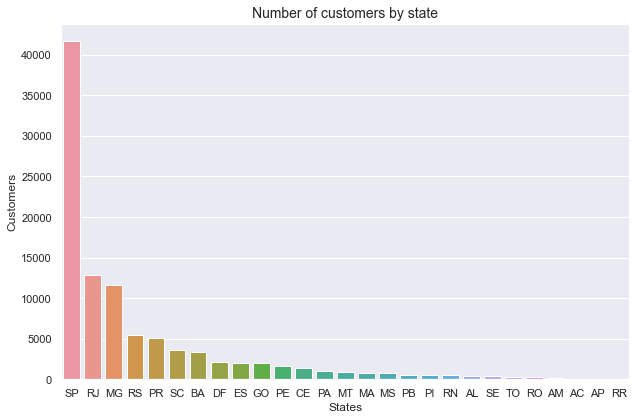

In [6]:
fig = plt.subplots(figsize=(9, 6))
plot = sns.barplot(x=df_customers["customer_state"].value_counts().index, y=df_customers["customer_state"].value_counts(), data=df_customers)
plt.xlabel("States", size=12)
plt.ylabel("Customers", size=12)
plt.title("Number of customers by state", size=14)
plt.tight_layout()
plt.savefig("images/number-of-customer-by-state.png")
plt.show()

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Dataset with basic information about customer. Below we can see some descriptions about its columns</p>
    <ul>
        <li>customer_unique_id is the pk.</li>
        <li>There is not missing-values</li>
        <li>There are 96096 customers</li>
        <li>There are 14994 zip codes</li>
        <li>There are 4119 cities</li>
        <li>There are 27 states</li>
        <li>SP (Sao Paulo) has twice as many customers as the second state with the most customers </li>
    </ul>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.2. Products</h3>
</div>

In [7]:
df_analysis(df_products, "df_products", columns=["product_id"], type_analysis="complete")


Analysis of df_products dataset
--------------------------------------------------------------------
- Dataset shape:                  32951 rows and 9 columns
- Total of NaN values:            2448
- Percentage of NaN:              0.83 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['product_id'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns      ( memory usage: 2.3+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,product_id,object,32951,32951,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,product_weight_g,float64,32949,2204,2,0.01000,2276.47249,0.00000,300.00000,700.00000,1900.00000,40425.00000,4282.03873
6,product_length_cm,float64,32949,99,2,0.01000,30.81508,7.00000,18.00000,25.00000,38.00000,105.00000,16.91446
7,product_height_cm,float64,32949,102,2,0.01000,16.93766,2.00000,8.00000,13.00000,21.00000,105.00000,13.63755
8,product_width_cm,float64,32949,95,2,0.01000,23.19673,6.00000,15.00000,20.00000,30.00000,118.00000,12.07905
1,product_category_name,object,32341,73,610,1.85000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,product_name_lenght,float64,32341,66,610,1.85000,48.47695,5.00000,42.00000,51.00000,57.00000,76.00000,10.24574
3,product_description_lenght,float64,32341,2960,610,1.85000,771.49528,4.00000,339.00000,595.00000,972.00000,3992.00000,635.11522
4,product_photos_qty,float64,32341,19,610,1.85000,2.18899,1.00000,1.00000,1.00000,3.00000,20.00000,1.73677


In [8]:
df_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


<div class="alert alert-block alert-info">
    <p>Identifying the categories with more products</p>
</div>

In [9]:
df_number_products_category = pd.DataFrame(df_products.groupby(["product_category_name"])["product_id"].count().sort_values(ascending=False).head(20)).reset_index()

In [10]:
df_number_products_category.head()

,product_category_name,product_id
0,cama_mesa_banho,3029
1,esporte_lazer,2867
2,moveis_decoracao,2657
3,beleza_saude,2444
4,utilidades_domesticas,2335


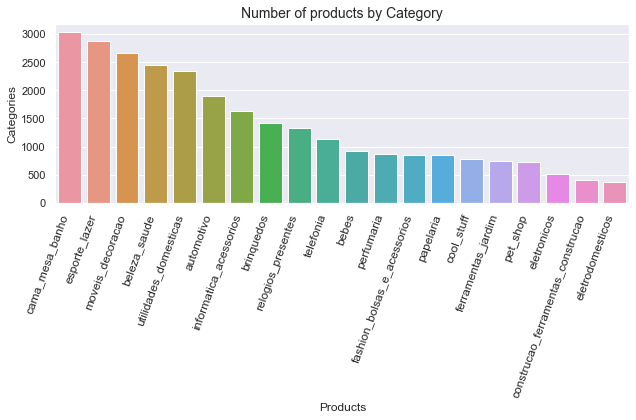

In [11]:
fig = plt.subplots(figsize=(9, 6))
plot = sns.barplot(x=df_number_products_category["product_category_name"], y=df_number_products_category["product_id"], data=df_number_products_category)

plot.set_xticklabels(labels=df_number_products_category["product_category_name"], rotation=70, size=12, horizontalalignment="right")
plt.xlabel("Products", size=12)
plt.ylabel("Categories", size=12)
plt.title("Number of products by Category", size=14)
plt.tight_layout()
plt.savefig("images/number-of-products-by-category.png")
plt.show()

In [12]:
df_correlation_matrix = pd.DataFrame(df_products.corr()).round(2)

In [13]:
mask = np.zeros_like(df_correlation_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True 

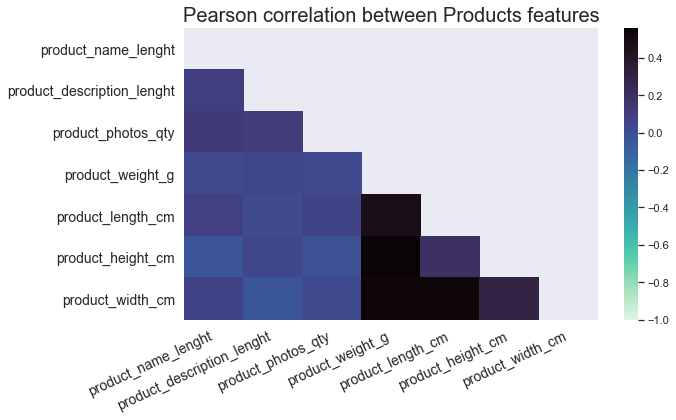

In [14]:
plt.figure(figsize=(10,6))
plt.title("Pearson correlation between Products features", size=20)

ax = sns.heatmap(df_correlation_matrix, mask=mask, vmin=-1, cmap="mako_r")

plt.xticks(rotation=25, size=14, horizontalalignment="right")
plt.yticks(rotation=0, size=14)
plt.tight_layout()
plt.savefig("images/pearson-correlation-between-products-features.png")
plt.show()

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Dataset with information about products. Below we can see some descriptions about its columns</p>
    <ul>
        <li>product_id is the pk.</li>
        <li>There are some missing-values</li>
    </ul>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.2.1. Product translations</h4>
</div>

In [15]:
df_analysis(df_product_category_name_translations, "df_product_category_name_translations", type_analysis="complete")


Analysis of df_product_category_name_translations dataset
--------------------------------------------------------------------
- Dataset shape:                  71 rows and 2 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True


,name,type,records,# NaN,% NaN
0,product_category_name,object,71,0,0.00000
1,product_category_name_english,object,71,0,0.00000


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.3. Orders</h3>
</div>

In [16]:
df_analysis(df_orders, "df_orders", columns=["order_id"], type_analysis="complete")


Analysis of df_orders dataset
--------------------------------------------------------------------
- Dataset shape:                  99441 rows and 8 columns
- Total of NaN values:            4908
- Percentage of NaN:              0.62 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['order_id'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.


,name,type,records,# NaN,% NaN
0,order_id,object,99441,0,0.00000
1,customer_id,object,99441,0,0.00000
2,order_status,object,99441,0,0.00000
3,order_purchase_timestamp,object,99441,0,0.00000
7,order_estimated_delivery_date,object,99441,0,0.00000
4,order_approved_at,object,99281,160,0.16000
5,order_delivered_carrier_date,object,97658,1783,1.79000
6,order_delivered_customer_date,object,96476,2965,2.98000


In [17]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


<div class="alert alert-block alert-info">
    <p>Analyzing the <b>order status</b></p>
</div>

In [18]:
df_orders["order_status"].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [19]:
data_piechart = df_orders["order_status"].sort_values(ascending=False).value_counts().values
labels_piechart = df_orders["order_status"].sort_values(ascending=False).value_counts().index.tolist()
textprops = dict(size=16, color="gray")
colors = ["#5975A4", "#CC8963", "#5F9E6E", "#AD5B5E", "#857AAB", "#7D6D5F", "#D095BF", "#C1B37F"]
explode = (0, 0, 0, 0, 0, 0, 0, 0)

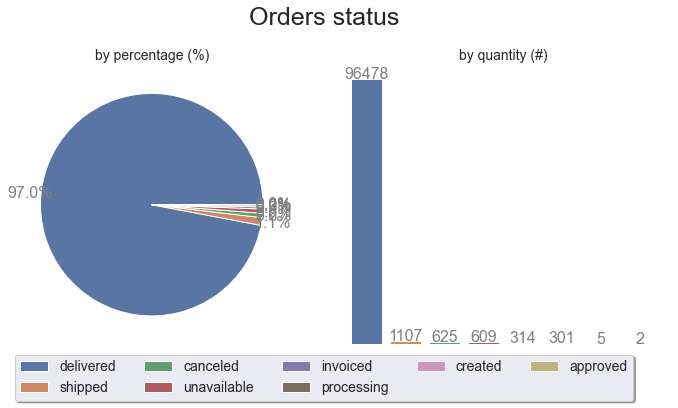

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[10,5])

fig.suptitle("Orders status", size=25)

for lb, data, color in zip(labels_piechart, data_piechart, colors):
    ax2.bar(lb, data, label=lb, color=color)
for index, data in enumerate(data_piechart):
    plt.text(x=index, y=data+1 , s=f"{data}", horizontalalignment="center", fontdict=dict(fontsize=16, color="gray"))
ax2.set_title("by quantity (#)", fontsize=14)
ax2.axis('off')

ax1.pie(x=data_piechart, explode=explode, autopct="%1.1f%%", pctdistance=1.10, 
        textprops=textprops, colors=[color for color in colors], startangle=0)
ax1.set_title("by percentage (%)", fontsize=14)

fig.legend(labels_piechart, loc="center", ncol=5, fontsize=14, bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("images/orders-status.png")
plt.show()

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Dataset with order status information. We can say that it is the order header</p>
    <ul>
        <li>order_id can be used as pk.</li>
        <li>There are missing-values in fields related to delivery</li>
    </ul>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.3.1. Orders payments</h4>
</div>

In [21]:
df_analysis(df_order_payments, "df_order_payments", columns=["order_id"], type_analysis="complete")


Analysis of df_order_payments dataset
--------------------------------------------------------------------
- Dataset shape:                  103886 rows and 5 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['order_id'] is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns      ( memory usage: 4.0+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,order_id,object,103886,99440,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,payment_sequential,int64,103886,29,0,0.00000,1.09268,1.00000,1.00000,1.00000,1.00000,29.00000,0.70658
2,payment_type,object,103886,5,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,payment_installments,int64,103886,24,0,0.00000,2.85335,0.00000,1.00000,1.00000,4.00000,24.00000,2.68705
4,payment_value,float64,103886,29077,0,0.00000,154.10038,0.00000,56.79000,100.00000,171.83750,13664.08000,217.49406


In [22]:
df_order_payments[df_order_payments.duplicated(subset=["order_id"], keep=False)].head(10)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
25,5cfd514482e22bc992e7693f0e3e8df7,2,voucher,1,45.17
35,b2bb080b6bc860118a246fd9b6fad6da,1,credit_card,1,173.84
75,3689194c14ad4e2e7361ebd1df0e77b0,2,voucher,1,57.53
84,723e462ce1ee50e024887c0b403130f3,1,credit_card,1,13.80
102,21b8b46679ea6482cbf911d960490048,2,voucher,1,43.12
121,ea9184ad433a404df1d72fa0a8764232,4,voucher,1,22.49
139,82ffe097d8ddbf319a523b9bbe7725d5,2,voucher,1,30.00
161,c61e3efc183db6b89f5556efb5aa8797,1,credit_card,1,45.50
164,487c1451b8fd7347d0e80e5aca887e91,2,voucher,1,30.00
166,65c863d90026e9dd4888e28d2135c983,2,voucher,1,50.00


In [23]:
df_order_payments[df_order_payments["order_id"] == "ea9184ad433a404df1d72fa0a8764232"]

,order_id,payment_sequential,payment_type,payment_installments,payment_value
121,ea9184ad433a404df1d72fa0a8764232,4,voucher,1,22.49
40168,ea9184ad433a404df1d72fa0a8764232,1,credit_card,1,17.78
78613,ea9184ad433a404df1d72fa0a8764232,3,voucher,1,22.49
94151,ea9184ad433a404df1d72fa0a8764232,2,voucher,1,22.49
99425,ea9184ad433a404df1d72fa0a8764232,5,voucher,1,22.47


<div class="alert alert-block alert-info">
    <p>Analyzing the <b>payment methods</b></p>
</div>

In [24]:
df_order_payments["payment_type"].unique()

array(['credit_card', 'boleto', 'voucher', 'debit_card', 'not_defined'],
      dtype=object)

In [25]:
data_piechart = df_order_payments["payment_type"].sort_values(ascending=False).value_counts().values
labels_piechart = df_order_payments["payment_type"].sort_values(ascending=False).value_counts().index.tolist()
textprops = dict(size=16, color="gray")
colors = ["#5975A4", "#CC8963", "#5F9E6E", "#AD5B5E", "#857AAB"]
explode = (0, 0, 0, 0, 0)

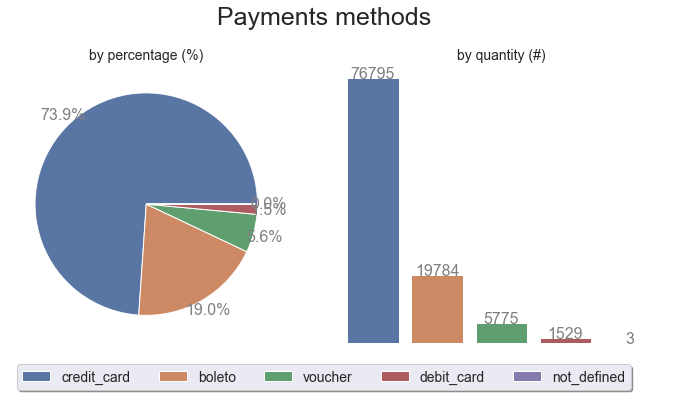

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[10,5])

fig.suptitle("Payments methods", size=25)

for lb, data, color in zip(labels_piechart, data_piechart, colors):
    ax2.bar(lb, data, label=lb, color=color)
for index, data in enumerate(data_piechart):
    plt.text(x=index, y=data+1 , s=f"{data}", horizontalalignment="center", fontdict=dict(fontsize=16, color="gray"))
ax2.set_title("by quantity (#)", fontsize=14)
ax2.axis('off')

ax1.pie(x=data_piechart, explode=explode, autopct="%1.1f%%", pctdistance=1.10, 
        textprops=textprops, colors=[color for color in colors], startangle=0)
ax1.set_title("by percentage (%)", fontsize=14)

fig.legend(labels_piechart, loc="center", ncol=5, fontsize=14, bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("images/Payments-methods.png")
plt.show()

<div class="alert alert-block alert-info">
    <p>Analyzing the <b>payment values</b></p>
</div>

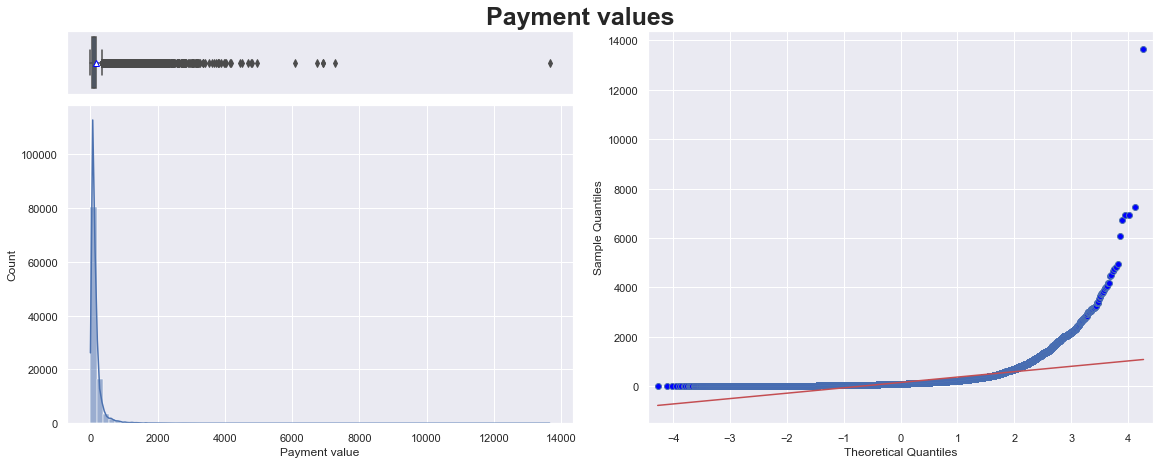


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,payment_value,Shapiro-Wilk,"Statistics=0.478, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,payment_value,D’Agostino’s K^2,"Statistics=159622.787, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,payment_value,Kolmogorov-Smirnov,"Statistics=0.994, p-value=0.000",Sample does not look Gaussian (reject H₀)


In [27]:
fig = plt.figure(constrained_layout=True, figsize=[16,6])
fig.suptitle("Payment values", size=25, fontweight="bold", y=1.05)
spec = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[1, 1], height_ratios=[1, 5])

ax_box = fig.add_subplot(spec[0, 0])
ax_hist = fig.add_subplot(spec[1, 0])
ax_qqplot = fig.add_subplot(spec[:, 1])

# Boxplot
boxplot = sns.boxplot(data=df_order_payments, x=df_order_payments["payment_value"], showmeans=True, ax=ax_box,
                      meanprops={"markerfacecolor":"white", "markeredgecolor":"blue"})
ax_box.set(xlabel="", xticks=[])
ax_box.set(yticks=[])
boxplot.set_title("")

# Histplot
sns.histplot(data=df_order_payments, x=df_order_payments["payment_value"], bins=75,  kde=True,  ax=ax_hist)
ax_hist.set(xlabel="Payment value")

# QQplot
qqplot(df_order_payments["payment_value"], line='s', ax=ax_qqplot)

plt.savefig("images/qqplot-of-payment-values.png")
plt.show()

print("\nMaking the Normality Test")
print("---------------------------------")
normality_test(df_order_payments[["payment_value"]])
print("\n")

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Dataset with details of order payments. The customer can puy the same order through several  payment methods</p>
    <ul>
        <li>The same order can have differents payments methods</li>
        <li>The payments values doesn't have a normal distribution</li>
        <li>There is not a pk</li>
        <li>There are not missing-values</li>
    </ul>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.3.2. Orders reviews</h4>
</div>

In [28]:
df_analysis(df_order_reviews, "df_order_reviews", columns=["review_id"], type_analysis="complete")


Analysis of df_order_reviews dataset
--------------------------------------------------------------------
- Dataset shape:                  100000 rows and 7 columns
- Total of NaN values:            146532
- Percentage of NaN:              20.93 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['review_id'] is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns      ( memory usage: 5.3+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,review_id,object,100000,99173,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,order_id,object,100000,99441,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,review_score,int64,100000,5,0,0.00000,4.07089,1.00000,4.00000,5.00000,5.00000,5.00000,1.35966
5,review_creation_date,object,100000,637,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,review_answer_timestamp,object,100000,99010,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,review_comment_message,object,41753,36921,58247,58.25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,review_comment_title,object,11715,4600,88285,88.28000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
df_order_reviews[df_order_reviews.duplicated(subset=["order_id"], keep=False) & df_order_reviews["review_comment_message"].notnull()].head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
1063,9c0ff4d25d28bd004057ce16540abc3d,45390ff93f092f0de1524d486a172c33,1,NaN,A mercadoria não foi entregue ainda..,2018-03-21 00:00:00,2018-03-26 22:01:59
1119,c8d187a7c6b2a9ae76018912fc5711c3,0e457aee274ec7e2e18d25ab6d212921,5,NaN,O produto é muito lindo e está com preço excel...,2018-01-01 00:00:00,2018-01-03 14:46:29
1612,b06f6882b1c0bc82ddf057b58b86fe50,2daee070f2042c8b7a8e9fdde778a31a,5,Muito bom,"Ótimo, excelente produto recomendo a todos",2018-07-12 00:00:00,2018-07-13 10:49:12
1983,a59277055ee75dc9a536fd48e9c2946e,f0fbc60d51bb40c156688d9ce008237f,2,NaN,Foi entregue uma quantidade do produto. Sendo ...,2018-01-31 00:00:00,2018-02-01 13:52:17
2000,03a6a25db577d0689440933055111897,2acfdc5131ff2cf4433e668454c9784c,5,NaN,Muito Bom! Gostei Bastante! Tecido Ótimo! Aten...,2017-12-15 00:00:00,2017-12-16 01:32:18


In [30]:
df_order_reviews.loc[df_order_reviews["order_id"] == "0e457aee274ec7e2e18d25ab6d212921"]

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
1119,c8d187a7c6b2a9ae76018912fc5711c3,0e457aee274ec7e2e18d25ab6d212921,5,NaN,O produto é muito lindo e está com preço excel...,2018-01-01 00:00:00,2018-01-03 14:46:29
90279,58b4629d5cf0507f7f8b9ae84c146544,0e457aee274ec7e2e18d25ab6d212921,5,NaN,"Excelente qualidade dos adesivos, entrega supe...",2018-01-04 00:00:00,2018-01-04 17:40:42


In [31]:
df_order_reviews[df_order_reviews.duplicated(subset=["review_id"], keep=False) & df_order_reviews["review_comment_message"].notnull()].head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
348,f4d74b17cd63ee35efa82cd2567de911,f269e83a82f64baa3de97c2ebf3358f6,3,NaN,"A embalagem deixou a desejar, por pouco o prod...",2018-01-12 00:00:00,2018-01-13 18:46:10
837,6ec93e77f444e0b1703740a69122e35d,d8cbc79d1dd84f3c87cb2ca7663c930e,5,NaN,Vendedor compromisso do vou o cliente,2017-10-07 00:00:00,2017-10-07 19:47:11
992,1f5aa5d7c3ee7895e4d223797b5a5f2d,c79bdf061e22288609201ec60deb42fb,5,NaN,Tudo ocorreu de forma eficiente,2017-05-10 00:00:00,2017-05-12 00:58:11
1016,3242cc306a9218d0377831e175d62fbf,711246846695fa895c1776f0ddc30b20,5,NaN,Ótimo,2017-07-21 00:00:00,2017-07-22 01:06:37
1489,b703764760e6e5d534a8940a12fca101,2b49d60af10ea7e2443376987ec8a184,1,NaN,Só veio uma capa comprei 3 aí paguei. Mais de ...,2017-04-11 00:00:00,2017-04-14 11:02:46


In [32]:
df_order_reviews.loc[df_order_reviews["review_id"] == "f4d74b17cd63ee35efa82cd2567de911"]

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
348,f4d74b17cd63ee35efa82cd2567de911,f269e83a82f64baa3de97c2ebf3358f6,3,NaN,"A embalagem deixou a desejar, por pouco o prod...",2018-01-12 00:00:00,2018-01-13 18:46:10
91014,f4d74b17cd63ee35efa82cd2567de911,a60c9bf6dcdd39e9f1c10ae5ad77c24d,3,NaN,"A embalagem deixou a desejar, por pouco o prod...",2018-01-12 00:00:00,2018-01-13 18:46:10


<div class="alert alert-block alert-info">
    <p>Analyzing the <b>reviews scores</b></p>
</div>

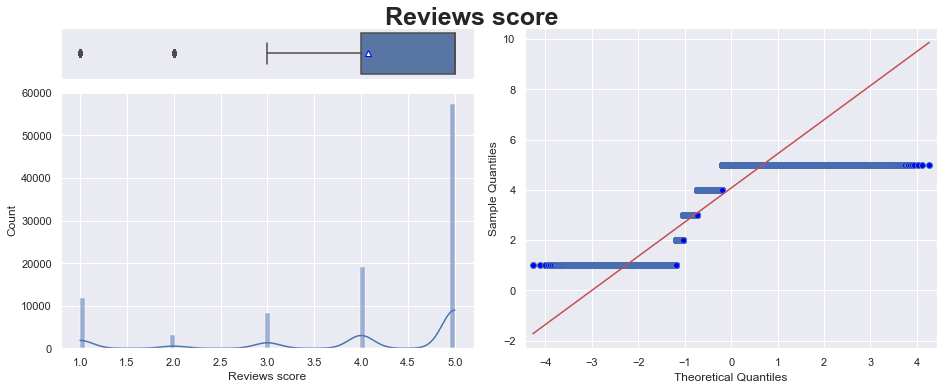


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,review_score,Shapiro-Wilk,"Statistics=0.693, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,review_score,D’Agostino’s K^2,"Statistics=18404.242, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,review_score,Kolmogorov-Smirnov,"Statistics=0.859, p-value=0.000",Sample does not look Gaussian (reject H₀)


In [33]:
fig = plt.figure(constrained_layout=True, figsize=[13,5])
fig.suptitle("Reviews score", size=25, fontweight="bold", y=1.05)
spec = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[1, 1], height_ratios=[1, 5])

ax_box = fig.add_subplot(spec[0, 0])
ax_hist = fig.add_subplot(spec[1, 0])
ax_qqplot = fig.add_subplot(spec[:, 1])

# Boxplot
boxplot = sns.boxplot(data=df_order_reviews, x=df_order_reviews["review_score"], showmeans=True, ax=ax_box,
                      meanprops={"markerfacecolor":"white", "markeredgecolor":"blue"})
ax_box.set(xlabel="", xticks=[])
ax_box.set(yticks=[])
boxplot.set_title("")

# Histplot
sns.histplot(data=df_order_reviews, x=df_order_reviews["review_score"], bins=75,  kde=True,  ax=ax_hist)
ax_hist.set(xlabel="Reviews score")

# QQplot
qqplot(df_order_reviews["review_score"], line='s', ax=ax_qqplot)

plt.savefig("images/qqplot-of-orders-reviews.png")
plt.show()

print("\nMaking the Normality Test")
print("---------------------------------")
normality_test(df_order_reviews[["review_score"]])
print("\n")

In [34]:
data_piechart = df_order_reviews["review_score"].sort_values(ascending=False).value_counts().values
labels_piechart = df_order_reviews["review_score"].sort_values(ascending=False).value_counts().index.tolist()
textprops = dict(size=16, color="gray")
colors = ["#5975A4", "#CC8963", "#5F9E6E", "#AD5B5E", "#857AAB"]
explode = (0, 0, 0, 0, 0)

In [35]:
labels_piechart = ["Five", "Four", "Three", "Two", "One"]

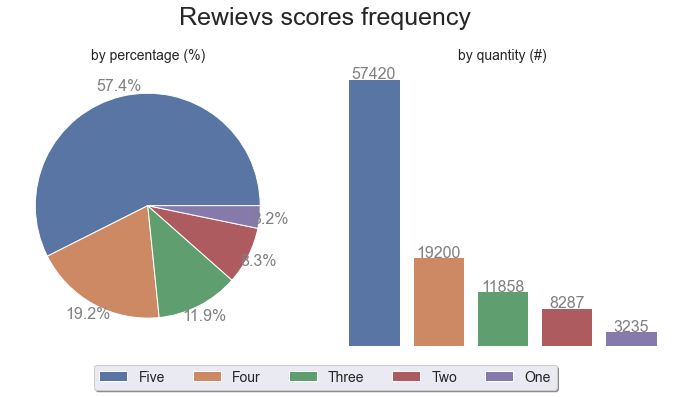

In [36]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[10,5])

fig.suptitle("Rewievs scores frequency", size=25)

for lb, data, color in zip(labels_piechart, data_piechart, colors):
    ax2.bar(lb, data, label=lb, color=color)
for index, data in enumerate(data_piechart):
    plt.text(x=index, y=data+1 , s=f"{data}", horizontalalignment="center", fontdict=dict(fontsize=16, color="gray"))
ax2.set_title("by quantity (#)", fontsize=14)
ax2.axis('off')

ax1.pie(x=data_piechart, explode=explode, autopct="%1.1f%%", pctdistance=1.10, 
        textprops=textprops, colors=[color for color in colors], startangle=0)
ax1.set_title("by percentage (%)", fontsize=14)

fig.legend(labels_piechart, loc="center", ncol=5, fontsize=14, bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("images/Orders-reviews.png")
plt.show()

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Dataset with order reviews. It seems there are reviews repeated for differentes orders</p>
    <ul>
        <li>There is not a pk</li>
        <li>There are missing-values</li>
    </ul>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.3.2. Orders Items</h4>
</div>

In [37]:
df_analysis(df_order_items, "df_order_items", columns=["order_id", "order_item_id"],  type_analysis="complete")


Analysis of df_order_items dataset
--------------------------------------------------------------------
- Dataset shape:                  112650 rows and 7 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['order_id', 'order_item_id'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns      ( memory usage: 6.0+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,order_id,object,112650,98666,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,order_item_id,int64,112650,21,0,0.00000,1.19783,1.00000,1.00000,1.00000,1.00000,21.00000,0.70512
2,product_id,object,112650,32951,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,seller_id,object,112650,3095,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,shipping_limit_date,object,112650,93318,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,price,float64,112650,5968,0,0.00000,120.65374,0.85000,39.90000,74.99000,134.90000,6735.00000,183.63393
6,freight_value,float64,112650,6999,0,0.00000,19.99032,0.00000,13.08000,16.26000,21.15000,409.68000,15.80641


In [38]:
df_order_items.sort_values("order_id").head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [39]:
df_order_items[df_order_items["order_id"] == "00143d0f86d6fbd9f9b38ab440ac16f5"]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1


<div class="alert alert-block alert-info">
    <p>Analyzing the <b>prices</b></p>
</div>

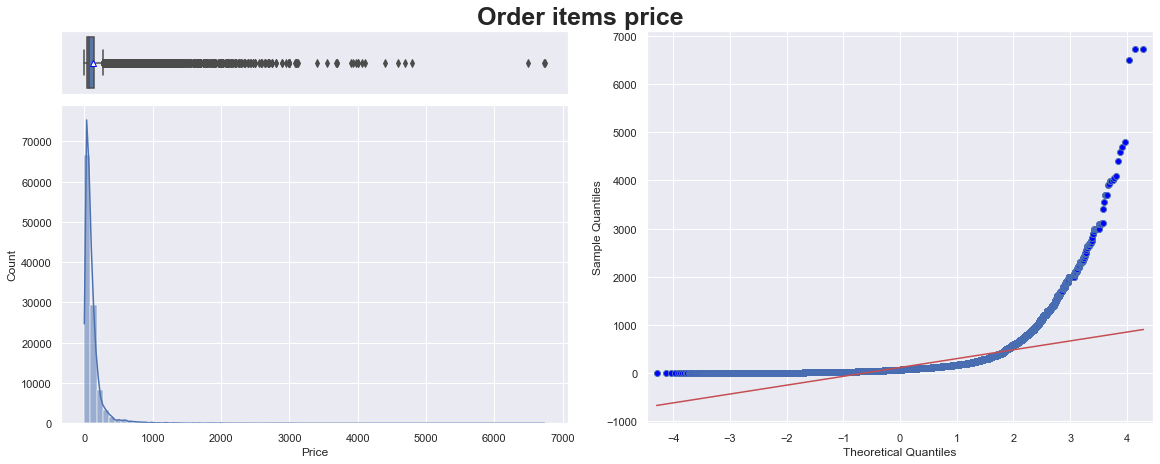


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,price,Shapiro-Wilk,"Statistics=0.460, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,price,D’Agostino’s K^2,"Statistics=155820.644, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,price,Kolmogorov-Smirnov,"Statistics=1.000, p-value=0.000",Sample does not look Gaussian (reject H₀)


In [40]:
fig = plt.figure(constrained_layout=True, figsize=[16,6])
fig.suptitle("Order items price", size=25, fontweight="bold", y=1.05)
spec = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[1, 1], height_ratios=[1, 5])

ax_box = fig.add_subplot(spec[0, 0])
ax_hist = fig.add_subplot(spec[1, 0])
ax_qqplot = fig.add_subplot(spec[:, 1])

# Boxplot
boxplot = sns.boxplot(data=df_order_items, x=df_order_items["price"], showmeans=True, ax=ax_box,
                      meanprops={"markerfacecolor":"white", "markeredgecolor":"blue"})
ax_box.set(xlabel="", xticks=[])
ax_box.set(yticks=[])
boxplot.set_title("")

# Histplot
sns.histplot(data=df_order_items, x=df_order_items["price"], bins=75,  kde=True,  ax=ax_hist)
ax_hist.set(xlabel="Price")

# QQplot
qqplot(df_order_items["price"], line='s', ax=ax_qqplot)

# plt.savefig("images/qqplot-of-payment-values.png")
plt.show()

print("\nMaking the Normality Test")
print("---------------------------------")
normality_test(df_order_items[["price"]])
print("\n")

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Dataset with order products </p>
    <ul>
        <li>order_id together with order_item_id, can be used as pk.<br> It is necessary to consider that a customer can buy the same product several times in the same order</li>
        <li>There are not missing-values</li>
    </ul>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.4. Geolocation</h3>
</div>

In [41]:
df_analysis(df_geolocations, "df_geolocations", columns=["geolocation_zip_code_prefix", "geolocation_city", "geolocation_state"], type_analysis="complete")


Analysis of df_geolocations dataset
--------------------------------------------------------------------
- Dataset shape:                  1000163 rows and 5 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  261831
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state'] is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns      ( memory usage: 38.2+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,geolocation_zip_code_prefix,int64,1000163,19015,0,0.00000,36574.16647,1001.00000,11075.00000,26530.00000,63504.00000,99990.00000,30549.33571
1,geolocation_lat,float64,1000163,717360,0,0.00000,-21.17615,-36.60537,-23.60355,-22.91938,-19.97962,45.06593,5.71587
2,geolocation_lng,float64,1000163,717613,0,0.00000,-46.39054,-101.46677,-48.57317,-46.63788,-43.76771,121.10539,4.26975
3,geolocation_city,object,1000163,8011,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,geolocation_state,object,1000163,27,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
df_geolocations.sort_values("geolocation_zip_code_prefix").head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
1246,1001,-23.549292,-46.633559,sao paulo,SP
429,1001,-23.550498,-46.634338,sao paulo,SP
1182,1001,-23.549779,-46.633957,sao paulo,SP
1435,1001,-23.549292,-46.633559,sao paulo,SP
326,1001,-23.551427,-46.634074,sao paulo,SP


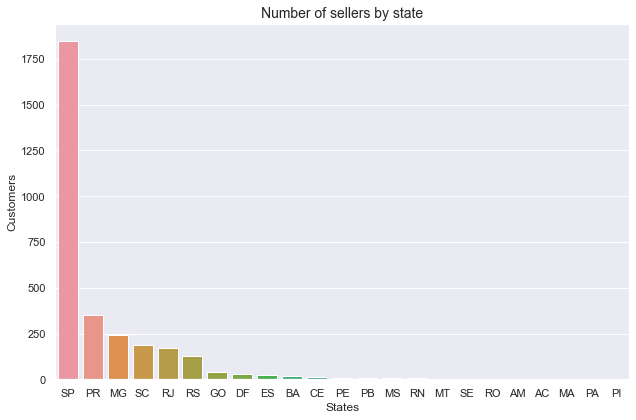

In [43]:
fig = plt.subplots(figsize=(9, 6))
plot = sns.barplot(x=df_sellers["seller_state"].value_counts().index, y=df_sellers["seller_state"].value_counts(), data=df_sellers)
plt.xlabel("States", size=12)
plt.ylabel("Customers", size=12)
plt.title("Number of sellers by state", size=14)
plt.tight_layout()
plt.savefig("images/number-of-sellers-by-state.png")
plt.show()

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Dataset with geolocation data. There is not a clear relation among this dataset and Customers and Sellers dataset.<br>It is possible to consider only the city, state and zip code</p>
    <ul>
        <li>There is not a pk</li>
        <li>There are missing-values</li>
    </ul>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.5. Sellers</h3>
</div>

In [ ]:
df_analysis(df_sellers, "df_sellers", columns=["seller_id"], type_analysis="complete")

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">4. Merging datasets and Features Selection</h2>
</div>

<div class="alert alert-block alert-success">
    <p>Based on the <b>mission</b> and the data that we have so now, we can consider the followings segmentations</p>
    <ul style="list-style-type: disc;">
       <li><b>Behavioral segmentation</b> Based on consumers’ behaviors, especially Olist's products.</li>
       <li><b>Value segmentation</b>:  How much customers spend on Olist's products.</li>
    </ul>    
</div>

<div class="alert alert-block alert-info">
    <p>Below, we can see the meaning of each feature</p>
    <ul style="list-style-type: square;">
        <li><b>Orders</b> (df_orders)</li>
        <ul style="list-style-type: disc;">
           <li><b>order_id :</b> unique identifier of the order.</li>
           <li><b>customer_id :</b> key to the customer dataset. Each order has a unique customer_id.</li>
           <li><b>order_status :</b> Reference to the order status (delivered, shipped, etc).</li>
           <li><b>order_purchase_timestamp :</b> Shows the purchase timestamp.</li>
        </ul>
        <li><b>Order Reviews</b> (df_order_reviews)</li>
        <ul style="list-style-type: disc;">
           <li><b>order_id :</b> unique identifier of the order.</li>
           <li><b>review_score :</b> Note ranging from 1 to 5 given by the customer on a satisfaction survey.</li>
        </ul>
        <li><b>Customers</b> (df_customers)</li>
        <ul style="list-style-type: disc;">
           <li><b>customer_id :</b> key to the orders dataset. Each order has a unique customer_id.</li>
           <li><b>customer_unique_id :</b> unique identifier of a customer.</li>
           <li><b>customer_city :</b> customer city name.</li>
           <li><b>customer_state :</b> customer state.</li>
           <li><b>customer_region :</b> customer region.</li>
        </ul>   
        <li><b>Products</b> (df_products)</li>
        <ul style="list-style-type: disc;">
           <li><b>product_id :</b> unique product identifier.</li>
           <li><b>product_category_name_english :</b> root category of product, in English.</li>
           <li>The following features will be used to treat missing-values in <b>payment_values</b>.</li>
           <ul style="list-style-type: square;"> 
               <li><b>product_length_cm :</b> product length measured in centimeters.</li>
               <li><b>product_weight_g :</b> product weight measured in grams.</li>
               <li><b>product_height_cm :</b> product height measured in centimeters.</li>
               <li><b>product_width_cm :</b> product width measured in centimeters.</li>
           </ul>
        </ul>
        <li><b>Order Items</b> (df_order_items)</li>
        <ul style="list-style-type: disc;">
           <li><b>order_id :</b> unique identifier of the order.</li>            
           <li><b>product_id :</b> unique product identifier.</li>
           <li><b>price :</b> item price.</li>
           <li><b>freight_value :</b> item freight value item (if an order has more than one item the freight value is splitted between items).</li>            
        </ul>        
    </ul>
    
    <p>Finally, we have one more dataset used to complete information in other datasets</p>
    
     <ul style="list-style-type: square;">
         
        <li><b>Product category translation</b> (df_product_category_name_translations) Translates the productcategoryname to english..</li>
    </ul>  
    
    <p>On the others hands, we have the following dataset that we are not going to use</p>
    
     <ul style="list-style-type: square;">
         <li><b>Sellers</b> (df_sellers) is <b>not interesting</b> for the mission</li>
        <li><b>Order payments</b> (Order_payments) has information about the total value purchased and its methods of payments.</li>
        <ul style="list-style-type: disc;">
           <li><b>payment_type :</b> Method of payment chosen by the customer. <b>Not interesting</b> for the mission.</li>
           <li><b>payment_value :</b> Transaction value. We can get the same value through the sum of <b>price</b> and <b>freight_value</b> based on the <b>Order</b>.</li>
           <li><b>Geolocation</b> (df_geolocations) This dataset has information Brazilian zip codes and its lat/lng coordinates.</li>
        </ul>
    </ul>
  
</div>

![Entity relationship diagram](images/initial/datasets_to_work.png)

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4.1. Orders</h3>
</div>

In [ ]:
data = df_orders[["order_id", "customer_id", "order_status", "order_purchase_timestamp"]].copy()

In [ ]:
df_analysis(data, "data", type_analysis="complete")

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4.2. Reviews</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Veriying duplicates in <b>Reviews</b> before merging with <b>Orders</b></p>
</div>

In [ ]:
df_order_reviews.head()

In [ ]:
df_order_reviews["duplicated"] = df_order_reviews.duplicated(["order_id"], keep=False)
df_order_reviews[df_order_reviews["duplicated"] == True].count()

In [ ]:
pd.set_option("display.max_rows", None) # show full of showing rows
pd.set_option("display.max_columns", None) # show full of showing cols
pd.set_option("display.max_colwidth", None) # show full width of showing cols
pd.set_option("display.float_format", lambda x: "%.5f" % x) # show full content in cell    

In [ ]:
df_order_reviews[df_order_reviews["duplicated"] == True].sort_values(["order_id"]).head(10)

In [ ]:
pd.reset_option("display.max_rows") # reset max of showing rows
pd.reset_option("display.max_columns") # reset max of showing cols
pd.reset_option("display.max_colwidth") # reset width of showing cols
pd.reset_option("display.float_format") # reset show full content in cell

<div class="alert alert-block alert-warning">
    <p>There are <b>more than one review</b> by <b>Order</b></p>
    <p>In these cases, we are going to use the <b>review score average</b> to delete duplicates <b>Orders reviews</b></p>
</div>

In [ ]:
df_temp_order_reviews = df_order_reviews[df_order_reviews["duplicated"] == True].sort_values(["order_id"]).reset_index()
df_temp_order_reviews.shape

In [ ]:
df_temp_order_reviews = df_temp_order_reviews[["order_id", "review_score"]]
df_temp_order_reviews.head()

<div class="alert alert-block alert-info">
    <p>Calculating the <b>review score average</b> in duplicates</p>
</div>

In [ ]:
df_temp_order_reviews_avg = df_temp_order_reviews.groupby(["order_id"]).mean()
df_temp_order_reviews_avg.head()

In [ ]:
df_temp_order_reviews_avg = df_temp_order_reviews_avg.reset_index()
df_temp_order_reviews_avg.head()

<div class="alert alert-block alert-info">
    <p><b>Deleting</b> the <b>review score</b> duplicated to add the <b>review score average</b> </p>
</div>

In [ ]:
df_order_reviews.drop(df_order_reviews.index[df_order_reviews["duplicated"] == True], inplace=True)

In [ ]:
df_order_reviews[df_order_reviews["duplicated"] == True].sort_values(["order_id"]).head(10)

In [ ]:
df_temp_order_reviews = df_order_reviews[["order_id", "review_score"]]
df_temp_order_reviews.head()

<div class="alert alert-block alert-info">
    <p><b>Concatenating</b> the <b>review score average</b> </p>
</div>

In [ ]:
df_temp_order_reviews = pd.concat([df_temp_order_reviews, df_temp_order_reviews_avg], ignore_index=True)

<div class="alert alert-block alert-info">
    <p>Merging <b>Reviews</b> with <b>Orders</b></p>
</div>

In [ ]:
data = data.merge(right=df_temp_order_reviews[["order_id", "review_score"]], on="order_id", how="left")

In [ ]:
data.head()

In [ ]:
df_analysis(data, "data", type_analysis="complete")

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4.3. Customer and Geolocations</h3>
</div>

<div class="alert alert-block alert-info">
    <p>We are only going to keep one geolocation for each zip code to mix them with customers</p>
    <p>At the same time, we are going to add the fiel <b>Region</b> into Geolocations dataset</p>
</div>

In [ ]:
df_geolocations.drop_duplicates(subset=["geolocation_zip_code_prefix"], keep="first", inplace=True)

In [ ]:
df_geolocations = df_geolocations.merge(right=df_brasil_regions[["region", "state_acronym"]], right_on="state_acronym", left_on="geolocation_state", how="left")

In [ ]:
df_geolocations["geolocation_region"] = df_geolocations["region"]
df_geolocations.drop(columns=["region", "state_acronym"], axis=1, inplace=True)

In [ ]:
df_analysis(df_geolocations, "df_geolocations", type_analysis="complete")

In [ ]:
df_geolocations.head()

<div class="alert alert-block alert-info">
    <p>Merging <b>Geolocation</b> with <b>Customers</b></p>
    <p>First of all, we are going to verify that all Zip Codes in <b>Customers</b> are in <b>Geolocation</b></p>
</div>

In [ ]:
df_customers["zip_code_in_geolocation"] = df_customers["customer_zip_code_prefix"].isin(df_geolocations["geolocation_zip_code_prefix"])
df_customers[df_customers["zip_code_in_geolocation"] == False]

<div class="alert alert-block alert-warning">
    <p>Not all Zip Codes in <b>Customers</b> are in <b>Geolocation</b></p>
    <p>Due to that, we are going to add the Region through the state</p>
</div>

In [ ]:
df_temp_geolocations = df_geolocations[["geolocation_state", "geolocation_region"]].copy()

In [ ]:
df_temp_geolocations.drop_duplicates(subset=["geolocation_state"], keep="first", inplace=True)

In [ ]:
df_temp_geolocations["geolocation_state"].unique()

In [ ]:
df_analysis(df_temp_geolocations, "df_temp_geolocations", type_analysis="complete")

In [ ]:
df_temp_customers = df_customers.merge(right=df_temp_geolocations[["geolocation_state", "geolocation_region"]], 
                                      right_on="geolocation_state", left_on="customer_state", how="left")

df_temp_customers["customer_region"] = df_temp_customers["geolocation_region"]

df_temp_customers.drop(columns=["geolocation_state", "geolocation_region", "zip_code_in_geolocation"], axis=1, inplace=True)

In [ ]:
df_analysis(df_temp_customers, "df_temp_customers", columns=["customer_unique_id"], type_analysis="complete")

<div class="alert alert-block alert-info">
    <p>Merging <b>Customers</b> with <b>Orders</b></p>
</div>

In [ ]:
data = data.merge(right=df_temp_customers[["customer_id", "customer_unique_id", "customer_city", "customer_state", "customer_region"]], on="customer_id", how="left")

In [ ]:
data.head()

In [ ]:
df_analysis(data, "data", type_analysis="complete")

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4.4. Products and Orders items</h3>
</div>

<div class="alert alert-block alert-info">
    <p>We are going to merge the products datasets with products translations dataset</p>
</div>

In [ ]:
df_product_category_name_translations.head()

In [ ]:
df_products = df_products.merge(right=df_product_category_name_translations[["product_category_name", "product_category_name_english"]], on="product_category_name", how="left")

In [ ]:
df_products.head()

In [ ]:
print("Number of \"products categories\" to complete with \"products categories translated\" is:",
        df_products[(df_products["product_category_name"].isna()) & (df_products["product_category_name_english"].notnull())].shape[0]
)

In [ ]:
print("Number of \"products categories translated\" to complete with \"products categories\" is:",
        df_products[(df_products["product_category_name_english"].isna()) & (df_products["product_category_name"].notnull())].shape[0]
)

<div class="alert alert-block alert-info">
    <p>Fill products categories translated with the original name of category</p>
</div>

In [ ]:
df_products["product_category_name_english"].fillna(df_products["product_category_name"], inplace=True)

In [ ]:
print("Number of \"products categories translated\" to complete with \"products categories\" is:",
        df_products[(df_products["product_category_name_english"].isna()) & (df_products["product_category_name"].notnull())].shape[0]
)

In [ ]:
del df_products["product_category_name"]

<div class="alert alert-block alert-info">
    <p>Merging <b>Products</b> with <b>Orders items</b></p>
</div>

In [ ]:
df_temp_order_items = df_order_items.merge(right=df_products[["product_id", "product_category_name_english", "product_weight_g",
                                                              "product_length_cm", "product_height_cm", "product_width_cm"]], on="product_id", how="left")

In [ ]:
df_temp_order_items.head()

<div class="alert alert-block alert-info">
    <p>Consolidating <b>price</b> with <b>freight_value</b></p>
    <p>Later, we check whether these consolidation is consisten</p>
    
</div>

In [ ]:
df_temp_order_items["price_plus_freight_value"] = df_temp_order_items["price"] + df_temp_order_items["freight_value"] 

In [ ]:
df_temp_order_items.head()

<div class="alert alert-block alert-info">
    <p>Merging <b>Orders items</b> with <b>Orders</b></p>
</div>

In [ ]:
data.shape

In [ ]:
data = data.merge(right=df_temp_order_items[["order_id", "price_plus_freight_value", "product_category_name_english", "product_weight_g",
                                                              "product_length_cm", "product_height_cm", "product_width_cm"]], on="order_id", how="left")

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">4.4.1. Checking coherence of the payment_value</h4>
</div>

<div class="alert alert-block alert-info">
    <p>We are going to check whether <b>price</b> plus <b>freight_value</b> are coherence with <b>payment_value</b></p>
    <p>To do that, we are going to select an order greater than 1 and less than 5 products to compare the values</p>
</div>

In [ ]:
df_temp_order_items.loc[(df_temp_order_items["order_item_id"] > 1) & (df_temp_order_items["order_item_id"] < 5)].sort_values(["order_item_id"], ascending=False).head(3)

In [ ]:
df_temp_order_items[df_temp_order_items["order_id"]=="fffb9224b6fc7c43ebb0904318b10b5f"]

<div class="alert alert-block alert-info">
    <p>If we do the calculation of <b>price</b> + <b>freight_value</b>, we get a total result of 356.76</p>
    <p>Let's look the same order in <b>df_order_payments</b></p>
</div>

In [ ]:
df_order_payments[df_order_payments["order_id"]=="fffb9224b6fc7c43ebb0904318b10b5f"]

<div class="alert alert-block alert-success">
    <p>Now, we know that we can get the same value</p>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4.5. Analyzing the resulting dataset</h3>
</div>

In [ ]:
df_analysis(data, "data", type_analysis="complete")

<div class="alert alert-block alert-info">
    <p>At this point, we can delete <b>customer_id</b> because we have all information together so, we can identify whether an order is a different purchase</p>
</div>

In [ ]:
del data["customer_id"]

<div class="alert alert-block alert-info">
    <p>Now, we are going to reorganize the columns and rows</p>
</div>

In [ ]:
data.rename(columns={"price_plus_freight_value":"payment_value", "product_category_name_english":"product_category"}, inplace=True)

In [ ]:
ORDERED_COLUMNS = [
    "order_id", "customer_unique_id", "order_status", "order_purchase_timestamp", "review_score", 
    "payment_value", "product_category", "product_weight_g", "product_length_cm", "product_height_cm", 
    "product_width_cm", "customer_city", "customer_state", "customer_region"
]

In [ ]:
data = data[ORDERED_COLUMNS]
data = data.sort_values(["order_purchase_timestamp", "order_id", "customer_unique_id"], ascending=False)

In [ ]:
data.head()

In [ ]:
df_analysis(data, "data", type_analysis="complete")

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>We got a dataset with details about orders, items in order, customer, total value among other data.</p>
    <ul>
        <li><b>order_id :</b> unique identifier of the order.</li>
        <li><b>customer_id :</b> key to the customer dataset. Each order has a unique customer_id.</li>
        <li><b>order_status :</b> Reference to the order status (delivered, shipped, etc).</li>
        <li><b>order_purchase_timestamp :</b> Shows the purchase timestamp.</li>
        <li><b>review_score :</b> Note ranging from 1 to 5 given by the customer on a satisfaction survey.</li>
        <li><b>customer_city :</b> customer city name.</li>
        <li><b>customer_state :</b> customer state.</li>
        <li><b>customer_region :</b> customer region.</li>
        <li><b>payment_value :</b> item price + item freight value item (if an order has more than one item the freight value is splitted between items).</li>
        <li><b>product_category :</b> root category of product, in English.</li>
        <li><b>product_length_cm :</b> product length measured in centimeters.</li>
        <li><b>product_weight_g :</b> product weight measured in grams.</li>
        <li><b>product_height_cm :</b> product height measured in centimeters.</li>
        <li><b>product_width_cm :</b> product width measured in centimeters.</li>
    </ul>
    <p>In the dataset are as many rows as items by orders</p>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">4.5.1. Fixing time columns</h4>
</div>

<div class="alert alert-block alert-info">
    <p>Based on the analysis, we can identify that the feature <b>order_purchase_timestamp</b> doesn't have the right type</p>
</div>

In [ ]:
data["order_purchase_timestamp"] = data["order_purchase_timestamp"].astype("datetime64")

<div class="alert alert-block alert-info">
    <p>As well, based on the analysis, we can identify the following categorical columns that doesn't have the right type</p>
</div>

In [ ]:
CATEGORICAL_COLUMNS = [
    "order_status", "product_category", "customer_city", "customer_state", "customer_region"
]

In [ ]:
for col in CATEGORICAL_COLUMNS:
    data[col] = data[col].astype("category")

<div class="alert alert-block alert-info">
    <p>Analyzing the resulting dataset</p>
</div>

In [ ]:
df_analysis(data, "data", type_analysis="complete")

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">5. Treating Outliers</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.1. Analyzing Order status</h3>
</div>

In [ ]:
data["order_status"].unique()

In [ ]:
data["payment_value"].isnull().groupby(data["order_status"]).sum().astype(int).reset_index(name='count').sort_values("count", ascending=False)

In [ ]:
data["product_category"].isnull().groupby(data["order_status"]).sum().astype(int).reset_index(name='count').sort_values("count", ascending=False)

<div class="alert alert-block alert-success">
    <p>For the momento, we are not going to treat <b>order_status</b> outliers</p>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.2. Analyzing Order purchase time</h3>
</div>

In [109]:
data["order_purchase_timestamp"].max()

Timestamp('2018-10-17 17:30:18')

In [110]:
data["order_purchase_timestamp"].min()

Timestamp('2016-09-04 21:15:19')

<div class="alert alert-block alert-success">
    <p><b>order_purchase_timestamp</b> seems coherent</p>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.4. Treating outliers in numeric features with Z-Score</h3>
</div>

In [111]:
NUMERIC_COLS = [
    "payment_value", "product_length_cm", "product_weight_g", "product_height_cm", "product_width_cm"
]

data_outliers = pd.DataFrame()

In [112]:
flag = True

for product_category in data["product_category"].unique():
    
    if flag:
        df_temp_outliers = data[data["product_category"].isnull()].copy()
        flag = False
    else:
        # for each property type, we are going to define the max and min threshold to replace outliers
        df_temp_outliers  = data[data["product_category"] == product_category].copy()

        for col in NUMERIC_COLS:

            # Defining the Z Score
            df_temp_outliers[col + "_zscore"] = (df_temp_outliers[col] - df_temp_outliers[col].mean()) / df_temp_outliers[col].std()
            df_temp_outliers.loc[(df_temp_outliers[col + "_zscore"] > 3) | (df_temp_outliers[col + "_zscore"] < -3), col] = np.nan

            del df_temp_outliers[col + "_zscore"]
        
    data_outliers = pd.concat([data_outliers, df_temp_outliers])

<div class="alert alert-block alert-info">
     Analyzing the result
</div>

In [113]:
df_analysis(data_outliers, "data_outliers", type_analysis="complete")


Analysis of data_outliers dataset
--------------------------------------------------------------------
- Dataset shape:                  113425 rows and 14 columns
- Total of NaN values:            15616
- Percentage of NaN:              0.98 %
- Total of full duplicates rows:  10454
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 9.5+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,order_id,object,113425,99441,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,customer_unique_id,object,113425,96096,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,order_status,category,113425,8,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,order_purchase_timestamp,datetime64[ns],113425,98875,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,review_score,float64,113425,11,0,0.00000,4.00035,1.00000,3.00000,5.00000,5.00000,5.00000,1.41067
11,customer_city,category,113425,4119,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,customer_state,category,113425,27,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,customer_region,category,113425,5,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,product_width_cm,float64,111204,79,2221,1.96000,22.56395,6.00000,15.00000,20.00000,30.00000,100.00000,10.90328
9,product_height_cm,float64,111116,93,2309,2.04000,15.98627,2.00000,8.00000,13.00000,20.00000,105.00000,12.22659


<div class="alert alert-block alert-success">
    <p>The missing values increased to 0.98%</p>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">6. Univariate analysis</h2>
</div>

<div class="alert alert-block alert-info">
     <p>Before to make missing-values treating, we are going to analyse normal distribution for each continuos variable</p>
</div>

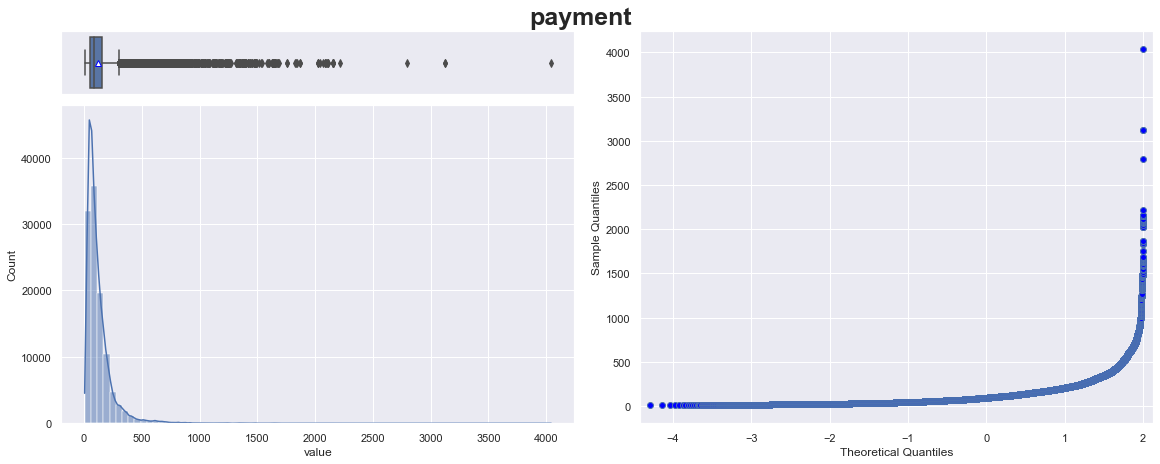


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,payment_value,Shapiro-Wilk,"Statistics=nan, p-value=1.000",Sample looks Gaussian (fail to reject H₀)
1,payment_value,D’Agostino’s K^2,"Statistics=nan, p-value=nan",Sample does not look Gaussian (reject H₀)
2,payment_value,Kolmogorov-Smirnov,"Statistics=nan, p-value=nan",Sample does not look Gaussian (reject H₀)


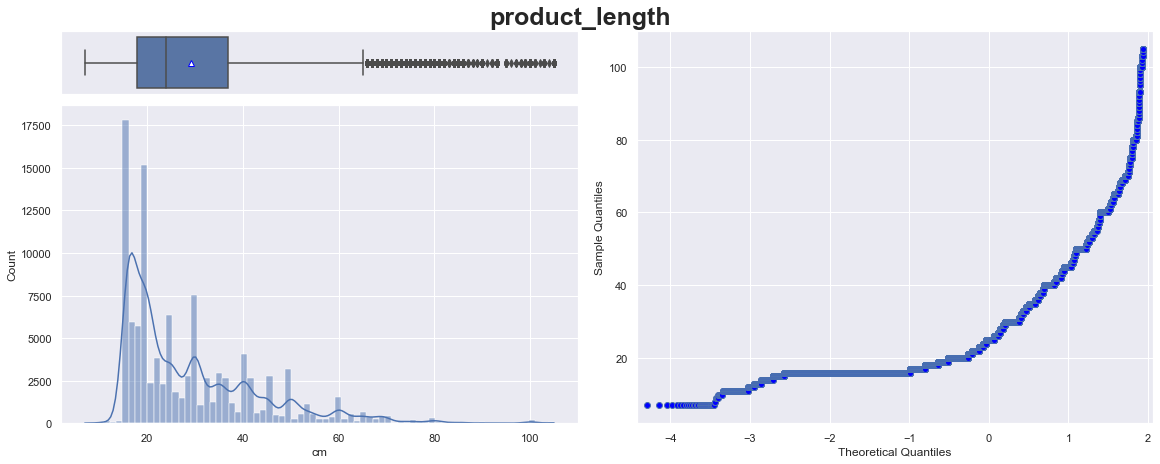


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,product_length_cm,Shapiro-Wilk,"Statistics=nan, p-value=1.000",Sample looks Gaussian (fail to reject H₀)
1,product_length_cm,D’Agostino’s K^2,"Statistics=nan, p-value=nan",Sample does not look Gaussian (reject H₀)
2,product_length_cm,Kolmogorov-Smirnov,"Statistics=nan, p-value=nan",Sample does not look Gaussian (reject H₀)


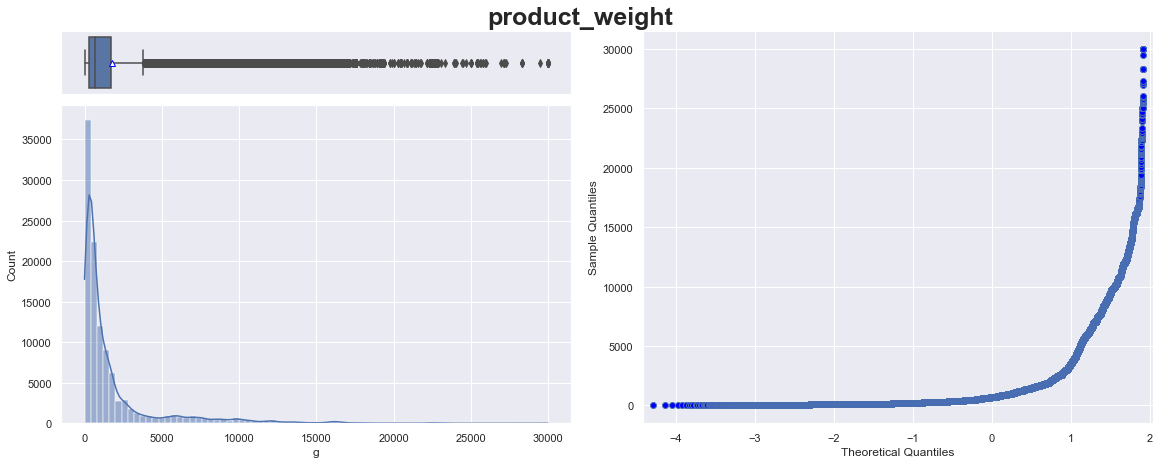


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,product_weight_g,Shapiro-Wilk,"Statistics=nan, p-value=1.000",Sample looks Gaussian (fail to reject H₀)
1,product_weight_g,D’Agostino’s K^2,"Statistics=nan, p-value=nan",Sample does not look Gaussian (reject H₀)
2,product_weight_g,Kolmogorov-Smirnov,"Statistics=nan, p-value=nan",Sample does not look Gaussian (reject H₀)


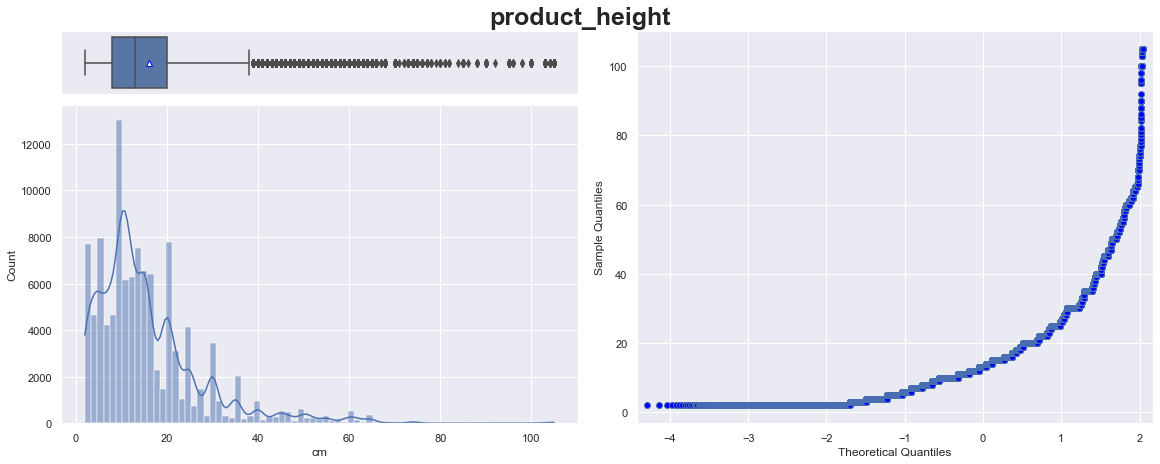


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,product_height_cm,Shapiro-Wilk,"Statistics=nan, p-value=1.000",Sample looks Gaussian (fail to reject H₀)
1,product_height_cm,D’Agostino’s K^2,"Statistics=nan, p-value=nan",Sample does not look Gaussian (reject H₀)
2,product_height_cm,Kolmogorov-Smirnov,"Statistics=nan, p-value=nan",Sample does not look Gaussian (reject H₀)


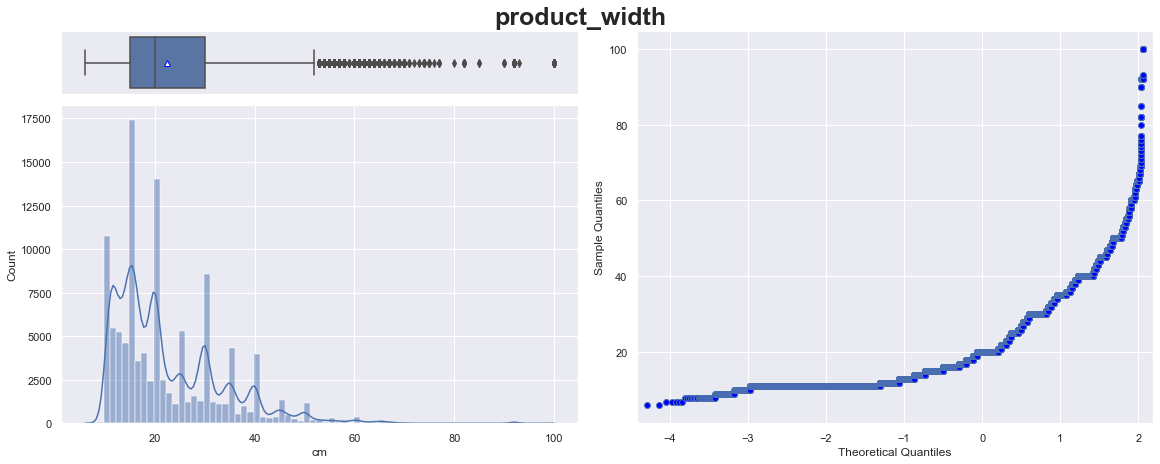


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,product_width_cm,Shapiro-Wilk,"Statistics=nan, p-value=1.000",Sample looks Gaussian (fail to reject H₀)
1,product_width_cm,D’Agostino’s K^2,"Statistics=nan, p-value=nan",Sample does not look Gaussian (reject H₀)
2,product_width_cm,Kolmogorov-Smirnov,"Statistics=nan, p-value=nan",Sample does not look Gaussian (reject H₀)


In [114]:
for col in NUMERIC_COLS:
    
    var = col.rpartition("_")
    
    fig = plt.figure(constrained_layout=True, figsize=[16,6])
    fig.suptitle(var[0], size=25, fontweight="bold", y=1.05)
    spec = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[1, 1], height_ratios=[1, 5])

    ax_box = fig.add_subplot(spec[0, 0])
    ax_hist = fig.add_subplot(spec[1, 0])
    ax_qqplot = fig.add_subplot(spec[:, 1])

    # Boxplot
    boxplot = sns.boxplot(data=data_outliers, x=data_outliers[col], showmeans=True, ax=ax_box,
                          meanprops={"markerfacecolor":"white", "markeredgecolor":"blue"})
    ax_box.set(xlabel="", xticks=[])
    ax_box.set(yticks=[])
    boxplot.set_title("")

    # Histplot
    sns.histplot(data=data_outliers, x=data_outliers[col], bins=75,  kde=True,  ax=ax_hist)
    ax_hist.set(xlabel=var[-1])

    # QQplot
    qqplot(data_outliers[col], line='s', ax=ax_qqplot)

    plt.savefig("images/qqplot-of-" + var[1] + ".png")
    plt.show()

    print("\nMaking the Normality Test")
    print("---------------------------------")
    normality_test(data_outliers[[col]])
    print("\n")

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.1. Continuous Variables Transformation</h3>
</div>
<br>
<div class="alert alert-block alert-info">
     Based on the <b>Univariate analysis</b> where we note that <b>none</b> of the analyzed numeric variables have a <b>Normal distribution</b>
     and <b>all their values are very close</b> so, we are going to apply the <b>Logarithmic transformation</b> in these variables to get a <b>better Normal distribution</b> of these values
</div>

In [115]:
for col in NUMERIC_COLS:
    data_outliers[col + "_log"] = np.log(data_outliers[col] + 1)
    data_outliers[col + "_log2"] = np.log2(data_outliers[col] + 1)
    data_outliers[col + "_log10"] = np.log10(data_outliers[col] + 1)

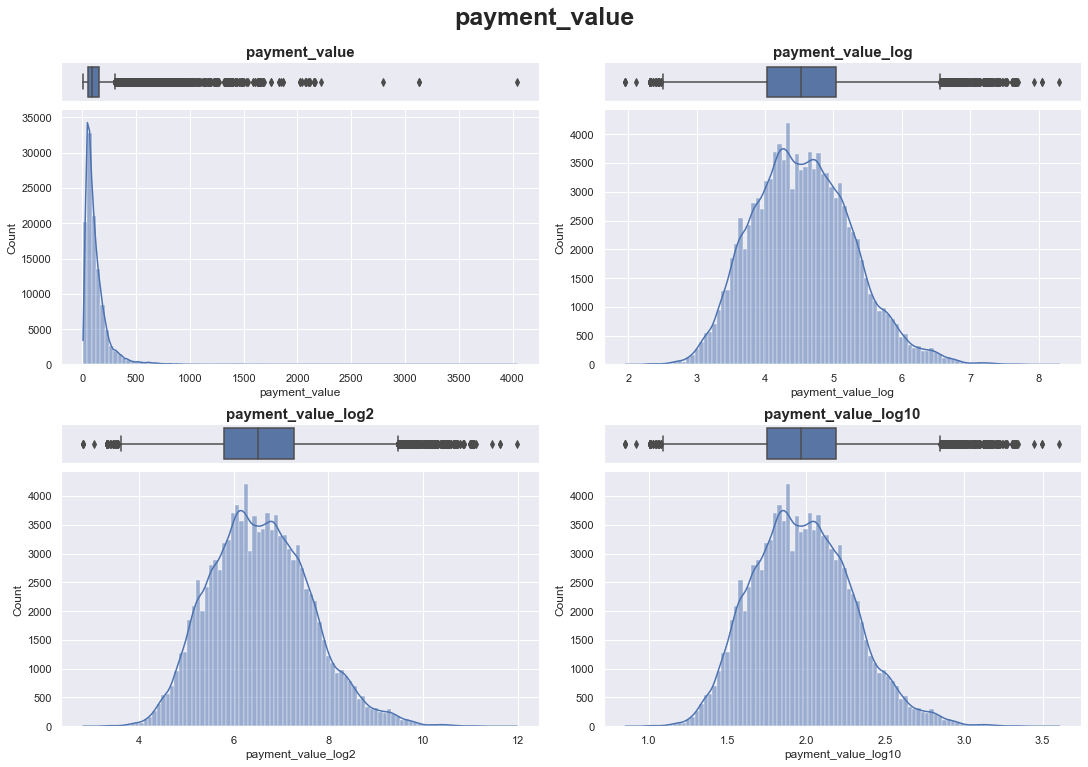


Variance of payment_value
------------------------------------


,variance
payment_value_log,0.534517
payment_value_log2,1.112528
payment_value_log10,0.100816


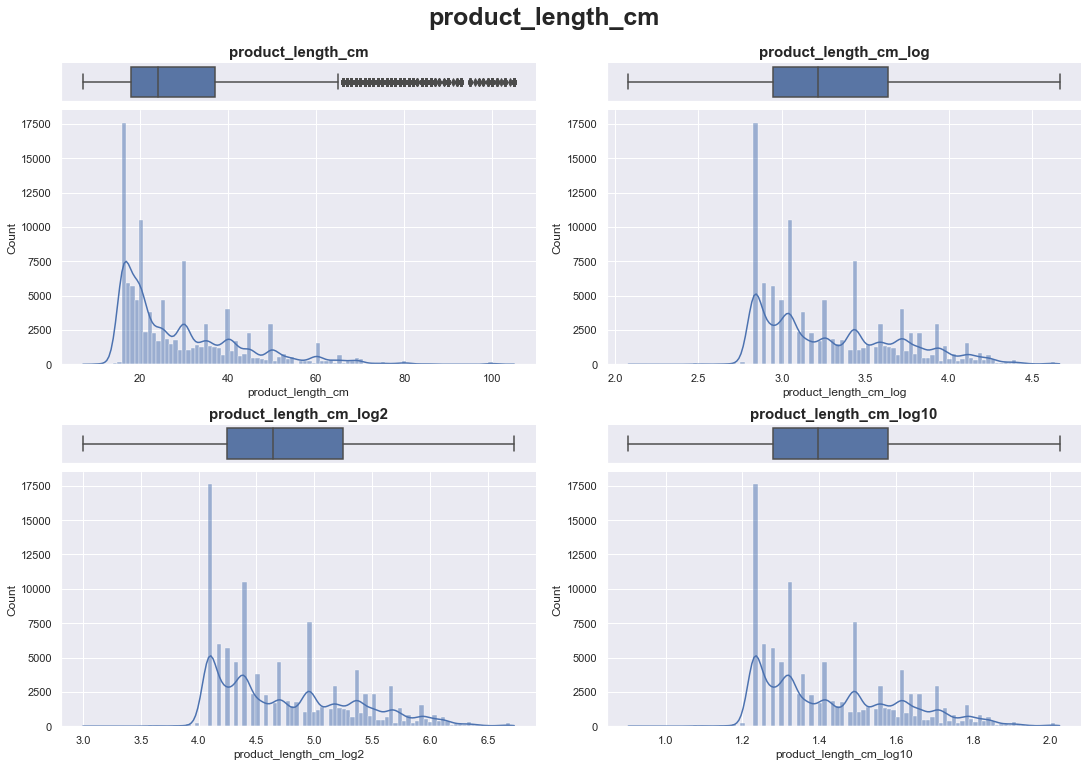


Variance of product_length_cm
------------------------------------


,variance
product_length_cm_log,0.176733
product_length_cm_log2,0.367848
product_length_cm_log10,0.033334


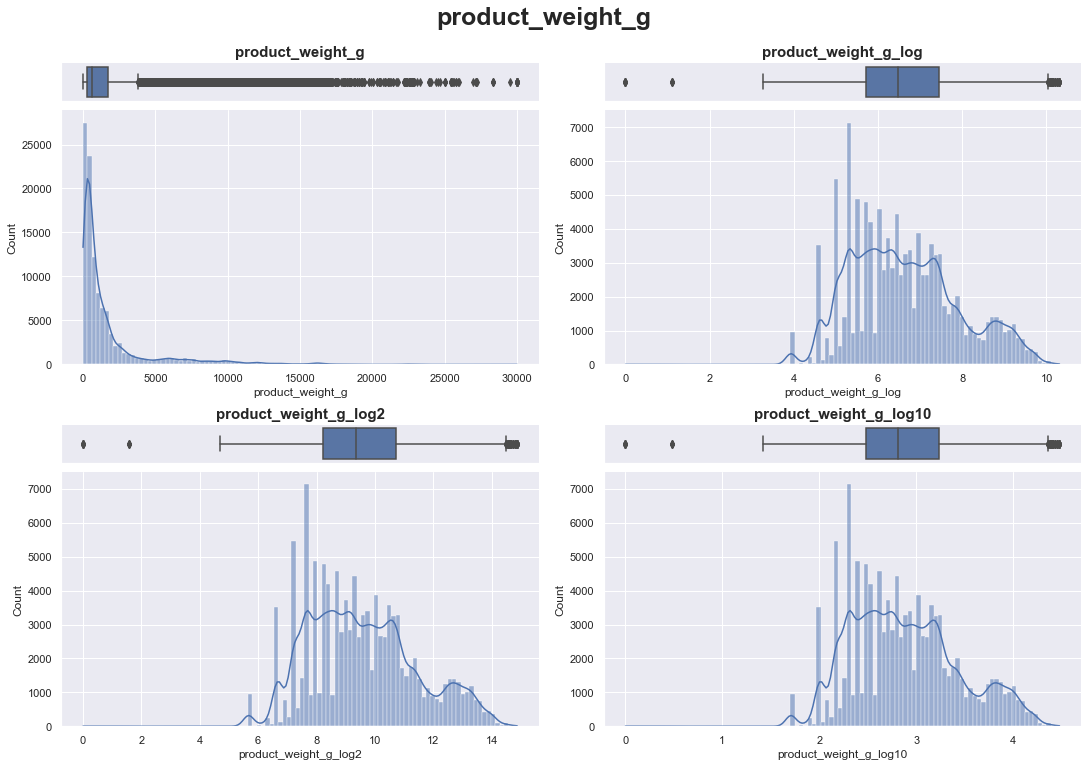


Variance of product_weight_g
------------------------------------


,variance
product_weight_g_log,1.621854
product_weight_g_log2,3.375677
product_weight_g_log10,0.305901


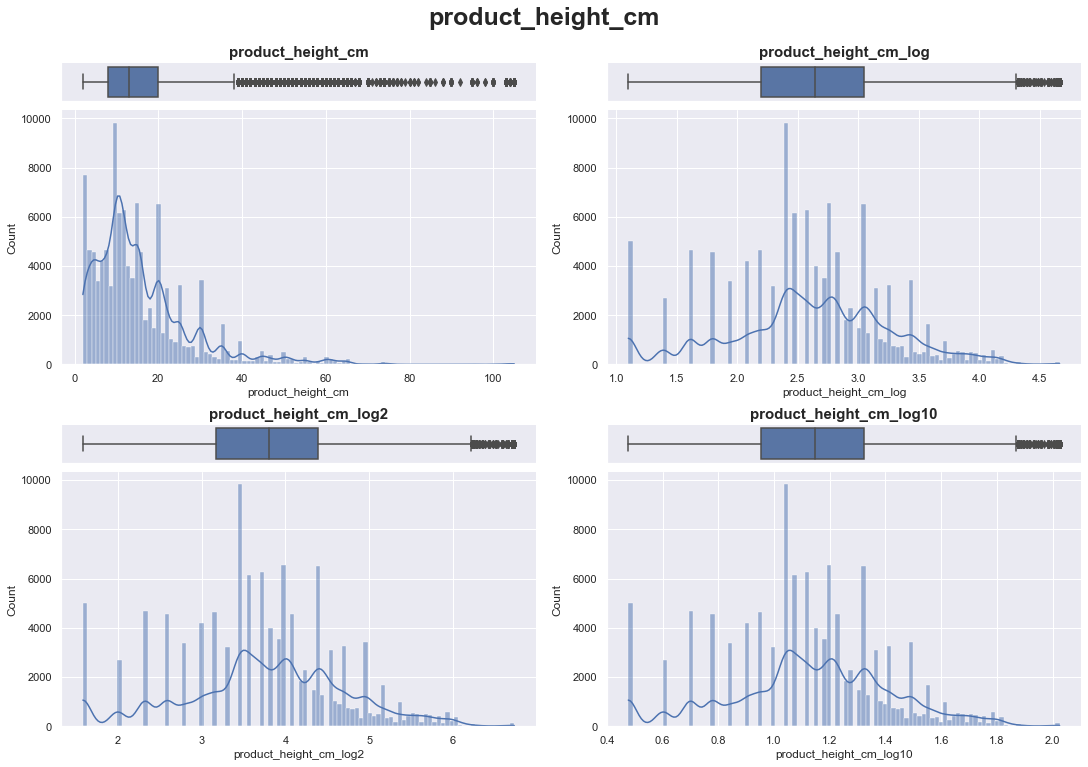


Variance of product_height_cm
------------------------------------


,variance
product_height_cm_log,0.466562
product_height_cm_log2,0.971088
product_height_cm_log10,0.087999


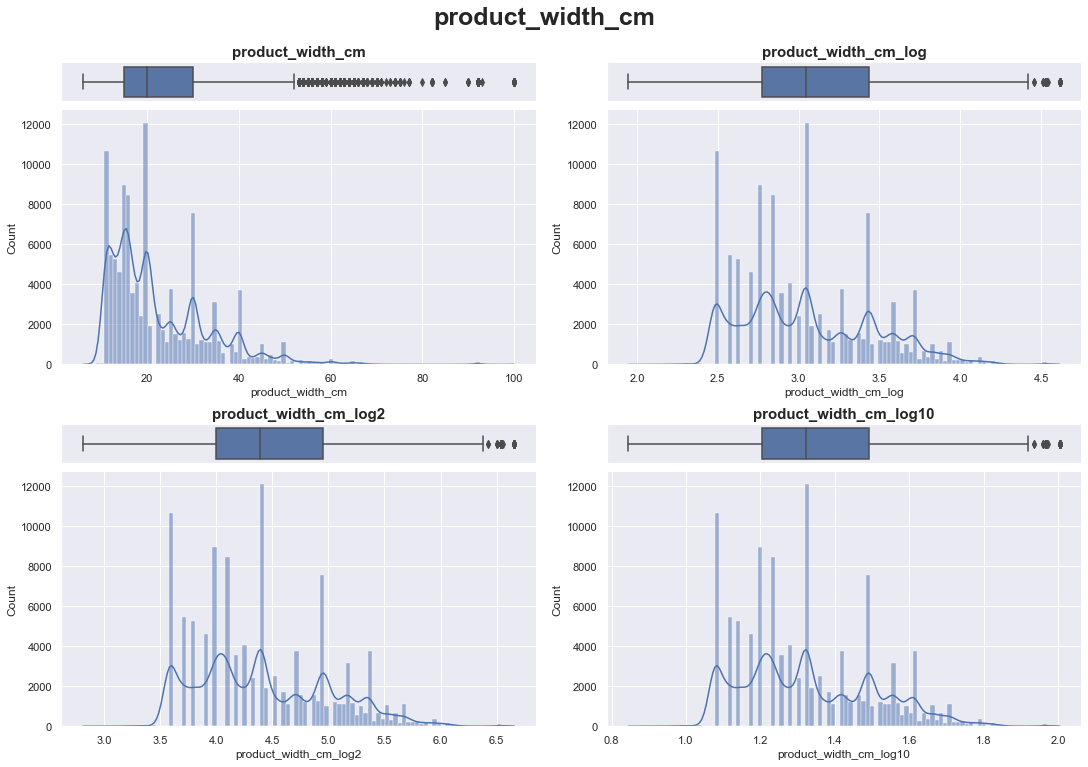


Variance of product_width_cm
------------------------------------


,variance
product_width_cm_log,0.172975
product_width_cm_log2,0.360025
product_width_cm_log10,0.032625


In [116]:
for var in NUMERIC_COLS:
    
    # We are going to work only with the rows without missing-values for the features
    df_subset = pd.DataFrame(data_outliers[data_outliers[[col]].notnull().all(axis=1)]).reset_index(drop=True)
    
    var_cols = [var + "", var + "_log", var + "_log2", var + "_log10"]
    
    fig = plt.figure(constrained_layout=True, figsize=[15,10])
    fig.suptitle(var, size=25, fontweight="bold", y=1.05)
    spec = fig.add_gridspec(ncols=2, nrows=4, width_ratios=[1,1], height_ratios=[0.3,2,0.3,2])
    
    # to cycle through the columns 
    col_boxplot, col_histplot = 0, 0
    
    for i in range(4):
        
        for j in range(2):
            
            if i % 2 == 0:
                
                if col_boxplot > len(var_cols) - 1:
                    break
                    
                ax_box = fig.add_subplot(spec[i, j])
                boxplot = sns.boxplot(data=data_outliers, x=var_cols[col_boxplot], ax=ax_box)
                
                # Remove x axis name for the boxplot
                ax_box.set(xlabel="", xticks=[])
                ax_box.set(yticks=[])
                
                boxplot.set_title(var_cols[col_boxplot], fontdict={ "fontsize": 15, "fontweight": "bold" })
                
                col_boxplot += 1
                
            elif i % 2 != 0:
                
#                 if col_histplot > len(NUMERIC_COLS):
#                     break
                    
                ax_hist = fig.add_subplot(spec[i, j])
                sns.histplot(data=data_outliers, x=var_cols[col_histplot], bins=100,  kde=True,  ax=ax_hist)
                ax_hist.set(xlabel=var_cols[col_histplot])
                
                col_histplot += 1
    
    plt.savefig("images/transformation-" + var + ".png", bbox_inches="tight")
    sns.despine(fig)  
    plt.show()
    
    print("\nVariance of", var)
    print("------------------------------------")
    var_cols.remove(var)
    df_temp = pd.DataFrame(data_outliers[var_cols].var(), columns=["variance"])
    display(df_temp.style.apply(highlight_max))
    print("\n")

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Based on the description of data and distribution plot before and after transformation, we can say that we are going to work with <b>log_2</b> because is the <b>highest variance</b></p>
</div>

<div class="alert alert-block alert-info">
     Deleting the columns differents to "_log2" and ordering columns
</div>

In [117]:
for col in NUMERIC_COLS:
    data_outliers[col + "_log"] = np.log(data_outliers[col] + 1)
    data_outliers[col + "_log2"] = np.log2(data_outliers[col] + 1)
    data_outliers[col + "_log10"] = np.log10(data_outliers[col] + 1)

In [118]:
for col in NUMERIC_COLS:
    data_outliers.drop(columns=[col, col + "_log", col + "_log10"], inplace=True)

In [119]:
df_analysis(data_outliers, "data_outliers", type_analysis="complete")


Analysis of data_outliers dataset
--------------------------------------------------------------------
- Dataset shape:                  113425 rows and 14 columns
- Total of NaN values:            15616
- Percentage of NaN:              0.98 %
- Total of full duplicates rows:  10454
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 13.5+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,order_id,object,113425,99441,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,customer_unique_id,object,113425,96096,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,order_status,category,113425,8,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,order_purchase_timestamp,datetime64[ns],113425,98875,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,review_score,float64,113425,11,0,0.00000,4.00035,1.00000,3.00000,5.00000,5.00000,5.00000,1.41067
6,customer_city,category,113425,4119,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,customer_state,category,113425,27,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,customer_region,category,113425,5,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,product_width_cm_log2,float64,111204,79,2221,1.96000,4.42671,2.80735,4.00000,4.39232,4.95420,6.65821,0.60002
12,product_height_cm_log2,float64,111116,93,2309,2.04000,3.76241,1.58496,3.16993,3.80735,4.39232,6.72792,0.98544


In [120]:
data_outliers.rename(columns={"product_width_cm_log2":"product_width_cm", "product_height_cm_log2":"product_height_cm",
                             "payment_value_log2":"payment_value", "product_length_cm_log2":"product_length_cm",
                             "product_weight_g_log2":"product_weight_g"}, inplace=True)

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">7. Treating missing-values</h2>
</div>

<div class="alert alert-block alert-info">
    <p><b>To treat missing-values</b>, we are going to do as follows</p>
    <ol>
        <li>Fill missing-vallues in <b>product_category</b> with a fake value <b>(unknown)</b>.</li>
        <li>Fill missing-vallues <b>numerical features</b> through <b>imputers</b>.</li>
    </ol>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">7.1. Missing-values in Product category</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Next, we are going to start to treat missing values in <b>product_category</b></p>
    <p>We make sure that add the new category before treating missing-values</p>
</div>

In [121]:
data_outliers["product_category"] = data_outliers["product_category"].cat.add_categories("unknown")

In [122]:
data_outliers["product_category"] = data_outliers["product_category"].fillna("unknown")

In [123]:
df_analysis(data_outliers, "data_outliers")


Analysis of data_outliers dataset
--------------------------------------------------------------------
- Dataset shape:                  113425 rows and 14 columns
- Total of NaN values:            13238
- Percentage of NaN:              0.83 %
- Total of full duplicates rows:  10454
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 13.5+ MB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,order_id,object,113425,0,0.00000
1,customer_unique_id,object,113425,0,0.00000
2,order_status,category,113425,0,0.00000
3,order_purchase_timestamp,datetime64[ns],113425,0,0.00000
4,review_score,float64,113425,0,0.00000
5,product_category,category,113425,0,0.00000
6,customer_city,category,113425,0,0.00000
7,customer_state,category,113425,0,0.00000
8,customer_region,category,113425,0,0.00000
13,product_width_cm,float64,111204,2221,1.96000


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">7.2. Train/Test split</h3>
</div>

<div class="alert alert-block alert-info">
    <p>We are not consider the feature  <b>order_purchase_timestamp</b></p>
</div>

In [124]:
df_subset = pd.DataFrame(data_outliers[data_outliers.notnull().all(axis=1)]).reset_index(drop=True)
df_subset.drop(columns=["order_purchase_timestamp"], axis=1, inplace=True)

In [125]:
df_analysis(df_subset, "df_subset")


Analysis of df_subset dataset
--------------------------------------------------------------------
- Dataset shape:                  105412 rows and 13 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  9880
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 7.2+ MB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,order_id,object,105412,0,0.00000
1,customer_unique_id,object,105412,0,0.00000
2,order_status,category,105412,0,0.00000
3,review_score,float64,105412,0,0.00000
4,product_category,category,105412,0,0.00000
5,customer_city,category,105412,0,0.00000
6,customer_state,category,105412,0,0.00000
7,customer_region,category,105412,0,0.00000
8,payment_value,float64,105412,0,0.00000
9,product_length_cm,float64,105412,0,0.00000


<div class="alert alert-block alert-info">
    <b>Slipt</b> the dataset into <b>train</b> and <b>test</b>.</br> We are goint to work with the configuration below
    <ul style="list-style-type: square;">
        <li>Spliting the dataset without missing-values into <b>70% training dataset</b> and <b>30% testing dataset</b></li>
        <li>Create a <b>copy</b> dataset based on <b>testing dataset</b></li>
        <li><b>To assign NaN 90%</b> of data for <b>product_category</b> and <b>payment_value_log2</b> columns in the <b>copy</b> dataset based on <b>testing dataset</b></li>
        <li><b>Concatenating</b> the <b>training dataset</b> with <b>testing dataset (with 100% of NaN in testing dataset)</b> to make the <b>transform()</b></li>
    </ul>
</div>

In [126]:
test_features_nan = {
    "payment_value" : "payment_value", "product_length" : "product_length_cm", 
    "product_weight" : "product_weight_g", "product_height" : "product_height_cm",
    "product_width" : "product_width_cm"
}

In [127]:
for item in test_features_nan.keys():
    globals()["train_" + item], globals()["test_" + item] = train_test_split(df_subset, test_size=0.3, random_state=0)
    globals()["test_NaN_" + item] = globals()["test_" + item].loc[:]

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">7.3. Data preprocessing</h3>
</div>

In [128]:
le = LabelEncoder()
scaler = StandardScaler()

In [129]:
for item in test_features_nan.keys():
    
    for df_type in ["train_", "test_", "test_NaN_"]:
        
        # Making LabelEncoder on categorical columns
        df_le = globals()[df_type + item][["order_id", "order_status", "customer_unique_id", "product_category", 
                                           "customer_city", "customer_state", "customer_region"]].copy().apply(le.fit_transform)
        
        # Droping the real columns and concatenating the encoder columns
        globals()[df_type + item] = globals()[df_type + item].drop(columns=["order_id", "order_status", "customer_unique_id", "order_status", 
                                                                            "product_category", "customer_city", "customer_state", 
                                                                            "customer_region"], axis=1)
        
        globals()[df_type + item] = pd.concat([globals()[df_type + item], df_le], axis=1)
        
        # Normalizing the datesets
        scaler_features = scaler.fit_transform(globals()[df_type + item])
        globals()[df_type + item + "_scaled"] = pd.DataFrame(scaler_features, index=globals()[df_type + item].index, columns=globals()[df_type + item].columns)
        

<div class="alert alert-block alert-info">
    <p><b>To assign NaN 90%</b> of data for <b>product_category</b> and <b>payment_value_log2</b> columns in the <b>copy</b> dataset based on <b>testing dataset</b></p>
</div>

In [130]:
for item in test_features_nan.keys():
    globals()["test_NaN_" + item + "_scaled"][test_features_nan.get(item)] = globals()["test_NaN_" + item + "_scaled"][test_features_nan.get(item)].mask(np.random.random(globals()["test_NaN_" + item + "_scaled"].shape[0]) < 0.99)

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">7.3. Make imputations</h3>
</div>

In [131]:
for item in test_features_nan.keys():
    
    globals()["test_" + item].loc[:, ["data_origin"]] = "Original"
    
    for impute in ["SimpleImputer", "KNNImputer", "IterativeImputer"]:
        
        # Making the imputations by each impute
        globals()["result_" + item + "_" + impute] = df_imputations(globals()["train_" + item + "_scaled"], globals()["test_NaN_" + item + "_scaled"], impute, scaler)
        globals()["result_" + item + "_" + impute].loc[:, ["data_origin"]] = impute
        
         # Concatenating the results to compare
        globals()["test_" + item] = pd.concat([globals()["test_" + item], globals()["result_" + item + "_" + impute]])

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">7.4. Calculating the Root Mean Square Error</h3>
</div>

In [132]:
LIST_METHOD, LIST_FEATURE, LIST_RMSE = [list() for i in range(3)]

for item in test_features_nan.keys():
    
    for data_origin in globals()["test_" + item]["data_origin"].unique():
        
        if data_origin != "Original":
            
            # Calculating MSE for each feature
            MSE = mean_squared_error((globals()["test_" + item].loc[globals()["test_" + item]["data_origin"] == "Original", test_features_nan.get(item)]), \
                                 (globals()["test_" + item].loc[globals()["test_" + item]["data_origin"] == data_origin, test_features_nan.get(item)]))
            
            # Calculating RMSE for each feature
            RMSE = round(math.sqrt(MSE), 2)
            
            LIST_FEATURE.append(test_features_nan.get(item))
            LIST_METHOD.append(data_origin)
            LIST_RMSE.append(RMSE)
            
            
df_RMSE = pd.DataFrame({
    "Feature" : LIST_FEATURE,
    "Method" : LIST_METHOD,
    "RMSE" : LIST_RMSE
})

df_RMSE

,Feature,Method,RMSE
0,payment_value,SimpleImputer,1.04
1,payment_value,KNNImputer,0.85
2,payment_value,IterativeImputer,0.89
3,product_length_cm,SimpleImputer,0.60
4,product_length_cm,KNNImputer,0.38
5,product_length_cm,IterativeImputer,0.43
6,product_weight_g,SimpleImputer,1.81
7,product_weight_g,KNNImputer,1.02
8,product_weight_g,IterativeImputer,1.08
9,product_height_cm,SimpleImputer,0.98


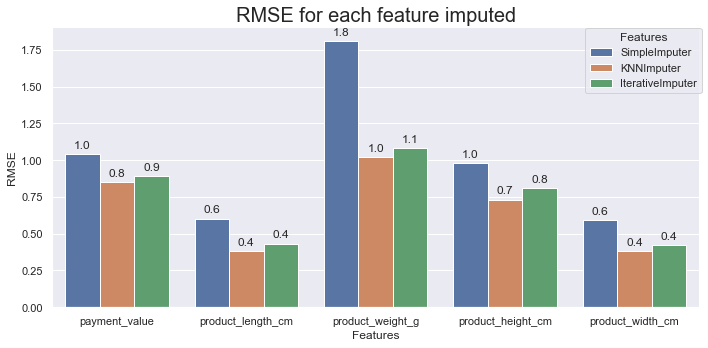

In [133]:
fig, ax1 = plt.subplots(figsize=(10, 5))
plt.title("RMSE for each feature imputed", size=20)
plot = sns.barplot(x="Feature", y="RMSE", hue="Method", data=df_RMSE, ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.legend(bbox_to_anchor=(1.004, 1), borderaxespad=0, title="Features")
plt.tight_layout()
plt.xlabel("Features", size=12)
plt.ylabel("RMSE", size=12)
plt.savefig("images/missing-values-imputations-RMSE.png")
sns.despine(fig)

<div class="alert alert-block alert-success">
    <b>Observations / Conclusions</b><br><br>
    The <b>KNNImputer</b> is the best result
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">7.5. Making final imputations</h3>
</div>

<div class="alert alert-block alert-info">
    <p>We are not consider the feature  <b>order_purchase_timestamp</b></p>
    <p>Making a <b>mask</b> to filter the records <b>without missing-values</b> to use them to fit the <b>KNN Imputer</b></p>
</div>

In [134]:
df_to_impute_KNN = data_outliers.loc[:]

In [135]:
df_to_impute_KNN.drop(columns=["order_purchase_timestamp"], axis=1, inplace=True)

In [136]:
mask = df_to_impute_KNN[["product_width_cm", "product_height_cm", "payment_value", "product_length_cm", "product_weight_g"]].notnull().all(axis=1)

In [137]:
df_trainnig = df_to_impute_KNN[mask].loc[:]

In [138]:
df_analysis(df_trainnig, "df_trainnig")


Analysis of df_trainnig dataset
--------------------------------------------------------------------
- Dataset shape:                  105412 rows and 13 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  9880
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 8.0+ MB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,order_id,object,105412,0,0.00000
1,customer_unique_id,object,105412,0,0.00000
2,order_status,category,105412,0,0.00000
3,review_score,float64,105412,0,0.00000
4,product_category,category,105412,0,0.00000
5,customer_city,category,105412,0,0.00000
6,customer_state,category,105412,0,0.00000
7,customer_region,category,105412,0,0.00000
8,payment_value,float64,105412,0,0.00000
9,product_length_cm,float64,105412,0,0.00000


<div class="alert alert-block alert-info">
    Preprocessing all data
</div>

In [139]:
le = LabelEncoder()
scaler = StandardScaler()

In [140]:
for df in ["df_trainnig", "df_to_impute_KNN"]:
    
    # Making LabelEncoder on categorical columns
    df_le = globals()[df][["order_id", "order_status", "customer_unique_id", "product_category", 
                     "customer_city", "customer_state", "customer_region"]].copy().apply(le.fit_transform)
    
    # Droping the real columns and concatenating the encoder columns
    globals()[df] = globals()[df].drop(columns=["order_id", "order_status", "customer_unique_id", "order_status", 
                                                "product_category", "customer_city", "customer_state", "customer_region"], axis=1)
    
    globals()[df] = pd.concat([globals()[df], df_le], axis=1)
    
    # Normalizing the datesets
    scaler_features = scaler.fit_transform(globals()[df])
    globals()[df] = pd.DataFrame(scaler_features, index=globals()[df].index, columns=globals()[df].columns)    

<div class="alert alert-block alert-info">
    Making the imputation
</div>

In [141]:
df_imputed = df_imputations(df_trainnig, df_to_impute_KNN, "KNNImputer", scaler)

<div class="alert alert-block alert-info">
    Refactoring the dataframe as original
</div>

In [142]:
df_imputed.drop(columns=["order_id", "order_status", "customer_unique_id", "product_category", 
                     "customer_city", "customer_state", "customer_region"], axis=1, inplace=True)

In [143]:
df_imputed = pd.concat([df_imputed, 
                        data_outliers[["order_id", "customer_unique_id", "order_status", "order_purchase_timestamp", 
                                       "product_category", "customer_city", "customer_state", "customer_region"]]], 
                       axis=1)

In [144]:
df_imputed.head()

,review_score,payment_value,product_length_cm,product_weight_g,product_height_cm,product_width_cm,order_id,customer_unique_id,order_status,order_purchase_timestamp,product_category,customer_city,customer_state,customer_region
69370,1.0,7.263347,4.802189,9.045916,4.500611,4.735688,10a045cdf6a5650c21e9cfeb60384c16,87ab9fec999db8bd5774917de3cdf01c,canceled,2018-10-17 17:30:18,unknown,sorocaba,SP,Southeast
77917,5.0,7.425433,4.834822,9.883990,4.830934,4.845703,b059ee4de278302d550a3035c4cdb740,262e1f1e26e92e86375f86840b4ffd63,canceled,2018-10-16 20:16:02,unknown,picos,PI,Northeast
36374,1.0,6.621083,4.727979,7.744666,3.948808,4.237344,a2ac6dad85cf8af5b0afb510a240fe8c,af5454198a97379394cacf676e1e96cb,canceled,2018-10-03 18:55:29,unknown,registro,SP,Southeast
100823,2.0,7.322300,5.080981,10.585646,4.449298,4.675447,616fa7d4871b87832197b2a137a115d2,634420a0ea42302205032ed44ac7fccc,canceled,2018-10-01 15:30:09,unknown,pirai,RJ,Southeast
57391,1.0,6.856240,4.522920,9.365564,3.394815,4.148414,392ed9afd714e3c74767d0c4d3e3f477,9bb92bebd4cb7511e1a02d5e50bc4655,canceled,2018-09-29 09:13:03,unknown,guarulhos,SP,Southeast


In [145]:
df_imputed = df_imputed[["order_id", "customer_unique_id", "order_purchase_timestamp", 
                         "order_status", "review_score", "payment_value", "product_category", 
                         "product_length_cm", "product_weight_g", "product_height_cm", 
                         "product_width_cm", "customer_city", "customer_state", "customer_region"]]

In [146]:
df_imputed.head()

,order_id,customer_unique_id,order_purchase_timestamp,order_status,review_score,payment_value,product_category,product_length_cm,product_weight_g,product_height_cm,product_width_cm,customer_city,customer_state,customer_region
69370,10a045cdf6a5650c21e9cfeb60384c16,87ab9fec999db8bd5774917de3cdf01c,2018-10-17 17:30:18,canceled,1.0,7.263347,unknown,4.802189,9.045916,4.500611,4.735688,sorocaba,SP,Southeast
77917,b059ee4de278302d550a3035c4cdb740,262e1f1e26e92e86375f86840b4ffd63,2018-10-16 20:16:02,canceled,5.0,7.425433,unknown,4.834822,9.883990,4.830934,4.845703,picos,PI,Northeast
36374,a2ac6dad85cf8af5b0afb510a240fe8c,af5454198a97379394cacf676e1e96cb,2018-10-03 18:55:29,canceled,1.0,6.621083,unknown,4.727979,7.744666,3.948808,4.237344,registro,SP,Southeast
100823,616fa7d4871b87832197b2a137a115d2,634420a0ea42302205032ed44ac7fccc,2018-10-01 15:30:09,canceled,2.0,7.322300,unknown,5.080981,10.585646,4.449298,4.675447,pirai,RJ,Southeast
57391,392ed9afd714e3c74767d0c4d3e3f477,9bb92bebd4cb7511e1a02d5e50bc4655,2018-09-29 09:13:03,canceled,1.0,6.856240,unknown,4.522920,9.365564,3.394815,4.148414,guarulhos,SP,Southeast


<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>At this point, we get the dataset without missing-values</p>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">8. Adding / Transforming features</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">- Inverse of log</h3>
</div>

<div class="alert alert-block alert-warning">
    <p>Before adding /transforming features, we are going to make the inverse of log over the features already transformed</p>
    <p>It is necessary to remember that we have done log2 transformation</p>
</div>

In [147]:
for col in NUMERIC_COLS:
    df_imputed[col] = 2 ** df_imputed[col] - 1    

In [148]:
df_analysis(df_imputed, "df_imputed", type_analysis="complete")


Analysis of df_imputed dataset
--------------------------------------------------------------------
- Dataset shape:                  113425 rows and 14 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  10454
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 13.5+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,order_id,object,113425,99441,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,customer_unique_id,object,113425,96096,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,order_purchase_timestamp,datetime64[ns],113425,98875,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,order_status,category,113425,8,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,review_score,float64,113425,11,0,0.00000,4.00035,1.00000,3.00000,5.00000,5.00000,5.00000,1.41067
5,payment_value,float64,113425,27378,0,0.00000,126.06956,6.08000,55.28000,91.86000,154.36000,4042.74000,124.09028
6,product_category,category,113425,74,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,product_length_cm,float64,113425,2499,0,0.00000,29.29954,7.00000,18.00000,25.00000,37.00000,105.00000,14.45894
8,product_weight_g,float64,113425,4942,0,0.00000,1838.14647,0.00000,300.00000,669.00000,1700.00000,30000.00000,2991.56604
9,product_height_cm,float64,113425,2017,0,0.00000,16.03340,2.00000,8.00000,13.00000,20.00000,105.00000,12.19129


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">- Filtering orders "unavailable" and "canceled"</h3>
</div>

In [149]:
df_imputed["order_status"].unique()

['canceled', 'delivered', 'unavailable', 'invoiced', 'shipped', 'created', 'processing', 'approved']
Categories (8, object): ['canceled', 'delivered', 'unavailable', 'invoiced', 'shipped', 'created', 'processing', 'approved']

In [150]:
df_imputed[df_imputed["order_status"]=="unavailable"].shape

(610, 14)

In [151]:
df_imputed[df_imputed["order_status"]=="canceled"].shape

(706, 14)

<div class="alert alert-block alert-info">
    <p>We are going to delete the order status "unavailable" and "canceled"</p>
</div>

In [152]:
df_imputed.drop((df_imputed[df_imputed["order_status"]=="unavailable"].index) | \
                (df_imputed[df_imputed["order_status"]=="canceled"].index), inplace=True)

C:\Users\Samir\AppData\Local\Temp/ipykernel_3636/2954900741.py:1: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  df_imputed.drop((df_imputed[df_imputed["order_status"]=="unavailable"].index) | \


In [153]:
df_imputed["order_status"].unique()

['delivered', 'invoiced', 'shipped', 'created', 'processing', 'approved']
Categories (6, object): ['delivered', 'invoiced', 'shipped', 'created', 'processing', 'approved']

In [154]:
df_imputed[df_imputed["order_status"]=="unavailable"].shape

(0, 14)

In [155]:
df_imputed[df_imputed["order_status"]=="canceled"].shape

(0, 14)

In [156]:
df_analysis(df_imputed, "df_imputed", type_analysis="complete")


Analysis of df_imputed dataset
--------------------------------------------------------------------
- Dataset shape:                  112109 rows and 14 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  10377
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 9.4+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,order_id,object,112109,98207,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,customer_unique_id,object,112109,94990,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,order_purchase_timestamp,datetime64[ns],112109,97655,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,order_status,category,112109,6,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,review_score,float64,112109,11,0,0.00000,4.02780,1.00000,4.00000,5.00000,5.00000,5.00000,1.38911
5,payment_value,float64,112109,26636,0,0.00000,126.02261,6.08000,55.17000,91.66000,154.32000,4042.74000,124.32464
6,product_category,category,112109,74,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,product_length_cm,float64,112109,1976,0,0.00000,29.33616,7.00000,18.00000,25.00000,37.00000,105.00000,14.49953
8,product_weight_g,float64,112109,4275,0,0.00000,1845.99415,0.00000,300.00000,675.00000,1750.00000,30000.00000,3000.42879
9,product_height_cm,float64,112109,1431,0,0.00000,16.04884,2.00000,8.00000,13.00000,20.00000,105.00000,12.22403


<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>At this point, we reduced the dataset from 113425 to 112109 records</p>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">8.1. Product category reduction</h3>
</div>

<div class="alert alert-block alert-info">
    <p>We are going to analyse the <b>product_category</b> to get new information based on it</p>
    <p>To do that, we are going to follow the steps belows:</p>
    <ul style="list-style-type: square;">
        <li>Identify the categories with the greater sales</li>
        <li>Identify the most common words within categories</li>
        <li>Reduced the list of categories based on the 2 previous points</li>
    </ul>
</div>

In [157]:
df_total_value_sales_by_category = df_imputed.groupby(["product_category"]).agg({"payment_value": "sum"}).reset_index()

In [158]:
df_total_value_sales_by_category.rename(columns={"payment_value" : "total_sales"}, inplace=True)

In [159]:
df_total_value_sales_by_category = df_total_value_sales_by_category.sort_values("total_sales", ascending=False).reset_index()

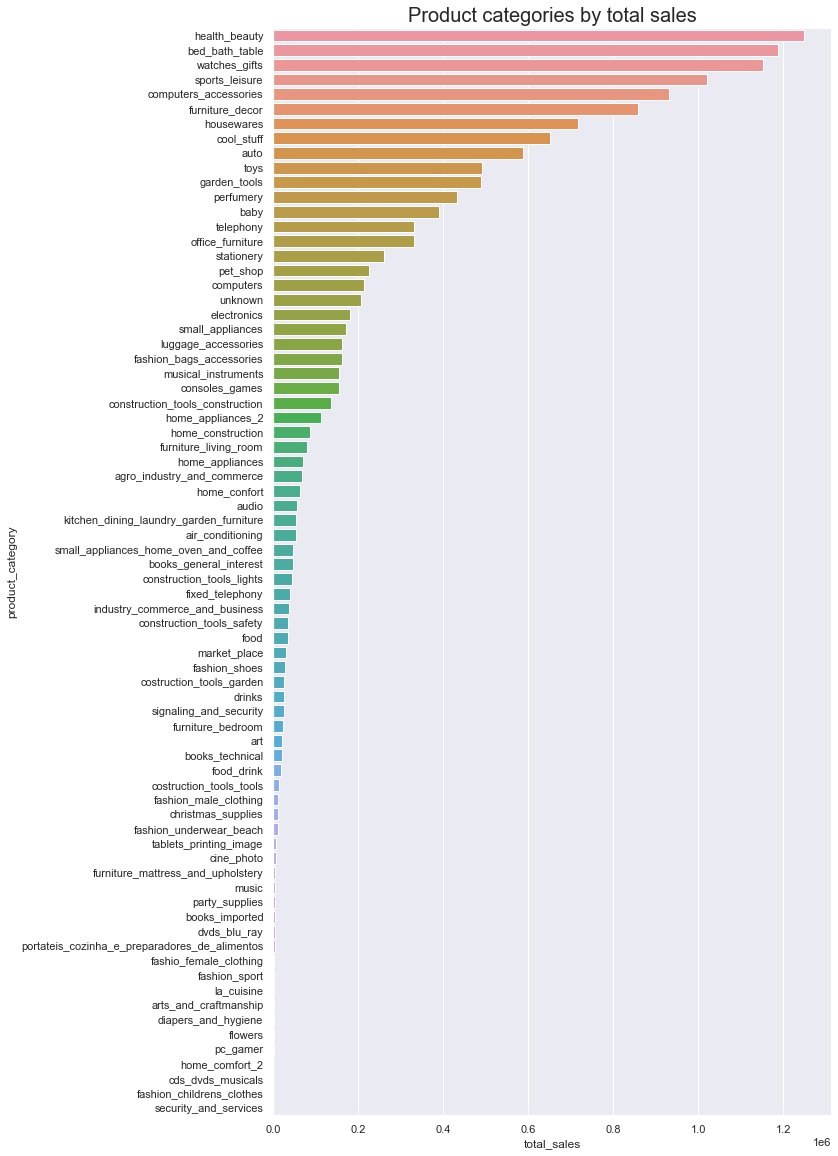

In [160]:
plt.figure(figsize=(10, 20))
sns.barplot(y="product_category", 
            x="total_sales", 
            data=df_total_value_sales_by_category, 
            order=df_total_value_sales_by_category["product_category"])
plt.title("Product categories by total sales", size=20)
plot.set(xlabel="Total sales", ylabel="Product categories")
plt.savefig("images/product-categories-by-total-sales.png")
sns.despine(fig)
plt.show()

<div class="alert alert-block alert-info">
    <p>Let's look the most common word within the product categories</p>
</div>

In [161]:
df_most_common_words = most_common_words(df_imputed["product_category"].tolist(), 30)
df_most_common_words.sort_values("Occurence number", ascending=False, inplace=True)

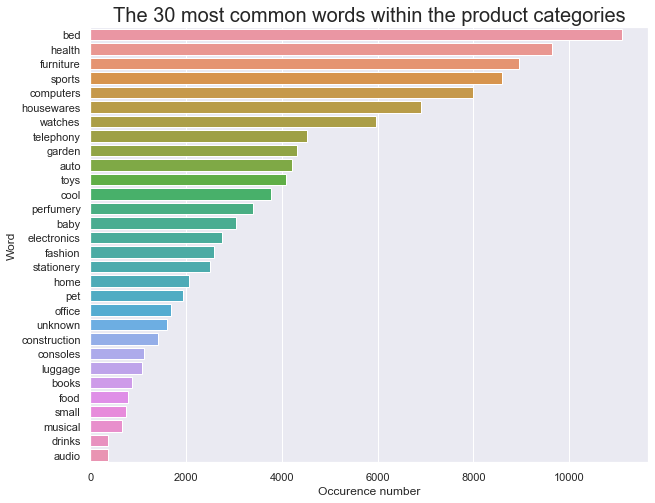

In [162]:
plt.figure(figsize=(10, 8))
sns.barplot(y="Word", x="Occurence number", data=df_most_common_words)
plt.title("The 30 most common words within the product categories", size=20)
plot.set(xlabel="Occurence number", ylabel="Words")
plt.savefig("images/30-most-common-words-within-product-categories.png")
sns.despine(fig)
plt.show()

<div class="alert alert-block alert-info">
    <p>Let's reduce the list of categories</p>
</div>

In [163]:
product_categories = {

    "fashion_bags_accessories": "fashion",    
    "fashio_female_clothing": "fashion",
    "fashion_sport": "fashion",
    "fashion_shoes": "fashion",
    "fashion_male_clothing": "fashion",   
    "fashion_underwear_beach": "fashion",
    "fashion_childrens_clothes": "fashion",
    "cool_stuff": "fashion",
    "art": "fashion",
    "arts_and_craftmanship": "fashion",
    "health_beauty": "fashion",
    "perfumery": "fashion",
    "watches_gifts": "fashion",
    
    
    "kitchen_dining_laundry_garden_furniture": "furniture",
    "furniture_decor": "furniture",
    "office_furniture": "furniture",
    "furniture_bedroom": "furniture",
    "furniture_living_room": "furniture",
    "furniture_mattress_and_upholstery": "furniture",
    "bed_bath_table": "furniture",

    
    "home_appliances": "home",
    "home_appliances_2": "home",
    "home_confort": "home",
    "home_comfort_2": "home",
    "air_conditioning": "home",
    "housewares": "home",
    "flowers": "home",
    
    
    "electronics": "electronics",
    "audio": "electronics",
    "tablets_printing_image": "electronics",
    "telephony": "electronics",
    "fixed_telephony": "electronics",
    "small_appliances": "electronics",
    "small_appliances_home_oven_and_coffee": "electronics",
    "computers_accessories": "electronics",
    "computers": "electronics",
    "pc_gamer": "electronics",
    "consoles_games": "electronics",
    "dvds_blu_ray": "electronics",
    "portateis_cozinha_e_preparadores_de_alimentos": "electronics",
    
    
    "construction_tools_construction": "construction",
    "construction_tools_lights": "construction",
    "construction_tools_safety": "construction",
    "costruction_tools_garden": "construction",
    "costruction_tools_tools": "construction",
    "garden_tools": "construction",
    "home_construction": "construction",

    
    "sports_leisure": "sports_leisure",
    "musical_instruments": "sports_leisure",
    "toys": "sports_leisure",
    "cine_photo": "sports_leisure",
    "cds_dvds_musicals": "sports_leisure",
    "music": "sports_leisure",
    "books_general_interest": "sports_leisure",
    "books_imported": "sports_leisure",
    "books_technical": "sports_leisure",


    "christmas_supplies": "others",
    "stationery": "others",
    "party_supplies": "others",
    "auto": "others",
    "luggage_accessories": "others",
    "signaling_and_security": "others",
    "agro_industry_and_commerce": "others",
    "security_and_services": "others",
    "market_place": "others",
    "pet_shop": "others",    
    "industry_commerce_and_business": "others",  
    "baby": "others",
    "diapers_and_hygiene": "others",
    "drinks": "others",
    "food": "others",
    "food_drink": "others",
    "la_cuisine": "others",
    "unknown": "others",
}

In [164]:
df_imputed["product_category"] = df_imputed["product_category"].replace(product_categories)

In [165]:
df_analysis(df_imputed, "df_imputed", type_analysis="complete")


Analysis of df_imputed dataset
--------------------------------------------------------------------
- Dataset shape:                  112109 rows and 14 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  10379
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 14.1+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,order_id,object,112109,98207,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,customer_unique_id,object,112109,94990,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,order_purchase_timestamp,datetime64[ns],112109,97655,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,order_status,category,112109,6,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,review_score,float64,112109,11,0,0.00000,4.02780,1.00000,4.00000,5.00000,5.00000,5.00000,1.38911
5,payment_value,float64,112109,26636,0,0.00000,126.02261,6.08000,55.17000,91.66000,154.32000,4042.74000,124.32464
6,product_category,object,112109,7,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,product_length_cm,float64,112109,1976,0,0.00000,29.33616,7.00000,18.00000,25.00000,37.00000,105.00000,14.49953
8,product_weight_g,float64,112109,4275,0,0.00000,1845.99415,0.00000,300.00000,675.00000,1750.00000,30000.00000,3000.42879
9,product_height_cm,float64,112109,1431,0,0.00000,16.04884,2.00000,8.00000,13.00000,20.00000,105.00000,12.22403


<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>So far, we have reduced from 73 to 7 categories</p>
</div>

In [166]:
df_total_value_sales_by_category = df_imputed.groupby(["product_category"]).agg({"payment_value": "sum"}).reset_index()

In [167]:
df_total_value_sales_by_category.rename(columns={"payment_value" : "total_sales"}, inplace=True)

In [168]:
df_total_value_sales_by_category = df_total_value_sales_by_category.sort_values("total_sales", ascending=False).reset_index()

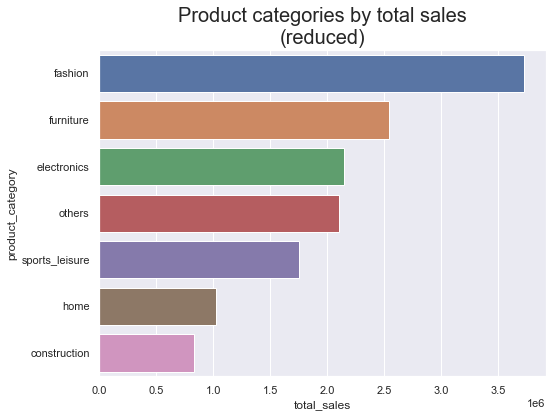

In [169]:
plt.figure(figsize=(8, 6))
sns.barplot(y="product_category", 
            x="total_sales", 
            data=df_total_value_sales_by_category, 
            order=df_total_value_sales_by_category["product_category"])
plt.title("Product categories by total sales\n(reduced)", size=20)
plot.set(xlabel="Total sales", ylabel="Product categories")
plt.savefig("images/product-categories-by-total-sales-reduced.png")
sns.despine(fig)
plt.show()

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">8.2. Filtering information by dates</h3>
</div>

<div class="alert alert-block alert-info">
    <p>At this point, we are going to filter the information by dates considering the following:</p>
    <ul style="list-style-type: square;">
        <li>Data only for the last year to avoid penalizing new customers compared to the old ones</li>
        <li>Data from periods preceding the last year to compare the final model</li>
    </ul>
    <p>So, let's start to identify the data for the last year in the dataset</p>
</div>

In [170]:
print("Newest day in the dataset", df_imputed["order_purchase_timestamp"].max())
print("Oldest day in the dataset", df_imputed["order_purchase_timestamp"].min())

Newest day in the dataset 2018-09-03 09:06:57
Oldest day in the dataset 2016-09-04 21:15:19


In [171]:
final_date = df_imputed["order_purchase_timestamp"].max()
final_date_minus_one_year = df_imputed["order_purchase_timestamp"].max() - pd.DateOffset(years=1)

print("Final date:\t\t\t", final_date)
print("Final date minus one year:\t", final_date_minus_one_year)

Final date:			 2018-09-03 09:06:57
Final date minus one year:	 2017-09-03 09:06:57


In [172]:
for i in range(0, 12, 2):
    
    final_date_temp = final_date - pd.DateOffset(months=i)
    final_date_minus_one_year_temp = final_date_minus_one_year - pd.DateOffset(months=i)

    print("dataset_" + str(i) + "_months")
    print("from " + str(final_date_minus_one_year_temp) + " to " + str(final_date_temp) +"\n")
    

dataset_0_months
from 2017-09-03 09:06:57 to 2018-09-03 09:06:57

dataset_2_months
from 2017-07-03 09:06:57 to 2018-07-03 09:06:57

dataset_4_months
from 2017-05-03 09:06:57 to 2018-05-03 09:06:57

dataset_6_months
from 2017-03-03 09:06:57 to 2018-03-03 09:06:57

dataset_8_months
from 2017-01-03 09:06:57 to 2018-01-03 09:06:57

dataset_10_months
from 2016-11-03 09:06:57 to 2017-11-03 09:06:57



<div class="alert alert-block alert-info">
    <p>From now on, we are going to define different dataset displaced with a range of 2 months each from the last year </p>
    <p>it means that we will have 6 dataset with the following dates</p>
    <ul style="list-style-type: square;">
        <li><b>Main dataset</b>&nbsp&nbsp&nbsp&nbsp&nbsp from 2017-09-03 to 2018-09-03</li>
        <li><b>minus 2 months</b> from 2017-07-03 to 2018-07-03</li>
        <li><b>minus 4 months</b> from 2017-05-03 to 2018-05-03</li>
        <li><b>minus 6 months</b> from 2017-03-03 to 2018-03-03</li>
        <li><b>minus 8 months</b> from 2017-01-03 to 2018-01-03</li>
        <li><b>minus 10 months</b> from 2016-11-03 to 2017-11-03</li>
    </ul>
    <p>The above is for doing the Cluster Stability</p>
</div>


In [173]:
for i in range(0, 12, 2):
    
    final_date_temp = final_date - pd.DateOffset(months=i)
    final_date_minus_one_year_temp = final_date_minus_one_year - pd.DateOffset(months=i)

    globals()["df_imputed_last_year_minus_" + str(i) + "_months"] = \
                df_imputed.loc[(df_imputed["order_purchase_timestamp"] >= final_date_minus_one_year_temp) & \
                               (df_imputed["order_purchase_timestamp"] <= final_date_temp)].copy()


In [174]:
for i in range(0, 12, 2):
    
    df_analysis(globals()["df_imputed_last_year_minus_" + str(i) + "_months"],
                "df_imputed_last_year_minus_" + str(i) + "_months",
                type_analysis="complete")


Analysis of df_imputed_last_year_minus_0_months dataset
--------------------------------------------------------------------
- Dataset shape:                  85870 rows and 14 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  8092
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 7.8+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,order_id,object,85870,75081,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,customer_unique_id,object,85870,73075,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,order_purchase_timestamp,datetime64[ns],85870,74643,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,order_status,category,85870,5,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,review_score,float64,85870,10,0,0.00000,4.00145,1.00000,3.00000,5.00000,5.00000,5.00000,1.41058
5,payment_value,float64,85870,22921,0,0.00000,126.66491,6.08000,55.82250,92.57000,155.63000,3126.50000,124.80990
6,product_category,object,85870,7,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,product_length_cm,float64,85870,1571,0,0.00000,28.83939,7.00000,18.00000,24.00000,36.00000,105.00000,14.28554
8,product_weight_g,float64,85870,3503,0,0.00000,1807.59330,0.00000,283.00000,650.00000,1700.00000,30000.00000,2948.55785
9,product_height_cm,float64,85870,1034,0,0.00000,15.99367,2.00000,8.00000,13.00000,20.00000,105.00000,12.07555



Analysis of df_imputed_last_year_minus_2_months dataset
--------------------------------------------------------------------
- Dataset shape:                  81501 rows and 14 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  7832
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 7.4+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,order_id,object,81501,71092,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,customer_unique_id,object,81501,69049,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,order_purchase_timestamp,datetime64[ns],81501,70675,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,order_status,category,81501,5,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,review_score,float64,81501,11,0,0.00000,3.98495,1.00000,3.00000,5.00000,5.00000,5.00000,1.41738
5,payment_value,float64,81501,21489,0,0.00000,126.69607,6.08000,55.78000,91.83000,154.89000,3126.50000,126.98081
6,product_category,object,81501,7,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,product_length_cm,float64,81501,1453,0,0.00000,29.30608,7.00000,18.00000,25.00000,37.00000,105.00000,14.53342
8,product_weight_g,float64,81501,3462,0,0.00000,1868.09401,2.00000,300.00000,680.00000,1750.00000,30000.00000,3020.86385
9,product_height_cm,float64,81501,1016,0,0.00000,16.19623,2.00000,8.00000,13.00000,20.00000,105.00000,12.28567



Analysis of df_imputed_last_year_minus_4_months dataset
--------------------------------------------------------------------
- Dataset shape:                  74396 rows and 14 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  6962
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 6.8+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,order_id,object,74396,65105,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,customer_unique_id,object,74396,63146,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,order_purchase_timestamp,datetime64[ns],74396,64709,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,order_status,category,74396,5,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,review_score,float64,74396,11,0,0.00000,3.96648,1.00000,3.00000,5.00000,5.00000,5.00000,1.42482
5,payment_value,float64,74396,19401,0,0.00000,125.97688,6.08000,55.28000,90.89000,154.20000,3126.50000,126.13065
6,product_category,object,74396,7,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,product_length_cm,float64,74396,1361,0,0.00000,29.70695,7.00000,18.00000,25.00000,38.00000,105.00000,14.74459
8,product_weight_g,float64,74396,3211,0,0.00000,1896.72462,2.00000,300.00000,700.00000,1750.00000,30000.00000,3054.99081
9,product_height_cm,float64,74396,969,0,0.00000,16.26985,2.00000,8.00000,13.00000,20.00000,105.00000,12.40193



Analysis of df_imputed_last_year_minus_6_months dataset
--------------------------------------------------------------------
- Dataset shape:                  63937 rows and 14 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  5878
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 5.8+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,order_id,object,63937,56068,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,customer_unique_id,object,63937,54332,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,order_purchase_timestamp,datetime64[ns],63937,55748,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,order_status,category,63937,6,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,review_score,float64,63937,11,0,0.00000,3.98856,1.00000,3.00000,5.00000,5.00000,5.00000,1.40794
5,payment_value,float64,63937,16949,0,0.00000,125.15750,6.08000,55.10000,90.17000,152.34000,3126.50000,124.94309
6,product_category,object,63937,7,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,product_length_cm,float64,63937,1151,0,0.00000,29.95811,7.00000,18.00000,25.00000,38.00000,105.00000,14.80704
8,product_weight_g,float64,63937,2897,0,0.00000,1887.52479,50.00000,300.00000,700.00000,1750.00000,30000.00000,3049.74133
9,product_height_cm,float64,63937,906,0,0.00000,16.22054,2.00000,8.00000,13.00000,20.00000,105.00000,12.34194



Analysis of df_imputed_last_year_minus_8_months dataset
--------------------------------------------------------------------
- Dataset shape:                  50951 rows and 14 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  4632
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 4.7+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,order_id,object,50951,44671,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,customer_unique_id,object,50951,43320,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,order_purchase_timestamp,datetime64[ns],50951,44427,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,order_status,category,50951,6,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,review_score,float64,50951,10,0,0.00000,4.04392,1.00000,4.00000,5.00000,5.00000,5.00000,1.36784
5,payment_value,float64,50951,15409,0,0.00000,125.95763,6.08000,55.00500,89.27000,152.33500,4042.74000,129.39061
6,product_category,object,50951,7,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,product_length_cm,float64,50951,897,0,0.00000,30.29938,7.00000,19.00000,26.00000,39.00000,105.00000,14.84675
8,product_weight_g,float64,50951,2532,0,0.00000,1907.46806,50.00000,300.00000,750.00000,1800.00000,30000.00000,3055.55603
9,product_height_cm,float64,50951,831,0,0.00000,16.32254,2.00000,8.00000,13.00000,21.00000,105.00000,12.40181



Analysis of df_imputed_last_year_minus_10_months dataset
--------------------------------------------------------------------
- Dataset shape:                  35984 rows and 14 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  3255
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 3.4+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,order_id,object,35984,31584,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,customer_unique_id,object,35984,30641,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,order_purchase_timestamp,datetime64[ns],35984,31435,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,order_status,category,35984,5,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,review_score,float64,35984,10,0,0.00000,4.11168,1.00000,4.00000,5.00000,5.00000,5.00000,1.31621
5,payment_value,float64,35984,12684,0,0.00000,127.01061,9.09000,54.63750,89.04847,153.10000,4042.74000,134.76701
6,product_category,object,35984,7,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,product_length_cm,float64,35984,652,0,0.00000,30.65905,7.00000,19.00000,26.00000,40.00000,105.00000,14.93477
8,product_weight_g,float64,35984,2044,0,0.00000,1951.10074,50.00000,300.00000,800.00000,1813.00000,30000.00000,3128.69598
9,product_height_cm,float64,35984,625,0,0.00000,16.35371,2.00000,8.00000,13.00000,21.00000,98.00000,12.58411


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">8.3. Payment value by customer per category</h3>
</div>

<div class="alert alert-block alert-info">
    <p>We are going to analyse the <b>product_category</b> to get new information based on it</p>
    <p>To do that, we are going to follow the steps belows:</p>
    <ul style="list-style-type: square;">
        <li>Get the total payments values by customer</li>
        <li>Get the payments values by customer by category</li>
        <li>Calculate the weight of categories with the greater sales in the payments values by customer</li>
    </ul>
</div>

In [175]:
for i in range(0, 12, 2):
    globals()["df_pv_customer_category_" + str(i) + "_months"] = globals()["df_imputed_last_year_minus_" + str(i) + "_months"].\
                                                                    groupby(["customer_unique_id", "product_category"]).\
                                                                    agg({"payment_value": "sum"}).\
                                                                    sort_values("payment_value", ascending=False).\
                                                                    sort_values("customer_unique_id", ascending=True).reset_index()
    
df_pv_customer_category_0_months.head()

,customer_unique_id,product_category,payment_value
0,0000366f3b9a7992bf8c76cfdf3221e2,furniture,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,fashion,27.19
2,0000f6ccb0745a6a4b88665a16c9f078,electronics,43.62
3,0004aac84e0df4da2b147fca70cf8255,electronics,196.89
4,0004bd2a26a76fe21f786e4fbd80607f,construction,166.98


<div class="alert alert-block alert-info">
    <p>Now, let's pivot the table to transform the categories to features</p>
</div>

In [176]:
for i in range(0, 12, 2):
    globals()["df_pv_customer_category_" + str(i) + "_months"] = pd.pivot_table(globals()["df_pv_customer_category_" + str(i) + "_months"],
                                                                                values="payment_value", index="customer_unique_id", 
                                                                                columns="product_category")
    
df_pv_customer_category_0_months.head()

product_category,construction,electronics,fashion,furniture,home,others,sports_leisure
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,NaN,NaN,NaN,141.9,NaN,NaN,NaN
0000b849f77a49e4a4ce2b2a4ca5be3f,NaN,NaN,27.19,NaN,NaN,NaN,NaN
0000f6ccb0745a6a4b88665a16c9f078,NaN,43.62,NaN,NaN,NaN,NaN,NaN
0004aac84e0df4da2b147fca70cf8255,NaN,196.89,NaN,NaN,NaN,NaN,NaN
0004bd2a26a76fe21f786e4fbd80607f,166.98,NaN,NaN,NaN,NaN,NaN,NaN


In [177]:
for i in range(0, 12, 2):
    # filling the missing-values with zero
    globals()["df_pv_customer_category_" + str(i) + "_months"].fillna(0, inplace=True)
    
    # Deleting the subindex
    globals()["df_pv_customer_category_" + str(i) + "_months"].reset_index(inplace=True)
    
    # Defining the columns based on index
    globals()["df_pv_customer_category_" + str(i) + "_months"].columns = pd.Index(list(
                                                                            globals()["df_pv_customer_category_" + str(i) + "_months"].columns))
    
df_pv_customer_category_0_months.head()

,customer_unique_id,construction,electronics,fashion,furniture,home,others,sports_leisure
0,0000366f3b9a7992bf8c76cfdf3221e2,0.00,0.00,0.00,141.9,0.0,0.0,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.00,0.00,27.19,0.0,0.0,0.0,0.0
2,0000f6ccb0745a6a4b88665a16c9f078,0.00,43.62,0.00,0.0,0.0,0.0,0.0
3,0004aac84e0df4da2b147fca70cf8255,0.00,196.89,0.00,0.0,0.0,0.0,0.0
4,0004bd2a26a76fe21f786e4fbd80607f,166.98,0.00,0.00,0.0,0.0,0.0,0.0


<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">- Customer who bought more than one category in the last period</h4>
</div>

<div class="alert alert-block alert-info">
    <p>We can see how many customers have bought more than one category</p>
</div>

In [178]:
## other option: .astype(bool).sum(axis=1).ge(2)
df_pv_customer_category_0_months["flag"] = df_pv_customer_category_0_months[["construction", "electronics",
                                                                             "fashion", "furniture", "home", 
                                                                             "others", "sports_leisure"]].gt(0).sum(axis=1).ge(2)

<div class="alert alert-block alert-info">
    <p>Let's verify the results</p>
</div>

In [179]:
df_pv_customer_category_0_months[df_pv_customer_category_0_months["flag"] == True].head(3)

,customer_unique_id,construction,electronics,fashion,furniture,home,others,sports_leisure,flag
173,0097fca0db567f5ca79509b7b4fc1c2d,0.0,0.00,0.0,159.48,68.18,0.00,0.00,True
187,00a39521eb40f7012db50455bf083460,0.0,26.78,0.0,0.00,0.00,0.00,96.47,True
197,00ae50eb5e1d2514f694dee1dcbbd5ae,0.0,0.00,0.0,58.80,0.00,217.33,0.00,True


In [180]:
df_pv_customer_category_0_months[df_pv_customer_category_0_months["customer_unique_id"] == "07547425c8f7a7086f529f2d3b80d21a"]

,customer_unique_id,construction,electronics,fashion,furniture,home,others,sports_leisure,flag
2062,07547425c8f7a7086f529f2d3b80d21a,0.0,40.86,119.15,0.0,0.0,0.0,237.89,True


In [181]:
df_pv_customer_category_0_months[df_pv_customer_category_0_months["customer_unique_id"] == "1b6c7548a2a1f9037c1fd3ddfed95f33"]

,customer_unique_id,construction,electronics,fashion,furniture,home,others,sports_leisure,flag
7795,1b6c7548a2a1f9037c1fd3ddfed95f33,0.0,0.0,433.35,313.14,160.37,52.15,0.0,True


In [182]:
df_pv_customer_category_0_months[df_pv_customer_category_0_months["flag"] == False].tail()

,customer_unique_id,construction,electronics,fashion,furniture,home,others,sports_leisure,flag
73070,fffb09418989a0dbff854a28163e47c6,0.0,0.0,73.16,0.0,0.0,0.00,0.0,False
73071,fffbf87b7a1a6fa8b03f081c5f51a201,0.0,0.0,0.00,0.0,0.0,167.32,0.0,False
73072,fffcc512b7dfecaffd80f13614af1d16,0.0,0.0,710.70,0.0,0.0,0.00,0.0,False
73073,fffea47cd6d3cc0a88bd621562a9d061,0.0,0.0,0.00,0.0,0.0,84.58,0.0,False
73074,ffff5962728ec6157033ef9805bacc48,0.0,0.0,133.69,0.0,0.0,0.00,0.0,False


<div class="alert alert-block alert-success">
    <p>Ok, we got as "True", the customers who bought more than one category in the last year</p>
</div>

In [183]:
numbers_of_categories_purchased = [
    df_pv_customer_category_0_months[df_pv_customer_category_0_months["flag"] == False].shape[0] / df_pv_customer_category_0_months.shape[0] * 100,
    df_pv_customer_category_0_months[df_pv_customer_category_0_months["flag"] == True].shape[0] / df_pv_customer_category_0_months.shape[0] * 100   
]
numbers_of_categories_purchased

[98.28532329798153, 1.7146767020184743]

In [184]:
del df_pv_customer_category_0_months["flag"]

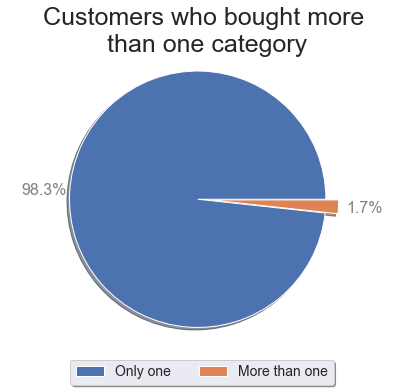

In [185]:
labels = "Only one", "More than one"
explode = (0, 0.1)

fig, ax1 = plt.subplots(figsize=[6,5])
ax1.set_title("Customers who bought more\n than one category", fontsize=25)
ax1.pie(x=numbers_of_categories_purchased, explode=explode, autopct="%1.1f%%", pctdistance=1.20,
        textprops=textprops, shadow=True, startangle=0)
ax1.axis("equal")  
fig.legend(labels, loc="center", ncol=5, fontsize=14, bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True)
plt.tight_layout()
plt.savefig("images/Customers-who-bought-more-than-one-category.png")
plt.show()

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Only the 1.7% of customer of the last year have bought more than one category in the last year.</p>
</div>

<div class="alert alert-block alert-info">
    <p>Now, let's identify <b>the total payments values by customer</b></p>
</div>

In [186]:
for i in range(0, 12, 2):
    globals()["df_total_payments_per_customer_" + str(i) + "_months"] = globals()["df_imputed_last_year_minus_" + str(i) + "_months"].\
                                                                            groupby(["customer_unique_id"]).\
                                                                            agg({"payment_value": "sum"}).\
                                                                            sort_values("payment_value", ascending=False).reset_index()
    
    globals()["df_total_payments_per_customer_" + str(i) + "_months"].rename(columns={"payment_value":"total_payments_value"}, inplace=True)
    
df_total_payments_per_customer_0_months.head()

,customer_unique_id,total_payments_value
0,4007669dec559734d6f53e029e360987,6081.54
1,c8460e4251689ba205045f3ea17884a1,4655.88
2,c6111f70f40b3420e387493c627c27fa,3126.50
3,895617ab63a9ad8881d9470f7427cd25,3126.50
4,be825ddd3b40db3f91bf05b4e9435d56,3122.72


<div class="alert alert-block alert-info">
    <p>Let's concatenate the two datasets</p>
</div>

In [187]:
for i in range(0, 12, 2):
    globals()["df_details_payments_by_customer_" + str(i) + "_months"] = globals()["df_pv_customer_category_" + str(i) + "_months"]\
                                                                            .merge(right=globals()["df_total_payments_per_customer_" + str(i) + "_months"],
                                                                                  on="customer_unique_id", how="left")
    
df_details_payments_by_customer_0_months.head()

,customer_unique_id,construction,electronics,fashion,furniture,home,others,sports_leisure,total_payments_value
0,0000366f3b9a7992bf8c76cfdf3221e2,0.00,0.00,0.00,141.9,0.0,0.0,0.0,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.00,0.00,27.19,0.0,0.0,0.0,0.0,27.19
2,0000f6ccb0745a6a4b88665a16c9f078,0.00,43.62,0.00,0.0,0.0,0.0,0.0,43.62
3,0004aac84e0df4da2b147fca70cf8255,0.00,196.89,0.00,0.0,0.0,0.0,0.0,196.89
4,0004bd2a26a76fe21f786e4fbd80607f,166.98,0.00,0.00,0.0,0.0,0.0,0.0,166.98


<div class="alert alert-block alert-info">
    <p>Now, let's calculate the weight of each category with respect to total_payments_values</p>
</div>

In [188]:
for i in range(0, 12, 2):
    globals()["df_weight_details_payments_by_customer_" + str(i) + "_months"] = globals()["df_details_payments_by_customer_" + str(i) + "_months"].copy()
    
    for col in globals()["df_weight_details_payments_by_customer_" + str(i) + "_months"].columns:
        if col != "total_payments_value" and col != "customer_unique_id":
            globals()["df_weight_details_payments_by_customer_" + str(i) + "_months"][col] = \
                            globals()["df_weight_details_payments_by_customer_" + str(i) + "_months"][col] /\
                            globals()["df_weight_details_payments_by_customer_" + str(i) + "_months"]["total_payments_value"] * 100

In [189]:
df_weight_details_payments_by_customer_0_months.head()

,customer_unique_id,construction,electronics,fashion,furniture,home,others,sports_leisure,total_payments_value
0,0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,0.0,100.0,0.0,0.0,0.0,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,100.0,0.0,0.0,0.0,0.0,27.19
2,0000f6ccb0745a6a4b88665a16c9f078,0.0,100.0,0.0,0.0,0.0,0.0,0.0,43.62
3,0004aac84e0df4da2b147fca70cf8255,0.0,100.0,0.0,0.0,0.0,0.0,0.0,196.89
4,0004bd2a26a76fe21f786e4fbd80607f,100.0,0.0,0.0,0.0,0.0,0.0,0.0,166.98


In [190]:
df_analysis(df_weight_details_payments_by_customer_0_months, "df_weight_details_payments_by_customer", type_analysis="complete")


Analysis of df_weight_details_payments_by_customer dataset
--------------------------------------------------------------------
- Dataset shape:                  73075 rows and 9 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 5.6+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,customer_unique_id,object,73075,73075,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,construction,float64,73075,248,0,0.00000,5.81895,0.00000,0.00000,0.00000,0.00000,100.00000,23.25572
2,electronics,float64,73075,280,0,0.00000,16.46312,0.00000,0.00000,0.00000,0.00000,100.00000,36.98369
3,fashion,float64,73075,457,0,0.00000,24.29591,0.00000,0.00000,0.00000,0.00000,100.00000,42.73413
4,furniture,float64,73075,509,0,0.00000,17.05780,0.00000,0.00000,0.00000,0.00000,100.00000,37.41145
5,home,float64,73075,287,0,0.00000,7.34869,0.00000,0.00000,0.00000,0.00000,100.00000,25.93413
6,others,float64,73075,460,0,0.00000,15.92213,0.00000,0.00000,0.00000,0.00000,100.00000,36.40465
7,sports_leisure,float64,73075,305,0,0.00000,13.09340,0.00000,0.00000,0.00000,0.00000,100.00000,33.60137
8,total_payments_value,float64,73075,27188,0,0.00000,148.84319,9.59000,63.10000,107.69000,177.36000,6081.54000,155.56457


<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Most of the customer are bought only one category</p>
    <p>Later, we are going to concatenate this dataset with the rest of information</p>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">8.3. RFM Analysis</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Now, we are going to make the <b>RFM Analysis</b> to define the customer behavior segmentation stands for <b>recency</b>, <b>frequency</b>, and <b>monetary value</b>.</p>
    <p>To do that, we are going to use the following features</p>
        <ul style="list-style-type: disc;">
            <li><b>order_purchase_timestamp :</b> Shows the purchase timestamp. <b>(recency)</b>.</li>
            <li><b>order_id :</b> unique identifier of the order. <b>(frequency)</b>.</li>
            <li><b>payment_value :</b> Transaction value. <b>(monetary value)</b>.</li>
            <li><b>review_score :</b> Customer score per order. <b>(satisfaction)</b>.</li>
        </ul>
    <p>Before making that, let's analyse in details the dataset that we have so now.</p>
</div>

In [191]:
for i in range(0, 12, 2):
    
    # copying the dataset split by date
    globals()["df_RFM_analysis_" + str(i) + "_months"] = globals()["df_imputed_last_year_minus_" + str(i) + "_months"]\
                                                                    [["order_id", "customer_unique_id", "order_purchase_timestamp", "payment_value", "review_score"]].copy()
    
    # verifying the orders duplicated
    globals()["mask" + str(i) + "_months"] =  globals()["df_RFM_analysis_" + str(i) + "_months"].duplicated("order_id", keep=False)
    globals()["df_RFM_analysis_" + str(i) + "_months"]["duplicated"] = globals()["mask" + str(i) + "_months"]
    
df_RFM_analysis_0_months[df_RFM_analysis_0_months["duplicated"]==True].sort_values("order_id").head()

,order_id,customer_unique_id,order_purchase_timestamp,payment_value,review_score,duplicated
61488,0008288aa423d2a3f00fcb17cd7d8719,9e4159995424971423b98c4a8bc11529,2018-02-13 22:10:21,63.27,5.0,True
61487,0008288aa423d2a3f00fcb17cd7d8719,9e4159995424971423b98c4a8bc11529,2018-02-13 22:10:21,63.27,5.0,True
41332,00143d0f86d6fbd9f9b38ab440ac16f5,bb8a37225e0279ac8a274c9765617eaf,2017-10-16 15:29:43,36.43,1.0,True
41331,00143d0f86d6fbd9f9b38ab440ac16f5,bb8a37225e0279ac8a274c9765617eaf,2017-10-16 15:29:43,36.43,1.0,True
41330,00143d0f86d6fbd9f9b38ab440ac16f5,bb8a37225e0279ac8a274c9765617eaf,2017-10-16 15:29:43,36.43,1.0,True


<div class="alert alert-block alert-info">
    <p>As we can see, there is more than one row per order. It mean that some customers bought more than one product in the same purchased</p>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">- Customer who bought more than one product in the same purchased</h4>
</div>

<div class="alert alert-block alert-info">
    <p>Let's how many customer have bought more than one product in the same purchased</p>
</div>

In [192]:
df_temp = pd.DataFrame(df_RFM_analysis_0_months.groupby(["order_id", "customer_unique_id"])["order_purchase_timestamp"].count().sort_values(ascending=False)).reset_index()
df_temp.rename(columns={"order_purchase_timestamp":"number_products_in_order"}, inplace=True)

In [193]:
df_temp.head()

,order_id,customer_unique_id,number_products_in_order
0,1b15974a0141d54e36626dca3fdc731a,c402f431464c72e27330a67f7b94d4fb,20
1,428a2f660dc84138d969ccd69a0ab6d5,0f5ac8d5c31de21d2f25e24be15bbffb,15
2,9bdc4d4c71aa1de4606060929dee888c,f7ea4eef770a388bd5b225acfc546604,14
3,73c8ab38f07dc94389065f7eba4f297a,31e412b9fb766b6794724ed17a41dfa6,14
4,37ee401157a3a0b28c9c6d0ed8c3b24b,7582a5a77fc2976628f46a13ec91b375,13


In [194]:
number_of_product_purchased_in_order = pd.DataFrame(df_temp.groupby(["number_products_in_order"])["order_id"].count().sort_values(ascending=False))\
                                                    .reset_index().rename(columns={"order_id":"number_orders"})

number_of_product_purchased_in_order.head()

,number_products_in_order,number_orders
0,1,67592
1,2,5691
2,3,1050
3,4,376
4,5,162


In [195]:
number_of_product_purchased_in_order["number_orders"] = number_of_product_purchased_in_order["number_orders"] / df_temp["order_id"].shape[0] * 100
number_of_product_purchased_in_order.rename(columns={"number_orders":"%_orders"}, inplace=True)
number_of_product_purchased_in_order.head()

,number_products_in_order,%_orders
0,1,90.025439
1,2,7.579814
2,3,1.398490
3,4,0.500792
4,5,0.215767


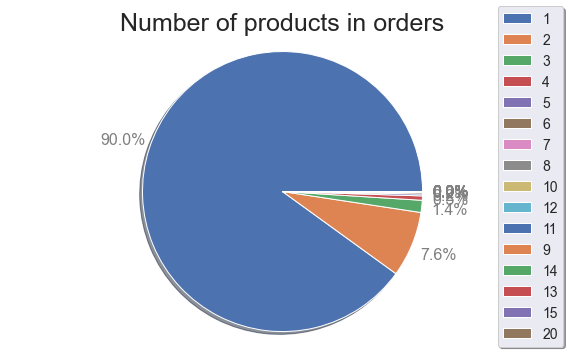

In [196]:
fig, ax1 = plt.subplots(figsize=[8,5])
ax1.set_title("Number of products in orders", fontsize=25)
ax1.pie(x=number_of_product_purchased_in_order["%_orders"], 
        autopct="%1.1f%%", pctdistance=1.20,
        textprops=textprops, shadow=True, startangle=0)
ax1.axis("equal")  
fig.legend(number_of_product_purchased_in_order["number_products_in_order"], 
           loc="upper right", fontsize=14, fancybox=True, shadow=True)
plt.tight_layout()
plt.savefig("images/number-of-products-in-orders.png")
plt.show()

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Most of the orders have only bought one product</p>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">- Customer who bought more than once on Olist</h4>
</div>

<div class="alert alert-block alert-info">
    <p>Now, let's see how many customer have bought more than once on Olist</p>
</div>

In [197]:
df_RFM_analysis_0_months.shape

(85870, 6)

<div class="alert alert-block alert-info">
    <p>Keeping only one order record by purchase</p>
</div>

In [198]:
df_temp = df_RFM_analysis_0_months.drop_duplicates(subset=["order_id"], keep="first", ignore_index=False)

In [199]:
df_temp.shape

(75081, 6)

In [200]:
df_temp = pd.DataFrame(df_temp.groupby(["customer_unique_id"])["order_id"].count().sort_values(ascending=False)).reset_index()
df_temp.rename(columns={"order_id":"number_of_purchases"}, inplace=True)
df_temp.head()

,customer_unique_id,number_of_purchases
0,8d50f5eadf50201ccdcedfb9e2ac8455,11
1,3e43e6105506432c953e165fb2acf44c,9
2,1b6c7548a2a1f9037c1fd3ddfed95f33,7
3,6469f99c1f9dfae7733b25662e7f1782,7
4,ca77025e7201e3b30c44b472ff346268,7


<div class="alert alert-block alert-info">
    <p>Verifying the number of purchases by customer</p>
</div>

In [201]:
df_RFM_analysis_0_months[df_RFM_analysis_0_months["customer_unique_id"] == "8d50f5eadf50201ccdcedfb9e2ac8455"]

,order_id,customer_unique_id,order_purchase_timestamp,payment_value,review_score,duplicated
76061,a1a6eadae352582010f449d8527b55f3,8d50f5eadf50201ccdcedfb9e2ac8455,2018-08-18 12:39:19,96.40,5.0,False
2655,c2213109a2cc0e75d55585b7aaac6d97,8d50f5eadf50201ccdcedfb9e2ac8455,2018-08-07 23:32:14,34.44,5.0,False
79278,112eb6f37f1b9dabbced368fbbc6c9ef,8d50f5eadf50201ccdcedfb9e2ac8455,2018-07-23 21:53:02,107.85,5.0,False
28361,6bdf325f0966e3056651285c0aed5aad,8d50f5eadf50201ccdcedfb9e2ac8455,2018-05-22 23:08:55,62.95,5.0,False
4112,23427a6bd9f8fd1b51f1b1e5cc186ab8,8d50f5eadf50201ccdcedfb9e2ac8455,2018-05-21 22:44:31,53.38,5.0,False
44950,b850a16d8faf65a74c51287ef34379ce,8d50f5eadf50201ccdcedfb9e2ac8455,2017-11-22 20:01:53,21.77,5.0,False
110889,cd4b336a02aacabd0ef22f6db711f95e,8d50f5eadf50201ccdcedfb9e2ac8455,2017-10-18 23:25:04,37.77,5.0,False
5829,e3071b7624445af6e4f3a1b23718667d,8d50f5eadf50201ccdcedfb9e2ac8455,2017-09-05 22:14:52,51.75,5.0,False
93302,838f8e96cf584a1d8d22eaf7143c7772,8d50f5eadf50201ccdcedfb9e2ac8455,2018-07-04 22:35:13,30.41,5.0,False
96808,89d9b111d2b990deb5f5f9769f92800b,8d50f5eadf50201ccdcedfb9e2ac8455,2017-10-29 16:58:02,21.77,5.0,False


<div class="alert alert-block alert-success">
    <p>The customer "8d50f5eadf50201ccdcedfb9e2ac8455" has 11 purchases as we identify in the previous step</p>
</div>

In [202]:
number_of_purchased_by_customer = pd.DataFrame(df_temp.groupby(["number_of_purchases"])["customer_unique_id"].count().sort_values(ascending=False))\
                                                    .reset_index().rename(columns={"customer_unique_id":"number_of_purchases",
                                                                                  "customer_unique_id":"number_of_customers"})

In [203]:
number_of_purchased_by_customer

,number_of_purchases,number_of_customers
0,1,71243
1,2,1710
2,3,96
3,4,16
4,5,5
5,7,3
6,9,1
7,11,1


In [204]:
number_of_purchased_by_customer["number_of_customers"] = number_of_purchased_by_customer["number_of_customers"] / df_RFM_analysis_0_months["customer_unique_id"].nunique() * 100
number_of_purchased_by_customer.rename(columns={"number_of_customers":"%_customers"}, inplace=True)
number_of_purchased_by_customer

,number_of_purchases,%_customers
0,1,97.492987
1,2,2.340062
2,3,0.131372
3,4,0.021895
4,5,0.006842
5,7,0.004105
6,9,0.001368
7,11,0.001368


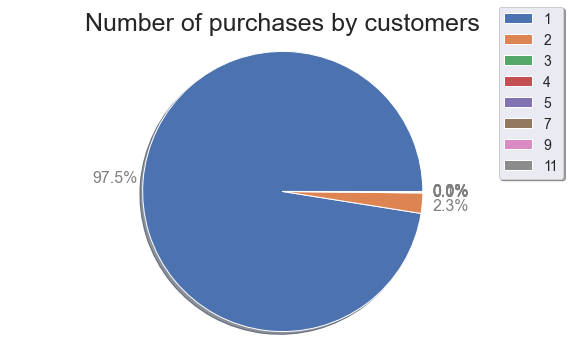

In [205]:
fig, ax1 = plt.subplots(figsize=[8,5])
ax1.set_title("Number of purchases by customers", fontsize=25)
ax1.pie(x=number_of_purchased_by_customer["%_customers"], 
        autopct="%1.1f%%", pctdistance=1.20,
        textprops=textprops, shadow=True, startangle=0)
ax1.axis("equal")  
fig.legend(number_of_purchased_by_customer["number_of_purchases"], 
           loc="upper right", fontsize=14, fancybox=True, shadow=True)
plt.tight_layout()
plt.savefig("images/number-of-purchases-by-customers.png")
plt.show()

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Most of the customer have only bought once on Olist in the last year</p>
</div>

<div class="alert alert-block alert-warning">
    <p>So now, we have analyzed the orders and theirs relations with categories, productos and customers.</p>
    <p>Let's continue doing the RFM calculation.</p>
    <p>As we can see, there is more than one row per order. It mean that the customer bought more than one produc in the same purchased</p>
    <p>We need to have only one row per order so, we have to summarize the items in the order based on RFM needs</p>
    <p>Let's summarize the payments value per order.</p>
</div>

In [206]:
for i in range(0, 12, 2):
    
    # copying the dataset split by date
    globals()["df_RFM_analysis_" + str(i) + "_months"] = globals()["df_imputed_last_year_minus_" + str(i) + "_months"]\
                                                                    [["order_id", "customer_unique_id", "order_purchase_timestamp", "payment_value", "review_score"]].copy()
    
    # verifying the orders duplicated
    globals()["mask" + str(i) + "_months"] =  globals()["df_RFM_analysis_" + str(i) + "_months"].duplicated("order_id", keep=False)
    globals()["df_RFM_analysis_" + str(i) + "_months"]["duplicated"] = globals()["mask" + str(i) + "_months"]
    
df_RFM_analysis_0_months[df_RFM_analysis_0_months["duplicated"]==True].sort_values("order_id").head()

,order_id,customer_unique_id,order_purchase_timestamp,payment_value,review_score,duplicated
61488,0008288aa423d2a3f00fcb17cd7d8719,9e4159995424971423b98c4a8bc11529,2018-02-13 22:10:21,63.27,5.0,True
61487,0008288aa423d2a3f00fcb17cd7d8719,9e4159995424971423b98c4a8bc11529,2018-02-13 22:10:21,63.27,5.0,True
41332,00143d0f86d6fbd9f9b38ab440ac16f5,bb8a37225e0279ac8a274c9765617eaf,2017-10-16 15:29:43,36.43,1.0,True
41331,00143d0f86d6fbd9f9b38ab440ac16f5,bb8a37225e0279ac8a274c9765617eaf,2017-10-16 15:29:43,36.43,1.0,True
41330,00143d0f86d6fbd9f9b38ab440ac16f5,bb8a37225e0279ac8a274c9765617eaf,2017-10-16 15:29:43,36.43,1.0,True


In [207]:
for i in range(0, 12, 2):
    
    globals()["payments_values_per_order" + str(i) + "_months"] = globals()["df_RFM_analysis_" + str(i) + "_months"]\
                                                                    .groupby(["order_id"]).agg({"payment_value": "sum"})\
                                                                    .reset_index()
    
    globals()["df_RFM_analysis_" + str(i) + "_months"] = globals()["df_RFM_analysis_" + str(i) + "_months"]\
                                                            .merge(globals()["payments_values_per_order" + str(i) + "_months"],
                                                                  on="order_id", how="left") 
    
    globals()["df_RFM_analysis_" + str(i) + "_months"].drop_duplicates("order_id", keep="first", inplace=True)
    
df_RFM_analysis_0_months[df_RFM_analysis_0_months["duplicated"]==True].sort_values("order_id").head()

,order_id,customer_unique_id,order_purchase_timestamp,payment_value_x,review_score,duplicated,payment_value_y
72342,0008288aa423d2a3f00fcb17cd7d8719,9e4159995424971423b98c4a8bc11529,2018-02-13 22:10:21,63.27,5.0,True,126.54
24358,00143d0f86d6fbd9f9b38ab440ac16f5,bb8a37225e0279ac8a274c9765617eaf,2017-10-16 15:29:43,36.43,1.0,True,109.29
77940,001ab0a7578dd66cd4b0a71f5b6e1e41,d1f24d1d504e27bee13b415e40daeab0,2017-12-27 00:38:47,42.52,4.0,True,127.56
52710,002c9def9c9b951b1bec6d50753c9891,6bcc1cd0c7f8bffa6f67a6a1fbef5782,2018-05-14 16:57:47,86.90,4.0,True,173.80
39136,00337fe25a3780b3424d9ad7c5a4b35e,3c857a6f7828bfb70fb712e2393cfd1b,2017-09-25 17:39:29,69.84,5.0,True,139.68


In [208]:
for i in range(0, 12, 2):
    
    globals()["df_RFM_analysis_" + str(i) + "_months"].drop(columns=["payment_value_x", "duplicated"], inplace=True)
    globals()["df_RFM_analysis_" + str(i) + "_months"].rename(columns={"payment_value_y":"payment_value"}, inplace=True)

df_RFM_analysis_0_months.sort_values("order_id").head(6)

,order_id,customer_unique_id,order_purchase_timestamp,review_score,payment_value
50562,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,2017-09-13 08:59:02,5.0,72.190000
43388,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,2018-01-14 14:33:31,5.0,216.870000
68474,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,2018-08-08 10:00:35,4.0,25.780000
64442,00054e8431b9d7675808bcb819fb4a32,635d9ac1680f03288e72ada3a1035803,2017-12-10 11:53:48,4.0,31.750000
71155,000576fe39319847cbb9d288c5617fa6,fda4476abb6307ab3c415b7e6d026526,2018-07-04 12:08:27,5.0,112.909491
11621,0005a1a1728c9d785b8e2b08b904576c,639d23421f5517f69d0c3d6e6564cf0e,2018-03-19 18:40:33,1.0,157.600000


<div class="alert alert-block alert-info">
    <p>Let's make the RFM analysis.</p>
</div>

In [209]:
for i in range(0, 12, 2):
    globals()["df_RFM_" + str(i) + "_months"] = RFM_analysis(globals()["df_RFM_analysis_" + str(i) + "_months"], 
                                                             "customer_unique_id", "order_purchase_timestamp", "order_id", "payment_value", "review_score")

In [210]:
df_RFM_0_months.head(10)

,customer_unique_id,recency,frequency,monetary,avg_basket,satisfaction
0,0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,141.90,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,27.19,4.0
2,0000f6ccb0745a6a4b88665a16c9f078,325,1,43.62,43.62,4.0
3,0004aac84e0df4da2b147fca70cf8255,292,1,196.89,196.89,5.0
4,0004bd2a26a76fe21f786e4fbd80607f,150,1,166.98,166.98,4.0
5,00050ab1314c0e55a6ca13cf7181fecf,135,1,35.38,35.38,4.0
6,00053a61a98854899e70ed204dd4bafe,186,1,419.18,419.18,1.0
7,0005ef4cd20d2893f0d9fbd94d3c0d97,174,1,129.76,129.76,1.0
8,00082cbe03e478190aadbea78542e933,287,1,126.26,126.26,5.0
9,00090324bbad0e9342388303bb71ba0a,162,1,63.66,63.66,5.0


<div class="alert alert-block alert-info">
    <p>Now, we are going to verify whether the RFM is consistent.</p>
</div>

In [211]:
mask = df_RFM_analysis_0_months.duplicated("customer_unique_id", keep=False)

In [212]:
df_RFM_analysis_0_months["duplicated"] = mask
df_RFM_analysis_0_months[df_RFM_analysis_0_months["duplicated"]==True].sort_values("customer_unique_id", ascending=False).head()

,order_id,customer_unique_id,order_purchase_timestamp,review_score,payment_value,duplicated
1092,54282e97f61c23b78330c15b154c867d,ff22e30958c13ffe219db7d711e8f564,2018-09-03 09:06:57,1.0,166.46,True
1097,6ca46f2b9a1592929647682510800e0e,ff22e30958c13ffe219db7d711e8f564,2018-08-24 17:02:19,1.0,166.46,True
9999,df52ca7830380e7d8f7292e99434eea7,ff03923ad1eb9e32304deb7f9b2a45c9,2018-05-26 11:51:22,3.0,123.53,True
10871,1d87599144fe1573be8611bf9f5d5de9,ff03923ad1eb9e32304deb7f9b2a45c9,2018-04-23 21:49:49,3.0,123.53,True
16132,169dbd59d432dd792647dc89ba948d40,fed519569d16e690df6f89cb99d4e682,2018-03-18 21:51:49,5.0,110.26,True


In [213]:
df_RFM_analysis_0_months[df_RFM_analysis_0_months["customer_unique_id"]=="8d50f5eadf50201ccdcedfb9e2ac8455"]

,order_id,customer_unique_id,order_purchase_timestamp,review_score,payment_value,duplicated
18647,a1a6eadae352582010f449d8527b55f3,8d50f5eadf50201ccdcedfb9e2ac8455,2018-08-18 12:39:19,5.0,96.40,True
18867,c2213109a2cc0e75d55585b7aaac6d97,8d50f5eadf50201ccdcedfb9e2ac8455,2018-08-07 23:32:14,5.0,34.44,True
19158,112eb6f37f1b9dabbced368fbbc6c9ef,8d50f5eadf50201ccdcedfb9e2ac8455,2018-07-23 21:53:02,5.0,107.85,True
19973,6bdf325f0966e3056651285c0aed5aad,8d50f5eadf50201ccdcedfb9e2ac8455,2018-05-22 23:08:55,5.0,62.95,True
19982,23427a6bd9f8fd1b51f1b1e5cc186ab8,8d50f5eadf50201ccdcedfb9e2ac8455,2018-05-21 22:44:31,5.0,53.38,True
23819,b850a16d8faf65a74c51287ef34379ce,8d50f5eadf50201ccdcedfb9e2ac8455,2017-11-22 20:01:53,5.0,21.77,True
24308,cd4b336a02aacabd0ef22f6db711f95e,8d50f5eadf50201ccdcedfb9e2ac8455,2017-10-18 23:25:04,5.0,37.77,True
25003,e3071b7624445af6e4f3a1b23718667d,8d50f5eadf50201ccdcedfb9e2ac8455,2017-09-05 22:14:52,5.0,51.75,True
45722,838f8e96cf584a1d8d22eaf7143c7772,8d50f5eadf50201ccdcedfb9e2ac8455,2018-07-04 22:35:13,5.0,30.41,True
46745,89d9b111d2b990deb5f5f9769f92800b,8d50f5eadf50201ccdcedfb9e2ac8455,2017-10-29 16:58:02,5.0,21.77,True


In [214]:
df_RFM_0_months[df_RFM_0_months["customer_unique_id"]=="8d50f5eadf50201ccdcedfb9e2ac8455"]

,customer_unique_id,recency,frequency,monetary,avg_basket,satisfaction
40204,8d50f5eadf50201ccdcedfb9e2ac8455,13,11,557.15,50.65,5.0


<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>We can see that the customer "8d50f5eadf50201ccdcedfb9e2ac8455" has 11 purchases made. So, the RFM Analysis has made a good analysis</p>
</div>

In [215]:
df_analysis(df_RFM_0_months, "df_RFM", type_analysis="complete")


Analysis of df_RFM dataset
--------------------------------------------------------------------
- Dataset shape:                  73075 rows and 6 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 3.3+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,customer_unique_id,object,73075,73075,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,recency,int64,73075,362,0,0.00000,175.79050,0.00000,92.00000,175.00000,263.00000,364.00000,98.87028
2,frequency,int64,73075,8,0,0.00000,1.02745,1.00000,1.00000,1.00000,1.00000,11.00000,0.18625
3,monetary,float64,73075,27186,0,0.00000,148.84319,9.59000,63.10000,107.69000,177.36000,6081.54000,155.56457
4,avg_basket,float64,73075,27159,0,0.00000,144.97293,9.59000,62.61500,105.83000,173.68000,6081.54000,149.21898
5,satisfaction,float64,73075,29,0,0.00000,4.08241,1.00000,4.00000,5.00000,5.00000,5.00000,1.34563


<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">8.3.1. Univariate analysis in RFM</h4>
</div>

<div class="alert alert-block alert-info">
    <p>Let's analyse each features in details</p>
</div>

In [216]:
df_RFM = df_RFM_0_months.copy()

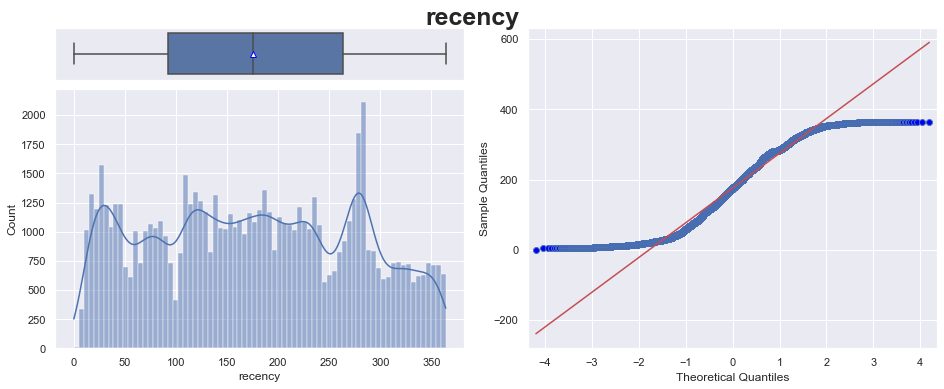


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,recency,Shapiro-Wilk,"Statistics=0.963, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,recency,D’Agostino’s K^2,"Statistics=30701.370, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,recency,Kolmogorov-Smirnov,"Statistics=1.000, p-value=0.000",Sample does not look Gaussian (reject H₀)


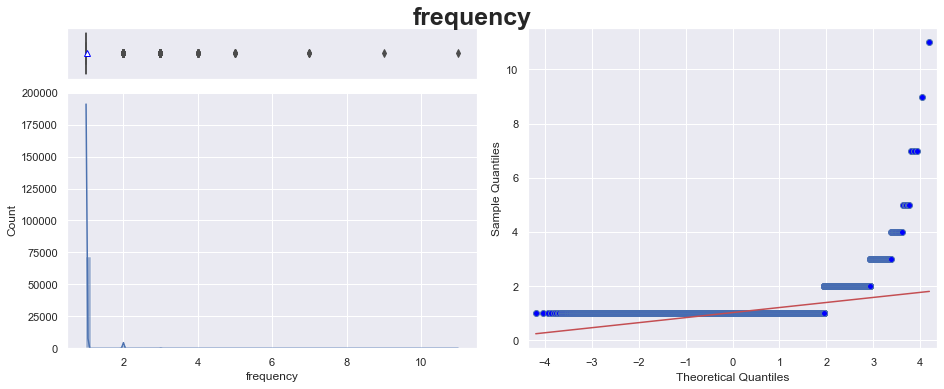


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,frequency,Shapiro-Wilk,"Statistics=0.128, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,frequency,D’Agostino’s K^2,"Statistics=121499.304, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,frequency,Kolmogorov-Smirnov,"Statistics=0.841, p-value=0.000",Sample does not look Gaussian (reject H₀)


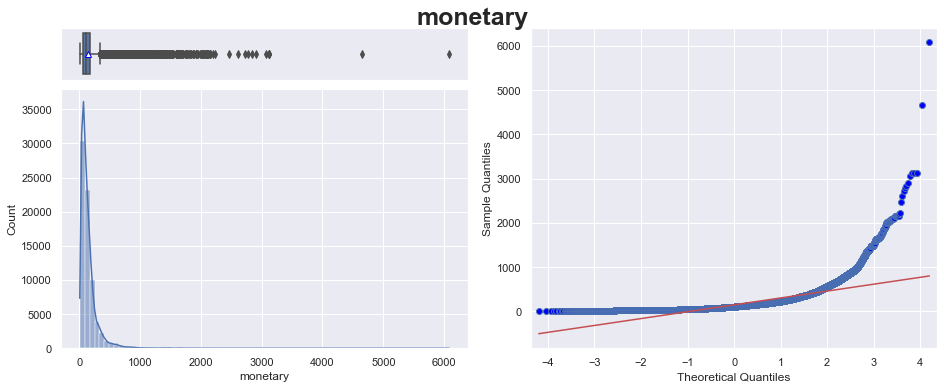


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,monetary,Shapiro-Wilk,"Statistics=0.619, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,monetary,D’Agostino’s K^2,"Statistics=83133.902, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,monetary,Kolmogorov-Smirnov,"Statistics=1.000, p-value=0.000",Sample does not look Gaussian (reject H₀)


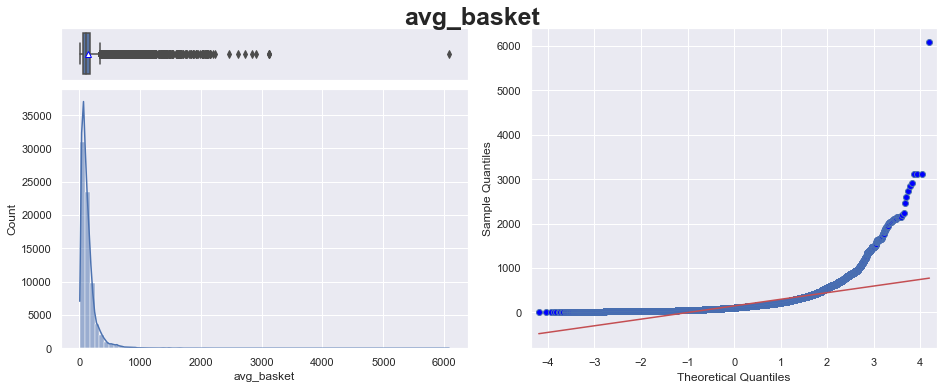


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,avg_basket,Shapiro-Wilk,"Statistics=0.622, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,avg_basket,D’Agostino’s K^2,"Statistics=82223.628, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,avg_basket,Kolmogorov-Smirnov,"Statistics=1.000, p-value=0.000",Sample does not look Gaussian (reject H₀)


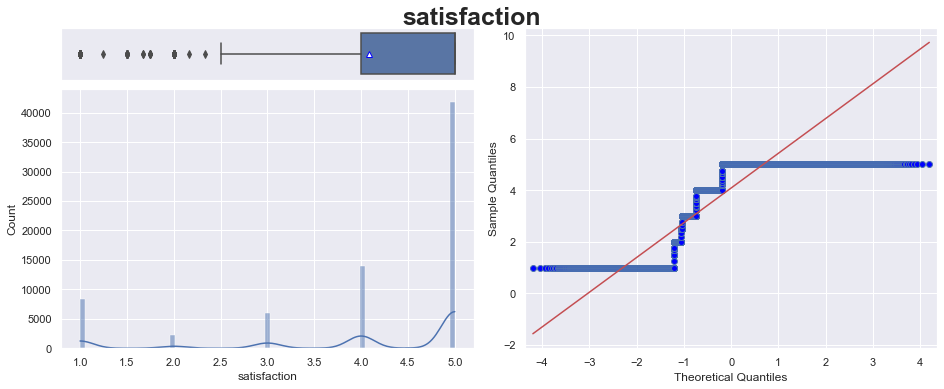


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,satisfaction,Shapiro-Wilk,"Statistics=0.692, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,satisfaction,D’Agostino’s K^2,"Statistics=13826.590, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,satisfaction,Kolmogorov-Smirnov,"Statistics=0.863, p-value=0.000",Sample does not look Gaussian (reject H₀)


In [217]:
for var in df_RFM.columns:
    
    if var != "customer_unique_id":
        
        fig = plt.figure(constrained_layout=True, figsize=[13,5])
        fig.suptitle(var, size=25, fontweight="bold", y=1.05)
        spec = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[1, 1], height_ratios=[1, 5])
        
        ax_box = fig.add_subplot(spec[0, 0])
        ax_hist = fig.add_subplot(spec[1, 0])
        ax_qqplot = fig.add_subplot(spec[:, 1])
        
        # Boxplot
        boxplot = sns.boxplot(data=df_RFM, x=df_RFM[var], showmeans=True, ax=ax_box,
                          meanprops={"markerfacecolor":"white", "markeredgecolor":"blue"})
        
        ax_box.set(xlabel="", xticks=[])
        ax_box.set(yticks=[])
        boxplot.set_title("")
        
        # Histplot
        sns.histplot(data=df_RFM, x=df_RFM[var], bins=75,  kde=True,  ax=ax_hist)
        ax_hist.set(xlabel=var)
    
        # QQplot
        qqplot(df_RFM[var], line='s', ax=ax_qqplot)

        plt.savefig("images/qqplot-of-" + var + ".png")
        plt.show()

        print("\nMaking the Normality Test")
        print("---------------------------------")
        normality_test(df_RFM[[var]])
        print("\n")

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>There is not a normal distribution among the features but, we need to remember that we have already done a log transformation in the features</p>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">8.3.2. Bivariate analysis</h4>
</div>

In [218]:
RFM_frequency = {"monetary" : "green", "recency" : "blue", "satisfaction" : "red"}

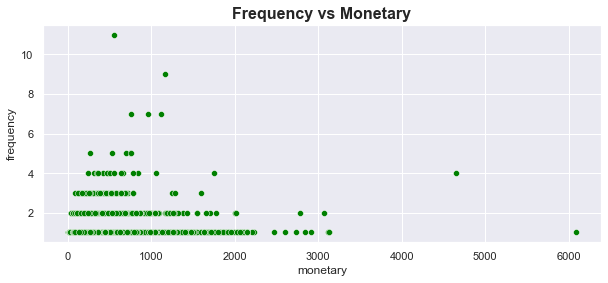

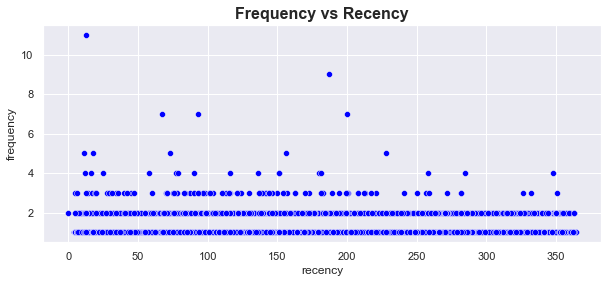

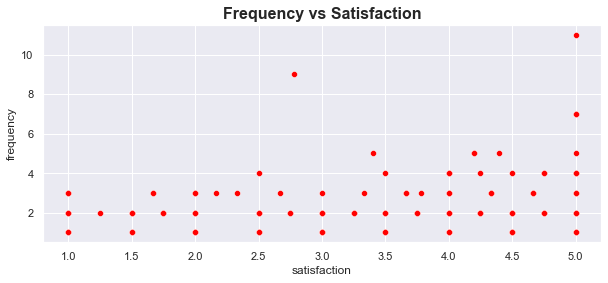

In [219]:
for col in RFM_frequency.keys():
    plt.figure(figsize=(10, 4))
    sns.scatterplot(data=df_RFM, 
                    x=df_RFM.groupby("customer_unique_id")[col].sum(), 
                    y=df_RFM.groupby("customer_unique_id")["frequency"].sum(),
                    color=RFM_frequency.get(col))
    plt.title("Frequency vs " + col.capitalize(), size=16, fontweight="bold")
    plt.savefig("images/frequency-vs-" + col + ".png")
    sns.despine(fig)
    plt.show()

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: disc;">
        <li><b>Frequency vs Monetary</b>: Regular purchases are for a small amount of money </li>
        <li><b>Frequency vs Recency</b>: The purchase frequency is low compared to recency </li>
    </ul> 
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">8.3.3. RFM Score</h4>
</div>

In [220]:
df_RFM.head()

,customer_unique_id,recency,frequency,monetary,avg_basket,satisfaction
0,0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,141.90,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,27.19,4.0
2,0000f6ccb0745a6a4b88665a16c9f078,325,1,43.62,43.62,4.0
3,0004aac84e0df4da2b147fca70cf8255,292,1,196.89,196.89,5.0
4,0004bd2a26a76fe21f786e4fbd80607f,150,1,166.98,166.98,4.0


In [221]:
quantiles = df_RFM[["recency", "frequency", "monetary"]].quantile([.2, .4, .6, .8])

In [222]:
quantiles

,recency,frequency,monetary
0.2,74.0,1.0,55.370
0.4,142.0,1.0,87.640
0.6,207.0,1.0,131.730
0.8,278.0,1.0,200.382


In [223]:
df_RFM["r_score"] = df_RFM["recency"].apply(lambda X: quintile_score(X, quantiles, "recency"))
df_RFM["f_score"] = df_RFM["frequency"].apply(lambda X: quintile_score(X, quantiles, "frequency"))
df_RFM["m_score"] = df_RFM["monetary"].apply(lambda X: quintile_score(X, quantiles, "monetary"))

In [224]:
df_RFM.head()

,customer_unique_id,recency,frequency,monetary,avg_basket,satisfaction,r_score,f_score,m_score
0,0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,141.90,5.0,4,1,4
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,27.19,4.0,4,1,1
2,0000f6ccb0745a6a4b88665a16c9f078,325,1,43.62,43.62,4.0,1,1,1
3,0004aac84e0df4da2b147fca70cf8255,292,1,196.89,196.89,5.0,1,1,4
4,0004bd2a26a76fe21f786e4fbd80607f,150,1,166.98,166.98,4.0,3,1,4


<div class="alert alert-block alert-info">
    <p>Let's verify the consisten of scores</p>
</div>

In [225]:
df_RFM[df_RFM["r_score"]==5].sort_values("recency", ascending=True).head()

,customer_unique_id,recency,frequency,monetary,avg_basket,satisfaction,r_score,f_score,m_score
72832,ff22e30958c13ffe219db7d711e8f564,0,2,332.92,166.46,1.0,5,5,5
52354,b701bebbdf478f5500348f03aff62121,4,1,33.23,33.23,3.0,5,1,1
36543,7febafa06d9d8f232a900a2937f04338,4,1,61.29,61.29,5.0,5,1,2
3511,0c6d7218d5f3fa14514fd29865269993,4,1,178.25,178.25,5.0,5,1,4
1170,0421e7a23f21e5d54efed456aedbc513,4,1,119.42,119.42,5.0,5,1,3


<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>We can see that customers with <b>r_score</b> of 5, have bought recently</p>
</div>

<div class="alert alert-block alert-info">
    <p>Now, we are concatenate the score to make the segments</p>
</div>

In [226]:
df_RFM["rfm_score"] = df_RFM["r_score"].astype(str) + df_RFM["f_score"].astype(str) + df_RFM["m_score"].astype(str)
df_RFM["rfm_score"] = df_RFM["rfm_score"].astype("int64")

In [227]:
df_RFM.head()

,customer_unique_id,recency,frequency,monetary,avg_basket,satisfaction,r_score,f_score,m_score,rfm_score
0,0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,141.90,5.0,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,27.19,4.0,4,1,1,411
2,0000f6ccb0745a6a4b88665a16c9f078,325,1,43.62,43.62,4.0,1,1,1,111
3,0004aac84e0df4da2b147fca70cf8255,292,1,196.89,196.89,5.0,1,1,4,114
4,0004bd2a26a76fe21f786e4fbd80607f,150,1,166.98,166.98,4.0,3,1,4,314


<div class="alert alert-block alert-info">
    <p>Let's create some human friendly labels for the scores based on <b>Exponea RFM Segmentation</b></p>
    <ul style="list-style-type: disc;">
        <li><b>Champions</b>: 555, 554, 544, 545, 454, 455, 445</li>
        <li><b>Loyal</b>: 543, 444, 435, 355, 354, 345, 344, 335</li>
        <li><b>Potential Loyalist</b>: 553, 551, 552, 541, 542, 533, 532, 531, 452, 451, 442, 441, 431, 453, 433, 432, 423, 353, 352, 351, 342, 341, 333, 323  </li>
        <li><b>New Customers</b>: 512, 511, 422, 421, 412, 411, 311 </li>
        <li><b>Promising</b>: 525, 524, 523, 522, 521, 515, 514, 513, 425,424, 413,414,415, 315, 314, 313 </li>
        <li><b>Need Attention</b>: 535, 534, 443, 434, 343, 334, 325, 324</li>
        <li><b>About To Sleep</b>: 331, 321, 312, 221, 213, 231, 241, 251</li>
        <li><b>At Risk</b>: 255, 254, 245, 244, 253, 252, 243, 242, 235, 234, 225, 224, 153, 152, 145, 143, 142, 135, 134, 133, 125, 124</li>
        <li><b>Cannot Lose Them</b>: 155, 154, 144, 214,215,115, 114, 113</li>
        <li><b>Hibernating customers</b>: 332, 322, 231, 241, 251, 233, 232, 223, 222, 132, 123, 122, 212, 211</li>
        <li><b>Lost customers</b>: 111, 112, 121, 131,141,151</li>
    </ul> 
    <p>Here, you can see in details the information about the segmentation</p>
        <ul style="list-style-type: disc;">
        <li>https://docs.exponea.com/docs/rfm-segmentation</li>
        <li>https://docs.exponea.com/docs/rfm-segmentation-business-use</li>
    </ul> 
    
</div>

In [228]:
df_RFM["rfm_score_label"] = df_RFM["rfm_score"].apply(lambda X: RFM_segments(X))

In [229]:
df_RFM.head()

,customer_unique_id,recency,frequency,monetary,avg_basket,satisfaction,r_score,f_score,m_score,rfm_score,rfm_score_label
0,0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,141.90,5.0,4,1,4,414,Promising
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,27.19,4.0,4,1,1,411,New Customers
2,0000f6ccb0745a6a4b88665a16c9f078,325,1,43.62,43.62,4.0,1,1,1,111,Lost customers
3,0004aac84e0df4da2b147fca70cf8255,292,1,196.89,196.89,5.0,1,1,4,114,Cannot Lose Them
4,0004bd2a26a76fe21f786e4fbd80607f,150,1,166.98,166.98,4.0,3,1,4,314,Promising


In [230]:
df_RFM[df_RFM["frequency"] >=3]

,customer_unique_id,recency,frequency,monetary,avg_basket,satisfaction,r_score,f_score,m_score,rfm_score,rfm_score_label
837,02e9109b7e0a985108b43e573b6afb23,111,3,602.730000,200.910000,4.333333,4,5,5,455,Champions
2163,07b1b60bca2b6326fa2adb259ea4a55f,116,3,251.540000,83.846667,4.333333,4,5,5,455,Champions
2519,08e5b38d7948d37fbb2a59fc5e175ab1,116,4,1056.330000,264.082500,4.000000,4,5,5,455,Champions
4011,0e4cb268bd62da7db135af6349b4fc2a,282,3,195.460000,65.153333,5.000000,1,5,4,154,Cannot Lose Them
5331,12d8b5ed661190a3a08183644dfc504d,123,3,704.150000,234.716667,3.666667,4,5,5,455,Champions
...,...,...,...,...,...,...,...,...,...,...,...
70404,f64ec6d8dd29940264cd0bbb5ecade8a,285,4,359.000000,89.750000,5.000000,1,5,5,155,Cannot Lose Them
71069,f8bc1d81f395f6239a2a5ab1b9edf1ab,13,3,515.100000,171.700000,5.000000,5,5,5,555,Champions
72055,fc719c11b4dce594f47e1f9aa739a3a2,250,3,273.100000,91.033333,5.000000,2,5,5,255,At Risk
72374,fd8ccc89be43894d2553494c71a61fd8,137,3,258.030000,86.010000,4.666667,4,5,5,455,Champions


<div style="background-color: #6D83C5;" >
    <h5 style="margin: auto; padding: 20px; color:#fff; ">8.3.3.1. Plotting RFM Score</h5>
</div>

<div class="alert alert-block alert-info">
    <p>Let's plot how the Olist customer are distributed</p>
</div>

<div style="background-color: #6D83C5;" >
    <h5 style="margin: auto; padding: 20px; color:#fff; ">- Treemaps RFM</h5>
</div>

In [231]:
rfm_sns_palette = sns.color_palette("husl", df_RFM["rfm_score_label"].nunique())
rfm_colors = {label : color for label, color in zip(df_RFM["rfm_score_label"].unique(), rfm_sns_palette.as_hex())}

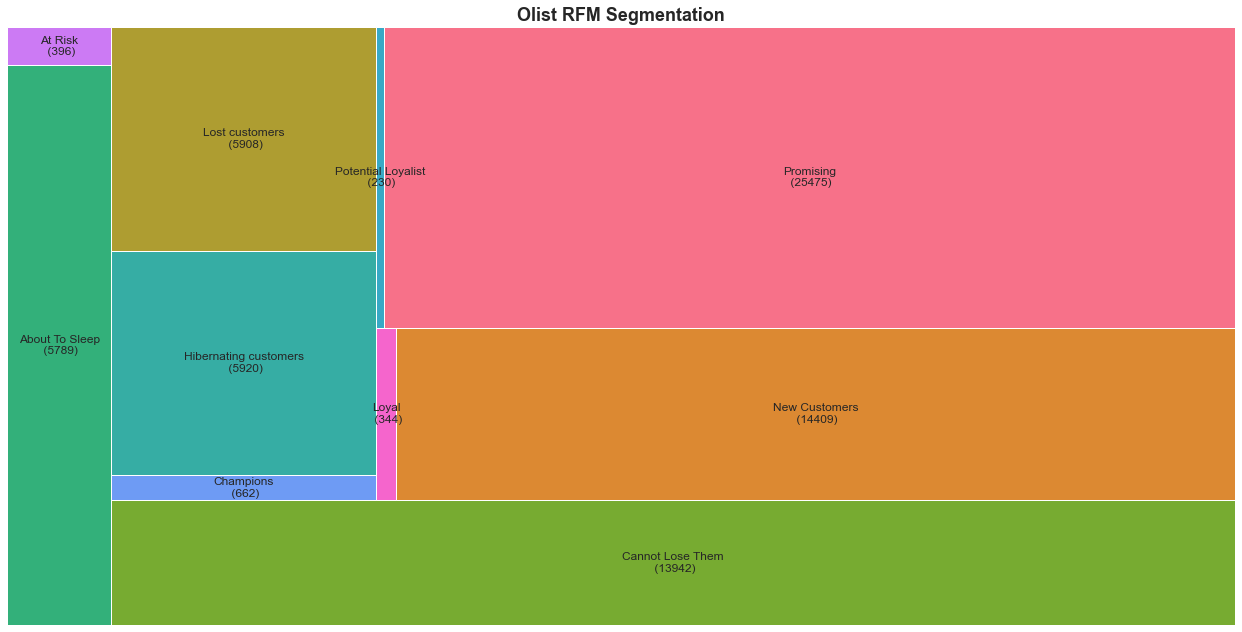

In [232]:
df = df_RFM.groupby("rfm_score_label").size().reset_index(name="counts")
labels = df.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
labels_short = df.apply(lambda x: str(x[0]), axis=1).tolist()

LIST_COLORS = []
for label in labels_short:
    LIST_COLORS.append(rfm_colors.get(label))

sizes = df["counts"].values.tolist()

plt.figure(figsize=(22, 11))
plt.title("Olist RFM Segmentation", size=18, fontweight="bold")
plt.axis('off')
squarify.plot(sizes=sizes, label=labels, norm_x=100, norm_y=100, color=LIST_COLORS, alpha=1)
plt.savefig("images/Olist-RFM-Segmentation.png")
plt.show()       

In [233]:
df_RFM.groupby("rfm_score_label")["customer_unique_id"].count().sort_values(ascending=False)

rfm_score_label
Promising                25475
New Customers            14409
Cannot Lose Them         13942
Hibernating customers     5920
Lost customers            5908
About To Sleep            5789
Champions                  662
At Risk                    396
Loyal                      344
Potential Loyalist         230
Name: customer_unique_id, dtype: int64

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p> As we can see, some segmentation are missing:</p>
    <ul style="list-style-type: disc;">
        <li><b>Need Attention</b></li>
    </ul> 
</div>

<div style="background-color: #6D83C5;" >
    <h5 style="margin: auto; padding: 20px; color:#fff; ">- Spider RFM</h5>
</div>

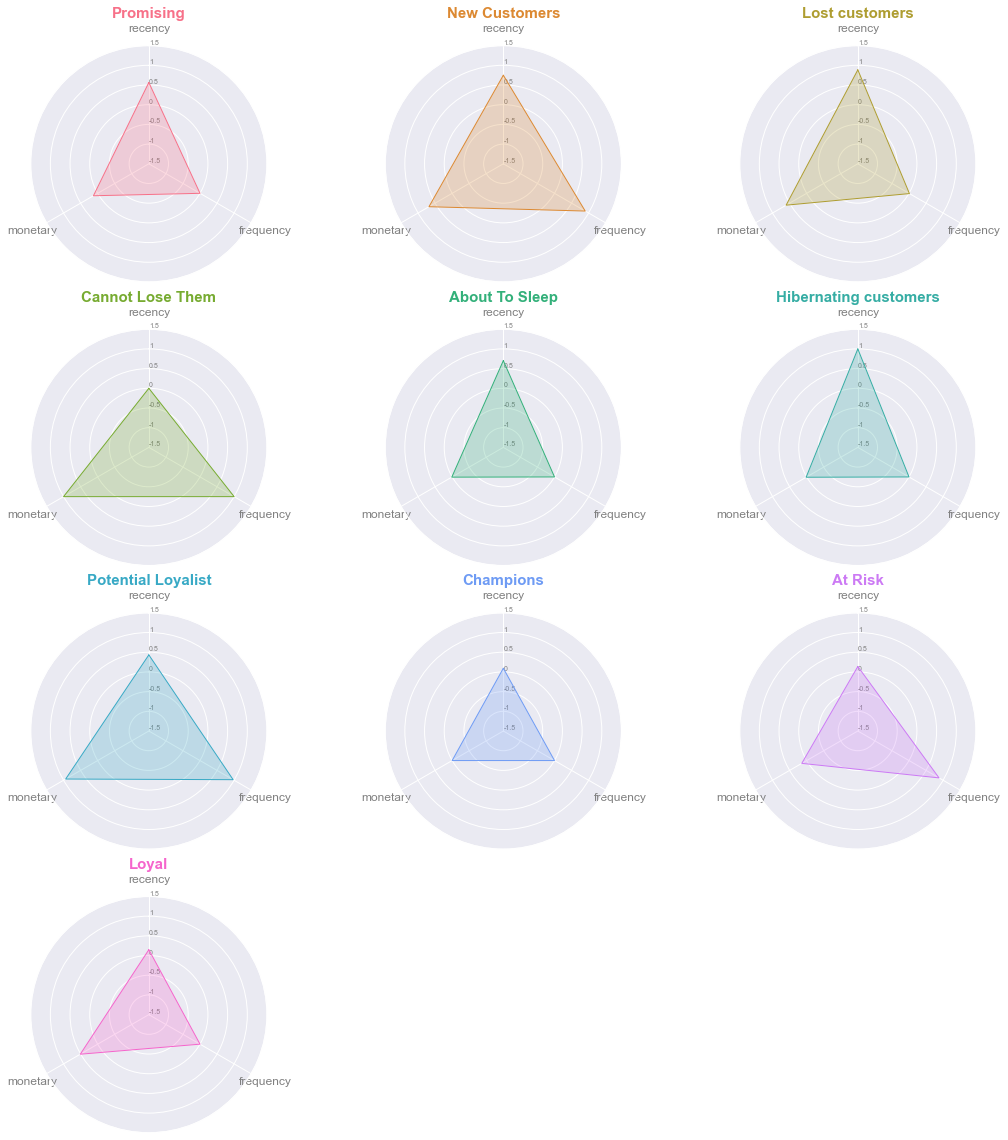

In [234]:
df_spider_RFM(df_RFM[["recency", "frequency", "monetary", "rfm_score_label"]], "rfm_score_label", rfm_colors)

<div class="alert alert-block alert-info">
    <p>Now, we can delete some features to avoit multicollinearity</p>
    <ul style="list-style-type: disc;">
        <li>monetary</li>
        <li>r_score</li>
        <li>f_score</li>
        <li>m_score</li>
        <li>rfm_score</li>
    </ul>     
</div>

In [235]:
df_RFM.drop(columns=["avg_basket", "r_score", "f_score", "m_score", "rfm_score"], axis=1, inplace=True)

In [236]:
df_RFM.head()

,customer_unique_id,recency,frequency,monetary,satisfaction,rfm_score_label
0,0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,5.0,Promising
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,4.0,New Customers
2,0000f6ccb0745a6a4b88665a16c9f078,325,1,43.62,4.0,Lost customers
3,0004aac84e0df4da2b147fca70cf8255,292,1,196.89,5.0,Cannot Lose Them
4,0004bd2a26a76fe21f786e4fbd80607f,150,1,166.98,4.0,Promising


In [237]:
df_analysis(df_RFM, "df_RFM", type_analysis="complete")


Analysis of df_RFM dataset
--------------------------------------------------------------------
- Dataset shape:                  73075 rows and 6 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 3.3+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,customer_unique_id,object,73075,73075,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,recency,int64,73075,362,0,0.00000,175.79050,0.00000,92.00000,175.00000,263.00000,364.00000,98.87028
2,frequency,int64,73075,8,0,0.00000,1.02745,1.00000,1.00000,1.00000,1.00000,11.00000,0.18625
3,monetary,float64,73075,27186,0,0.00000,148.84319,9.59000,63.10000,107.69000,177.36000,6081.54000,155.56457
4,satisfaction,float64,73075,29,0,0.00000,4.08241,1.00000,4.00000,5.00000,5.00000,5.00000,1.34563
5,rfm_score_label,object,73075,10,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">8.4. Merging RFM with the categories based on weight</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Now, we are going to merge <b>RFM</b> with <b>Categories</b></p>
</div>

In [238]:
for i in range(0, 12, 2):
    
    globals()["data_" + str(i) + "_months"] = globals()["df_RFM_" + str(i) + "_months"]\
                                                .merge(globals()["df_weight_details_payments_by_customer_" + str(i) + "_months"],
                                                      on="customer_unique_id", how="left")
    
    globals()["data_" + str(i) + "_months"].drop(columns=["avg_basket", "total_payments_value"], index=1, inplace=True)
    
data_0_months.head()

,customer_unique_id,recency,frequency,monetary,satisfaction,construction,electronics,fashion,furniture,home,others,sports_leisure
0,0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,5.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
2,0000f6ccb0745a6a4b88665a16c9f078,325,1,43.62,4.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
3,0004aac84e0df4da2b147fca70cf8255,292,1,196.89,5.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
4,0004bd2a26a76fe21f786e4fbd80607f,150,1,166.98,4.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
5,00050ab1314c0e55a6ca13cf7181fecf,135,1,35.38,4.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0


<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">9. Analyze the result dataset</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">9.1. Univariate analysis for continous variables</h3>
</div>
<br>
<div class="alert alert-block alert-info">
    Before to make missing-values treating, we are going to analyse normal distribution for each continuos variable
</div>

In [239]:
data = data_0_months.copy()

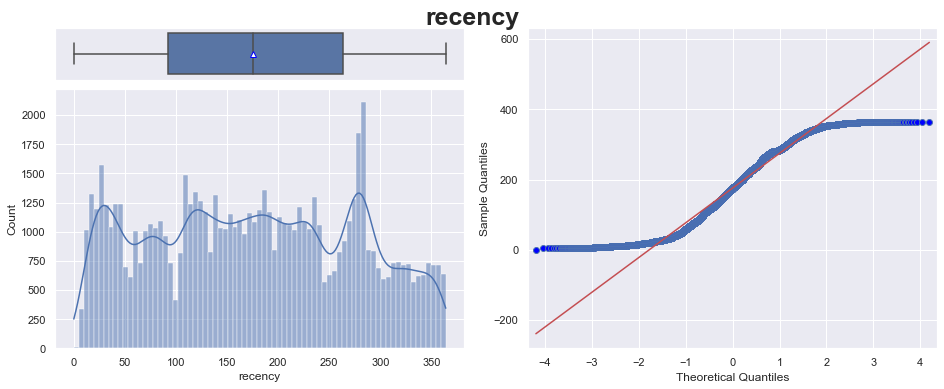


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,recency,Shapiro-Wilk,"Statistics=0.963, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,recency,D’Agostino’s K^2,"Statistics=30703.218, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,recency,Kolmogorov-Smirnov,"Statistics=1.000, p-value=0.000",Sample does not look Gaussian (reject H₀)


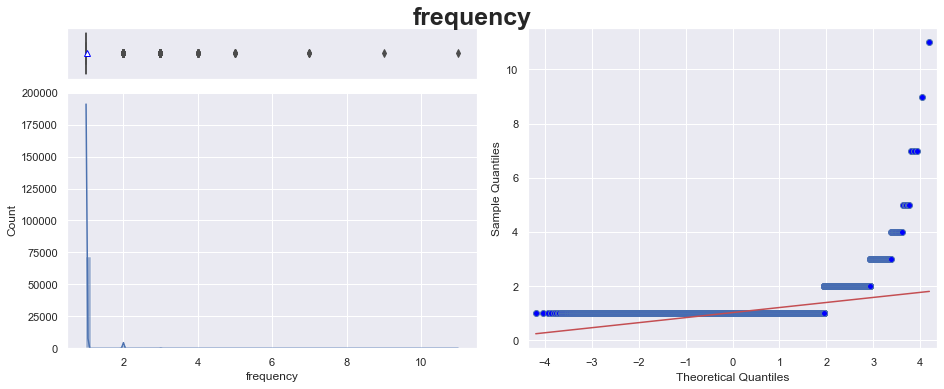


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,frequency,Shapiro-Wilk,"Statistics=0.128, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,frequency,D’Agostino’s K^2,"Statistics=121497.209, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,frequency,Kolmogorov-Smirnov,"Statistics=0.841, p-value=0.000",Sample does not look Gaussian (reject H₀)


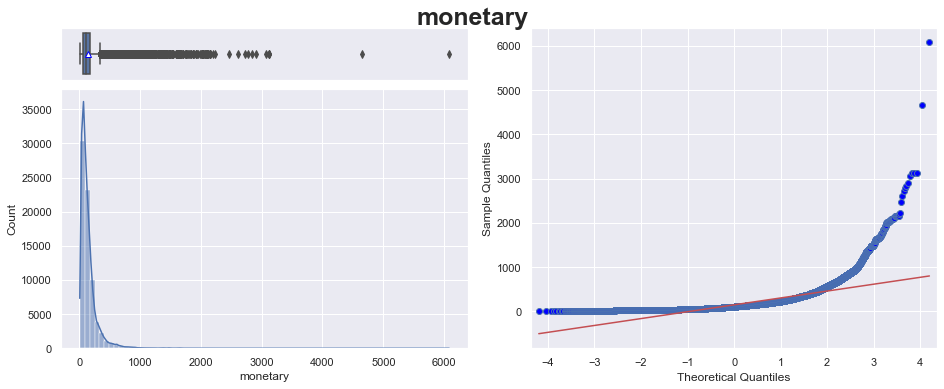


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,monetary,Shapiro-Wilk,"Statistics=0.619, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,monetary,D’Agostino’s K^2,"Statistics=83132.815, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,monetary,Kolmogorov-Smirnov,"Statistics=1.000, p-value=0.000",Sample does not look Gaussian (reject H₀)


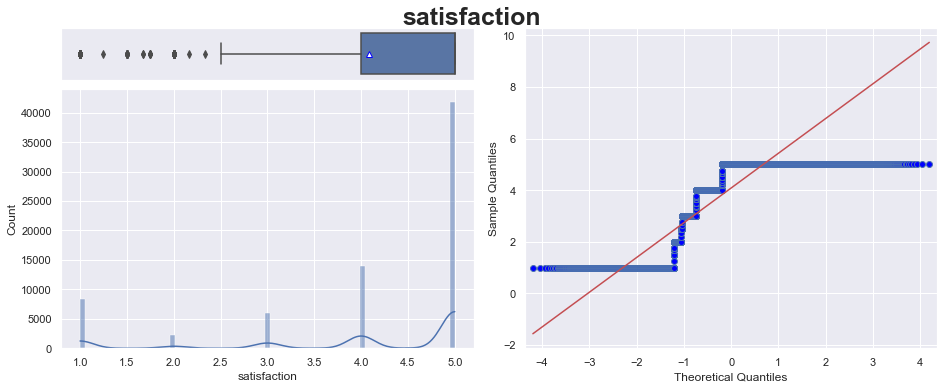


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,satisfaction,Shapiro-Wilk,"Statistics=0.692, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,satisfaction,D’Agostino’s K^2,"Statistics=13826.245, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,satisfaction,Kolmogorov-Smirnov,"Statistics=0.863, p-value=0.000",Sample does not look Gaussian (reject H₀)


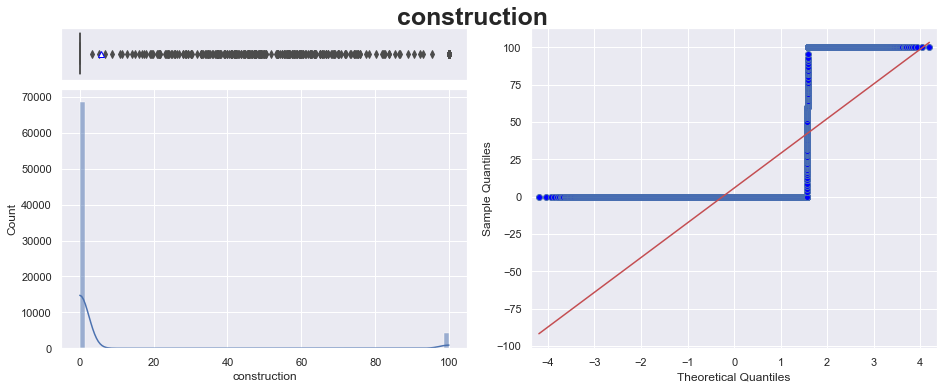


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,construction,Shapiro-Wilk,"Statistics=0.250, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,construction,D’Agostino’s K^2,"Statistics=54780.612, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,construction,Kolmogorov-Smirnov,"Statistics=0.500, p-value=0.000",Sample does not look Gaussian (reject H₀)


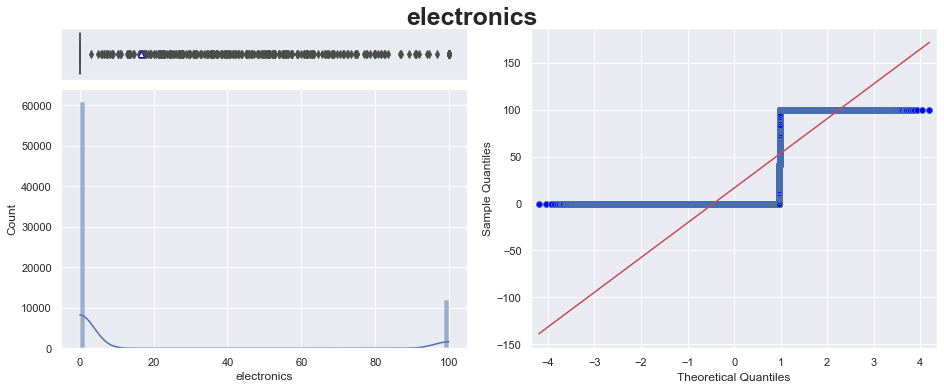


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,electronics,Shapiro-Wilk,"Statistics=0.449, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,electronics,D’Agostino’s K^2,"Statistics=21142.313, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,electronics,Kolmogorov-Smirnov,"Statistics=0.500, p-value=0.000",Sample does not look Gaussian (reject H₀)


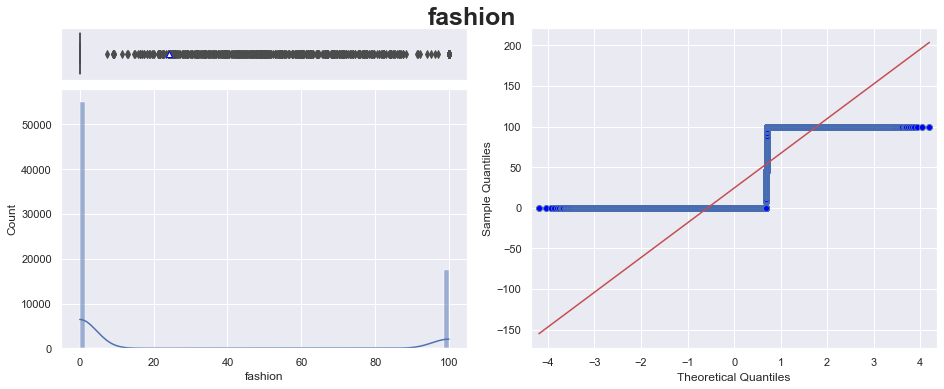


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,fashion,Shapiro-Wilk,"Statistics=0.536, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,fashion,D’Agostino’s K^2,"Statistics=13127.032, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,fashion,Kolmogorov-Smirnov,"Statistics=0.500, p-value=0.000",Sample does not look Gaussian (reject H₀)


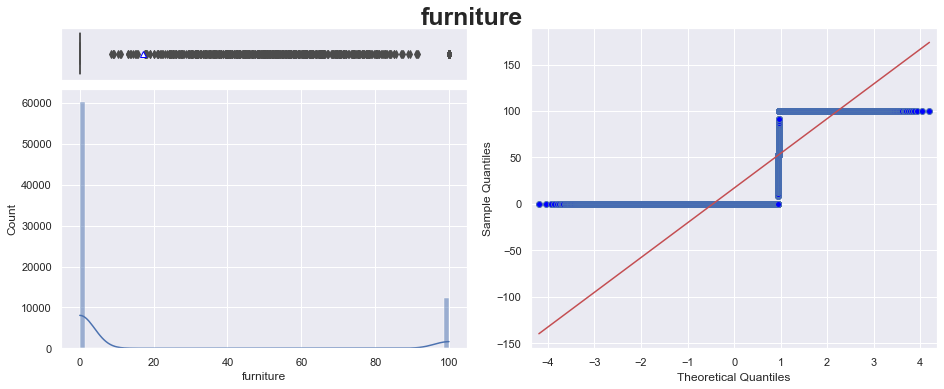


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,furniture,Shapiro-Wilk,"Statistics=0.460, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,furniture,D’Agostino’s K^2,"Statistics=20011.655, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,furniture,Kolmogorov-Smirnov,"Statistics=0.500, p-value=0.000",Sample does not look Gaussian (reject H₀)


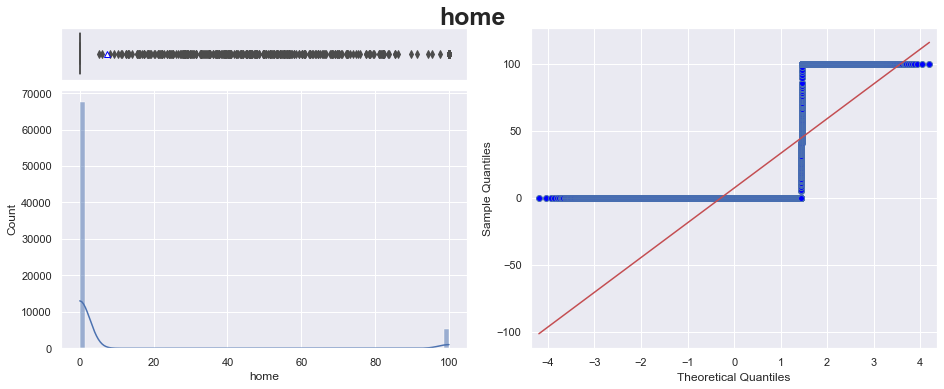


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,home,Shapiro-Wilk,"Statistics=0.289, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,home,D’Agostino’s K^2,"Statistics=47403.663, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,home,Kolmogorov-Smirnov,"Statistics=0.500, p-value=0.000",Sample does not look Gaussian (reject H₀)


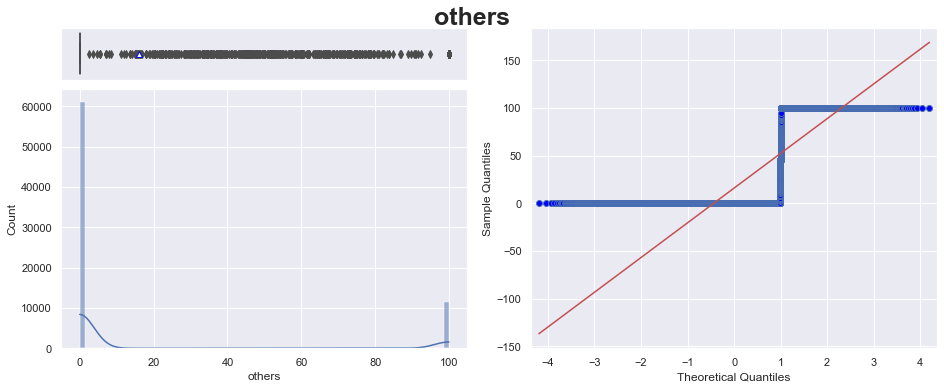


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,others,Shapiro-Wilk,"Statistics=0.444, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,others,D’Agostino’s K^2,"Statistics=22225.009, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,others,Kolmogorov-Smirnov,"Statistics=0.500, p-value=0.000",Sample does not look Gaussian (reject H₀)


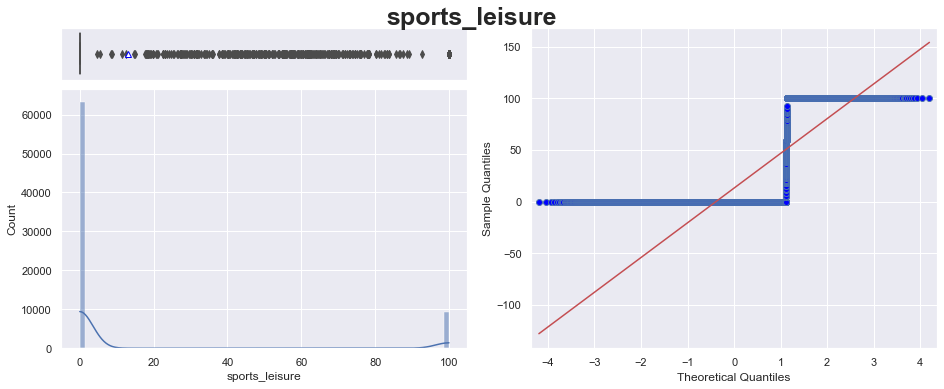


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,sports_leisure,Shapiro-Wilk,"Statistics=0.400, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,sports_leisure,D’Agostino’s K^2,"Statistics=28620.191, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,sports_leisure,Kolmogorov-Smirnov,"Statistics=0.500, p-value=0.000",Sample does not look Gaussian (reject H₀)


In [240]:
for var in data._get_numeric_data().columns:
    
    # We are going to work only with the rows without missing-values for the features
    df_subset = pd.DataFrame(data[data[[var]].notnull().all(axis=1)]).reset_index(drop=True)
    
    fig = plt.figure(constrained_layout=True, figsize=[13,5])
    fig.suptitle(var, size=25, fontweight="bold", y=1.05)
    spec = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[1, 1], height_ratios=[1, 5])

    ax_box = fig.add_subplot(spec[0, 0])
    ax_hist = fig.add_subplot(spec[1, 0])
    ax_qqplot = fig.add_subplot(spec[:, 1])

    # Boxplot
    boxplot = sns.boxplot(data=df_subset, x=df_subset[var], showmeans=True, ax=ax_box,
                          meanprops={"markerfacecolor":"white", "markeredgecolor":"blue"})
    ax_box.set(xlabel="", xticks=[])
    ax_box.set(yticks=[])
    boxplot.set_title("")

    # Histplot
    sns.histplot(data=df_subset, x=df_subset[var], bins=75,  kde=True,  ax=ax_hist)
    ax_hist.set(xlabel=var)
    
    # QQplot
    qqplot(df_subset[var], line='s', ax=ax_qqplot)

#     plt.savefig("images/qqplot-of-" + var + ".png")
    plt.show()

    print("\nMaking the Normality Test")
    print("---------------------------------")
    normality_test(df_subset[[var]])
    print("\n")

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">9.2. Bivariate analysis for continous variables</h3>
</div>

In [241]:
list_variables, list_COEF, list_MSE, list_RMSE, list_R2SCORE = ([] for i in range(5))

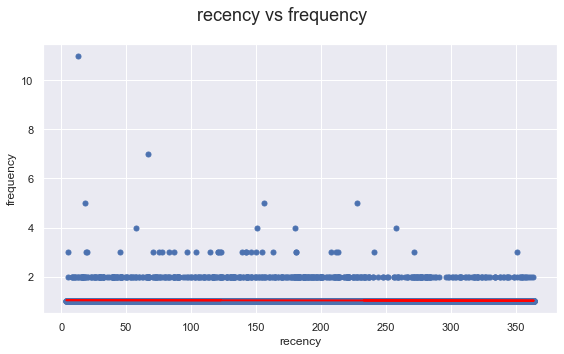

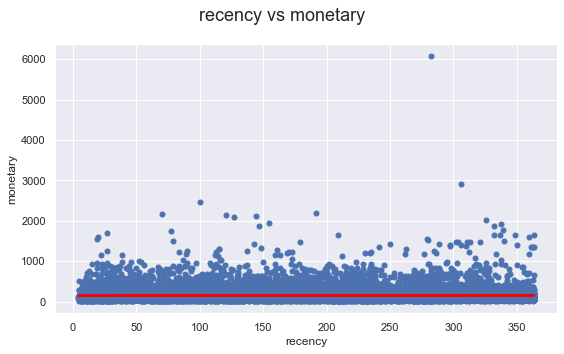

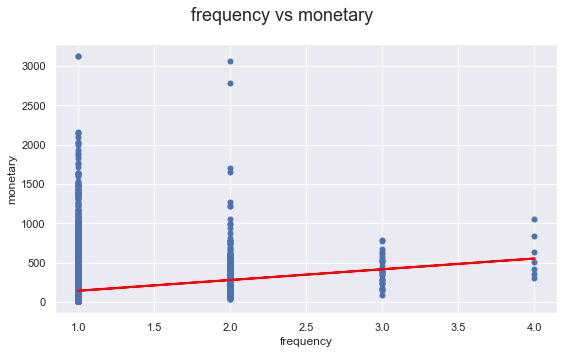

In [242]:
for feature, target in combinations(["recency", "frequency", "monetary"], 2):

    lr = LinearRegression()
    xtrain, xtest, ytrain, ytest = train_test_split(data[[feature]], data[[target]], test_size=0.3)
    lr = LinearRegression()
    lr_baseline = lr.fit(xtrain, ytrain)
    pred_baseline = lr_baseline.predict(xtest)

    list_variables.append(feature + " vs " + target)
    list_COEF.append(round(lr_baseline.coef_[0,0], 4))
    list_MSE.append(round(mean_squared_error(ytest, pred_baseline), 2))
    list_RMSE.append(round(math.sqrt(mean_squared_error(ytest, pred_baseline)), 2))
    list_R2SCORE.append(round(r2_score(ytest, pred_baseline), 2))

    # PLotting the graph
    plt.figure(figsize=(8,5))
    ax = plt.gca()

    plt.suptitle(feature + " vs " + target, fontsize=18)
    plt.plot(xtest, ytest, 'bo', markersize = 5)
    plt.plot(xtest, pred_baseline, color="red", linewidth = 2)
    plt.xlabel(feature, size=12)
    plt.ylabel(target, size=12)
    plt.tight_layout()
    plt.savefig("images/correlation-" + feature + "-vs-" + target + ".png")
    plt.show()

In [243]:
FEATURES = [
    "satisfaction", "fashion", "furniture", "others", "electronics"
]

TARGETS = [
    "recency", "frequency", "monetary"
]

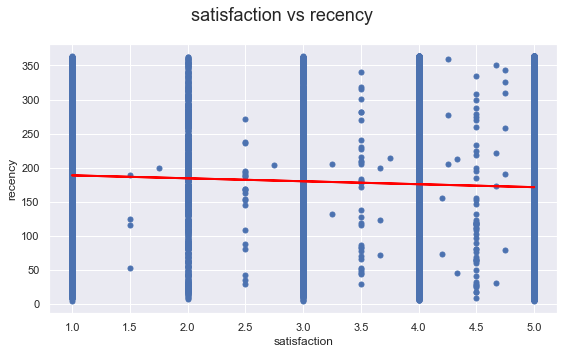

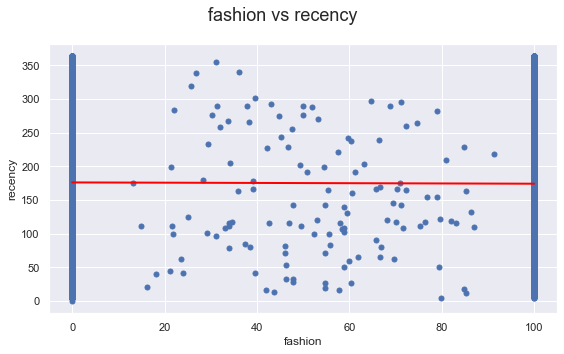

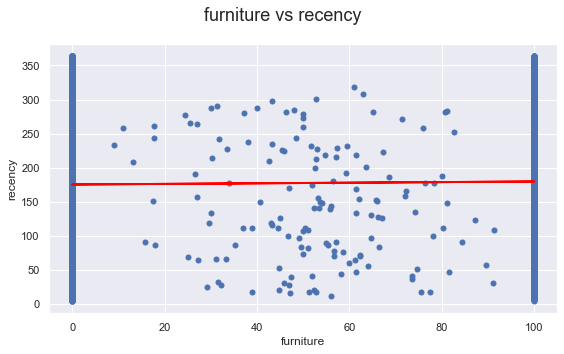

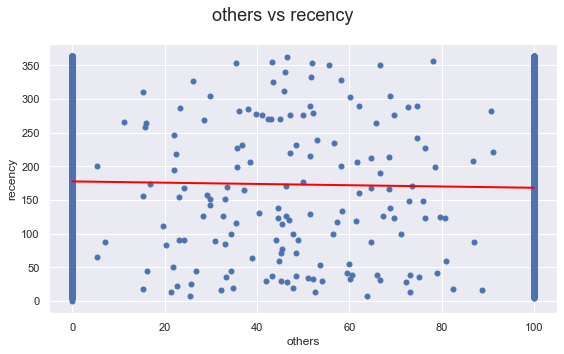

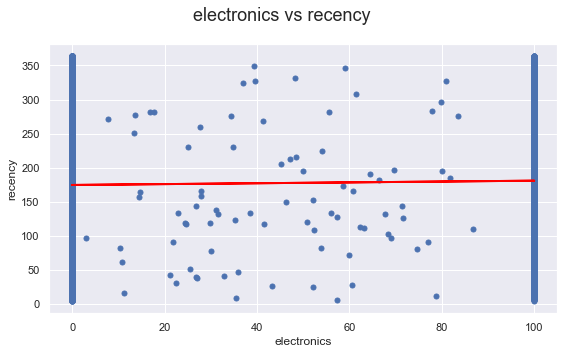

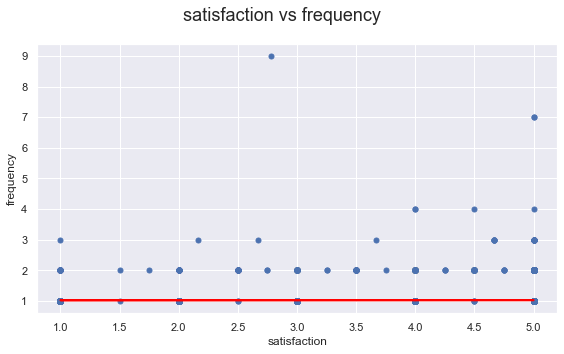

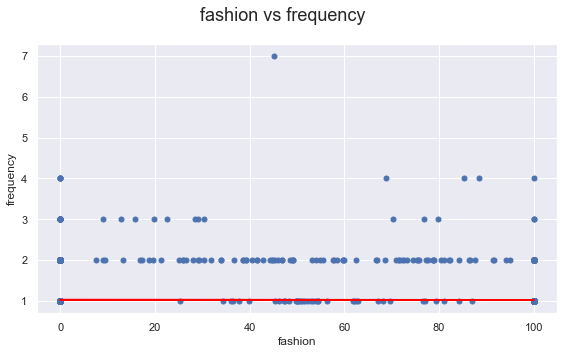

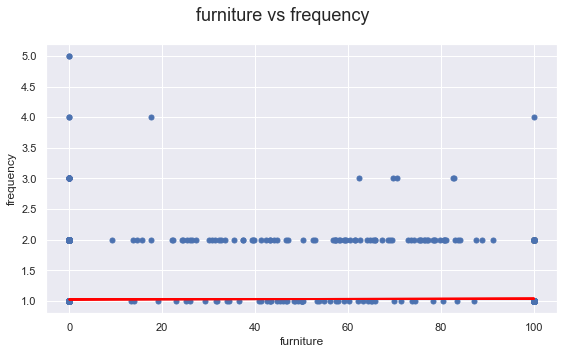

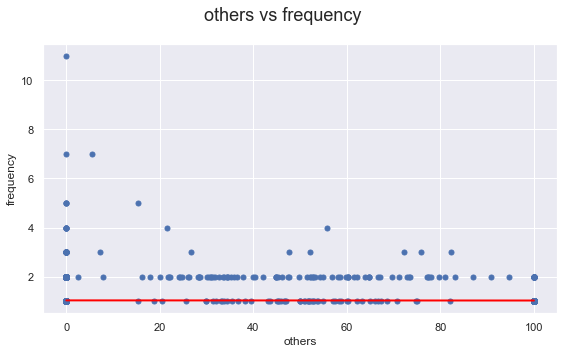

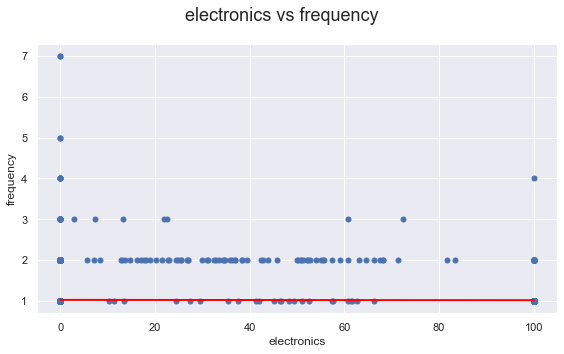

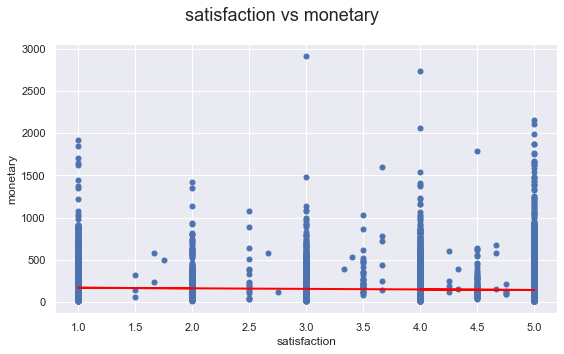

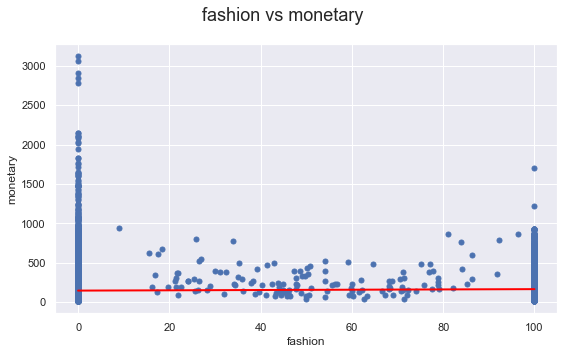

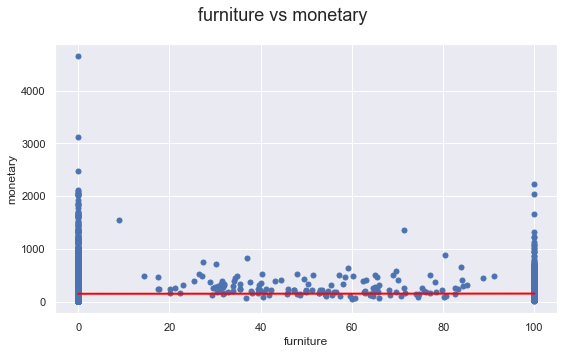

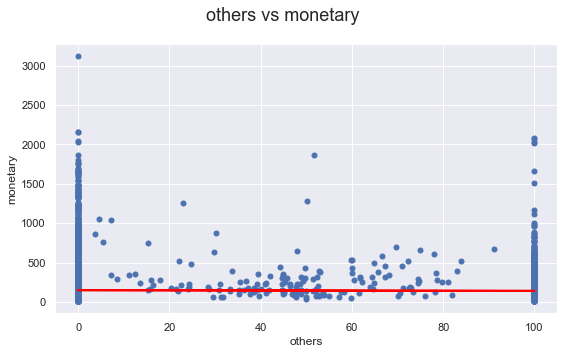

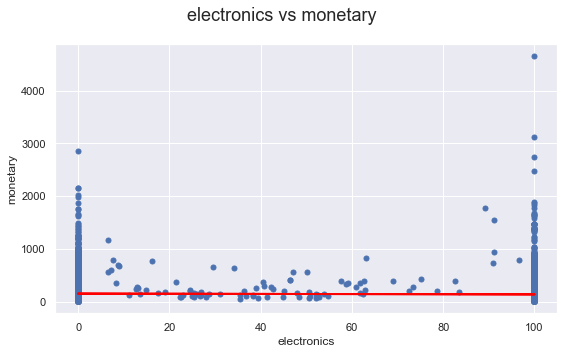

In [244]:
for target in TARGETS:
    
    for feature in FEATURES:
        
        # initializing Linear Regression by Pearson
        lr = LinearRegression()
        xtrain, xtest, ytrain, ytest = train_test_split(data[[feature]], data[[target]], test_size=0.3)
        lr = LinearRegression()
        lr_baseline = lr.fit(xtrain, ytrain)
        pred_baseline = lr_baseline.predict(xtest)

        list_variables.append(feature + " vs " + target)
        list_COEF.append(round(lr_baseline.coef_[0,0], 4))
        list_MSE.append(round(mean_squared_error(ytest, pred_baseline), 2))
        list_RMSE.append(round(math.sqrt(mean_squared_error(ytest, pred_baseline)), 2))
        list_R2SCORE.append(round(r2_score(ytest, pred_baseline), 2))

        # PLotting the graph
        plt.figure(figsize=(8,5))
        ax = plt.gca()

        plt.suptitle(feature + " vs " + target, fontsize=18)
        plt.plot(xtest, ytest, 'bo', markersize = 5)
        plt.plot(xtest, pred_baseline, color="red", linewidth = 2)
        plt.xlabel(feature, size=12)
        plt.ylabel(target, size=12)
        plt.tight_layout()
        plt.savefig("images/correlation-" + feature + "-vs-" + target + ".png")
        plt.show()

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">9.3. Correlation Matrix</h3>
</div>

<div class="alert alert-block alert-info">
    We are going to make the Correlation matrix for numeric features
</div>

In [245]:
NUMERIC_COLS = data._get_numeric_data().columns

In [246]:
NUMERIC_COLS

Index(['recency', 'frequency', 'monetary', 'satisfaction', 'construction',
       'electronics', 'fashion', 'furniture', 'home', 'others',
       'sports_leisure'],
      dtype='object')

In [247]:
df_temp = pd.DataFrame(data[NUMERIC_COLS]).copy()

In [248]:
df_correlation_matrix = pd.DataFrame(df_temp.corr()).round(2)

In [249]:
mask = np.zeros_like(df_correlation_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True 

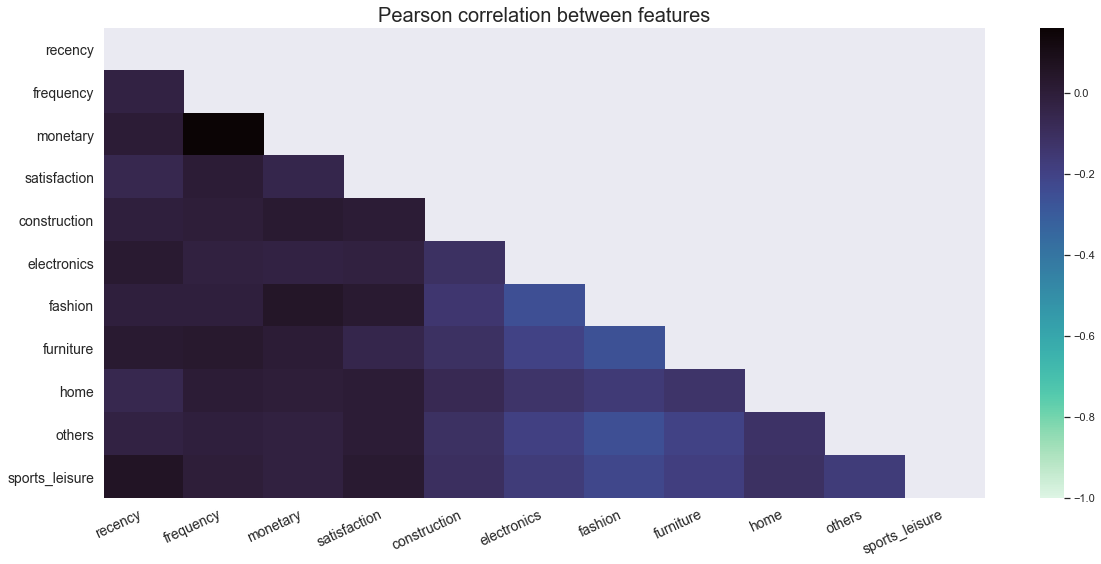

In [250]:
plt.figure(figsize=(17,8))
plt.title("Pearson correlation between features", size=20)

ax = sns.heatmap(df_correlation_matrix, mask=mask, vmin=-1, cmap="mako_r")

plt.xticks(rotation=25, size=14, horizontalalignment="right")
plt.yticks(rotation=0, size=14)
plt.tight_layout()
plt.savefig("images/pearson-correlation-between-features.png")
plt.show()



<div class="alert alert-block alert-success">
    <b>Observations / Conclusions</b>
    
        <ul style="list-style-type: square;">
            <li>There are a few highly correlated features</li>
        </ul>               
</div>

In [251]:
for i in range(0, 12, 2):
    df_analysis(globals()["data_" + str(i) + "_months"] , "data_" + str(i) + "_months",
                type_analysis="complete")     


Analysis of data_0_months dataset
--------------------------------------------------------------------
- Dataset shape:                  73074 rows and 12 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 7.2+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,customer_unique_id,object,73074,73074,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,recency,int64,73074,362,0,0.00000,175.79129,0.00000,92.00000,175.00000,263.00000,364.00000,98.87073
2,frequency,int64,73074,8,0,0.00000,1.02745,1.00000,1.00000,1.00000,1.00000,11.00000,0.18625
3,monetary,float64,73074,27186,0,0.00000,148.84485,9.59000,63.10000,107.69500,177.36000,6081.54000,155.56498
4,satisfaction,float64,73074,29,0,0.00000,4.08241,1.00000,4.00000,5.00000,5.00000,5.00000,1.34564
5,construction,float64,73074,248,0,0.00000,5.81903,0.00000,0.00000,0.00000,0.00000,100.00000,23.25587
6,electronics,float64,73074,280,0,0.00000,16.46334,0.00000,0.00000,0.00000,0.00000,100.00000,36.98389
7,fashion,float64,73074,457,0,0.00000,24.29487,0.00000,0.00000,0.00000,0.00000,100.00000,42.73351
8,furniture,float64,73074,509,0,0.00000,17.05804,0.00000,0.00000,0.00000,0.00000,100.00000,37.41165
9,home,float64,73074,287,0,0.00000,7.34880,0.00000,0.00000,0.00000,0.00000,100.00000,25.93429



Analysis of data_2_months dataset
--------------------------------------------------------------------
- Dataset shape:                  69048 rows and 12 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 6.8+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,customer_unique_id,object,69048,69048,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,recency,int64,69048,365,0,0.00000,164.05854,0.00000,81.00000,157.00000,235.00000,364.00000,98.72475
2,frequency,int64,69048,8,0,0.00000,1.02959,1.00000,1.00000,1.00000,1.00000,9.00000,0.19415
3,monetary,float64,69048,25436,0,0.00000,149.54566,10.07000,63.23000,107.28000,177.29250,6081.54000,157.94393
4,satisfaction,float64,69048,33,0,0.00000,4.06723,1.00000,4.00000,5.00000,5.00000,5.00000,1.35171
5,construction,float64,69048,202,0,0.00000,5.66519,0.00000,0.00000,0.00000,0.00000,100.00000,22.98257
6,electronics,float64,69048,277,0,0.00000,16.80132,0.00000,0.00000,0.00000,0.00000,100.00000,37.28142
7,fashion,float64,69048,461,0,0.00000,23.89601,0.00000,0.00000,0.00000,0.00000,100.00000,42.48052
8,furniture,float64,69048,505,0,0.00000,17.75399,0.00000,0.00000,0.00000,0.00000,100.00000,37.99984
9,home,float64,69048,278,0,0.00000,6.93586,0.00000,0.00000,0.00000,0.00000,100.00000,25.23196



Analysis of data_4_months dataset
--------------------------------------------------------------------
- Dataset shape:                  63145 rows and 12 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 6.3+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,customer_unique_id,object,63145,63145,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,recency,int64,63145,365,0,0.00000,153.26829,0.00000,68.00000,145.00000,231.00000,364.00000,100.59860
2,frequency,int64,63145,8,0,0.00000,1.03102,1.00000,1.00000,1.00000,1.00000,9.00000,0.19859
3,monetary,float64,63145,22790,0,0.00000,148.41997,10.07000,63.10000,106.38000,176.17000,6081.54000,155.77463
4,satisfaction,float64,63145,33,0,0.00000,4.04336,1.00000,4.00000,5.00000,5.00000,5.00000,1.36417
5,construction,float64,63145,155,0,0.00000,5.32342,0.00000,0.00000,0.00000,0.00000,100.00000,22.33850
6,electronics,float64,63145,237,0,0.00000,17.16078,0.00000,0.00000,0.00000,0.00000,100.00000,37.60559
7,fashion,float64,63145,407,0,0.00000,23.65292,0.00000,0.00000,0.00000,0.00000,100.00000,42.33539
8,furniture,float64,63145,438,0,0.00000,17.84570,0.00000,0.00000,0.00000,0.00000,100.00000,38.08600
9,home,float64,63145,247,0,0.00000,6.85245,0.00000,0.00000,0.00000,0.00000,100.00000,25.09094



Analysis of data_6_months dataset
--------------------------------------------------------------------
- Dataset shape:                  54331 rows and 12 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 5.4+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,customer_unique_id,object,54331,54331,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,recency,int64,54331,365,0,0.00000,145.55755,0.00000,58.00000,124.00000,225.00000,364.00000,101.02515
2,frequency,int64,54331,8,0,0.00000,1.03195,1.00000,1.00000,1.00000,1.00000,9.00000,0.19988
3,monetary,float64,54331,19641,0,0.00000,147.28518,10.07000,62.59000,105.37000,175.64000,6081.54000,154.64985
4,satisfaction,float64,54331,31,0,0.00000,4.06412,1.00000,4.00000,5.00000,5.00000,5.00000,1.34555
5,construction,float64,54331,116,0,0.00000,5.17655,0.00000,0.00000,0.00000,0.00000,100.00000,22.05692
6,electronics,float64,54331,218,0,0.00000,17.11128,0.00000,0.00000,0.00000,0.00000,100.00000,37.55673
7,fashion,float64,54331,361,0,0.00000,23.70954,0.00000,0.00000,0.00000,0.00000,100.00000,42.36435
8,furniture,float64,54331,366,0,0.00000,18.19668,0.00000,0.00000,0.00000,0.00000,100.00000,38.38548
9,home,float64,54331,218,0,0.00000,6.82203,0.00000,0.00000,0.00000,0.00000,100.00000,25.03333



Analysis of data_8_months dataset
--------------------------------------------------------------------
- Dataset shape:                  43319 rows and 12 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 4.3+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,customer_unique_id,object,43319,43319,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,recency,int64,43319,363,0,0.00000,138.13998,0.00000,48.00000,124.00000,214.00000,362.00000,95.90893
2,frequency,int64,43319,7,0,0.00000,1.03119,1.00000,1.00000,1.00000,1.00000,9.00000,0.19593
3,monetary,float64,43319,17392,0,0.00000,148.14801,10.07000,62.74000,105.28000,175.77000,6081.54000,159.16987
4,satisfaction,float64,43319,26,0,0.00000,4.10770,1.00000,4.00000,5.00000,5.00000,5.00000,1.31124
5,construction,float64,43319,89,0,0.00000,5.22669,0.00000,0.00000,0.00000,0.00000,100.00000,22.16283
6,electronics,float64,43319,162,0,0.00000,15.69025,0.00000,0.00000,0.00000,0.00000,100.00000,36.26920
7,fashion,float64,43319,288,0,0.00000,24.25565,0.00000,0.00000,0.00000,0.00000,100.00000,42.69681
8,furniture,float64,43319,283,0,0.00000,18.96872,0.00000,0.00000,0.00000,0.00000,100.00000,39.01517
9,home,float64,43319,177,0,0.00000,6.94664,0.00000,0.00000,0.00000,0.00000,100.00000,25.23908



Analysis of data_10_months dataset
--------------------------------------------------------------------
- Dataset shape:                  30640 rows and 12 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 3.0+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,customer_unique_id,object,30640,30640,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,recency,int64,30640,302,0,0.00000,121.80160,0.00000,53.00000,112.00000,182.00000,301.00000,79.00126
2,frequency,int64,30640,6,0,0.00000,1.03078,1.00000,1.00000,1.00000,1.00000,8.00000,0.19373
3,monetary,float64,30640,13875,0,0.00000,149.16142,10.07000,62.59000,105.00500,175.77000,4042.74000,163.01552
4,satisfaction,float64,30640,23,0,0.00000,4.16715,1.00000,4.00000,5.00000,5.00000,5.00000,1.26137
5,construction,float64,30640,49,0,0.00000,4.70069,0.00000,0.00000,0.00000,0.00000,100.00000,21.09241
6,electronics,float64,30640,99,0,0.00000,15.73655,0.00000,0.00000,0.00000,0.00000,100.00000,36.32649
7,fashion,float64,30640,184,0,0.00000,24.29048,0.00000,0.00000,0.00000,0.00000,100.00000,42.73545
8,furniture,float64,30640,187,0,0.00000,19.55644,0.00000,0.00000,0.00000,0.00000,100.00000,39.48665
9,home,float64,30640,122,0,0.00000,7.51190,0.00000,0.00000,0.00000,0.00000,100.00000,26.18304


<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">10. Adding / Transforming features II</h2>
</div>

<div class="alert alert-block alert-warning">
    <p>So far, we have the final dataset but, we can identify some issues that need to be treated. We describe them below</p>
    <ul style="list-style-type: square;">
        <li>Most samples on <b>Frequency</b> are 1.</li>
        <li>Most samples on <b>Categories</b> are 0.</li>
    </ul> 
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">10.1. Frequency</h3>
</div>

<div class="alert alert-block alert-info">
    <p><b>Frequency</b>: we are going to treat this feature as a boolean where if the customer has bought more than once, the value will be 1, if not, the value will be 0.</p>
</div>

In [252]:
data_0_months.sort_values(["frequency"], ascending=False)

,customer_unique_id,recency,frequency,monetary,satisfaction,construction,electronics,fashion,furniture,home,others,sports_leisure
40204,8d50f5eadf50201ccdcedfb9e2ac8455,13,11,557.15,5.000000,6.938885,0.000000,9.365521,0.000000,0.000000,0.0000,83.695594
17808,3e43e6105506432c953e165fb2acf44c,187,9,1172.67,2.777778,21.682144,6.495433,0.000000,60.485047,11.337375,0.0000,0.000000
28666,6469f99c1f9dfae7733b25662e7f1782,67,7,758.83,5.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.0000,0.000000
57865,ca77025e7201e3b30c44b472ff346268,93,7,1122.72,5.000000,0.000000,0.000000,42.859306,41.726343,15.414351,0.0000,0.000000
7795,1b6c7548a2a1f9037c1fd3ddfed95f33,200,7,959.01,5.000000,0.000000,0.000000,45.187224,32.652423,16.722453,5.4379,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
24662,5683f4e2b934479bb52058862b6ab3c6,235,1,153.09,4.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.0000,0.000000
24663,5684bb363845deec13ca8b8d4b071c82,125,1,62.13,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,100.000000
24664,56866c2bd443a3330747d4efa3541c6b,341,1,65.50,4.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.0000,0.000000
24665,568694a0655ae3b54872699d7a156a39,323,1,506.98,5.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.0000,0.000000


<div class="alert alert-block alert-info">
    <p>Let's keep some customer to verify the process</p>
</div>

In [253]:
CUSTOMERS = {
    "8d50f5eadf50201ccdcedfb9e2ac8455" : 11,
    "3e43e6105506432c953e165fb2acf44c" : 9,
    "6469f99c1f9dfae7733b25662e7f1782" : 7,
    "5683f4e2b934479bb52058862b6ab3c6" : 1,
    "56866c2bd443a3330747d4efa3541c6b" : 1
}

In [254]:
for i in range(0, 12, 2):
    
    globals()["data_" + str(i) + "_months"]["new_frequency"] = np.where(globals()["data_" + str(i) + "_months"]["frequency"] == 1,
                                                                       False, True)

In [255]:
data_0_months.sort_values(["frequency"], ascending=False)

,customer_unique_id,recency,frequency,monetary,satisfaction,construction,electronics,fashion,furniture,home,others,sports_leisure,new_frequency
40204,8d50f5eadf50201ccdcedfb9e2ac8455,13,11,557.15,5.000000,6.938885,0.000000,9.365521,0.000000,0.000000,0.0000,83.695594,True
17808,3e43e6105506432c953e165fb2acf44c,187,9,1172.67,2.777778,21.682144,6.495433,0.000000,60.485047,11.337375,0.0000,0.000000,True
28666,6469f99c1f9dfae7733b25662e7f1782,67,7,758.83,5.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.0000,0.000000,True
57865,ca77025e7201e3b30c44b472ff346268,93,7,1122.72,5.000000,0.000000,0.000000,42.859306,41.726343,15.414351,0.0000,0.000000,True
7795,1b6c7548a2a1f9037c1fd3ddfed95f33,200,7,959.01,5.000000,0.000000,0.000000,45.187224,32.652423,16.722453,5.4379,0.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24662,5683f4e2b934479bb52058862b6ab3c6,235,1,153.09,4.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.0000,0.000000,False
24663,5684bb363845deec13ca8b8d4b071c82,125,1,62.13,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,100.000000,False
24664,56866c2bd443a3330747d4efa3541c6b,341,1,65.50,4.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.0000,0.000000,False
24665,568694a0655ae3b54872699d7a156a39,323,1,506.98,5.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.0000,0.000000,False


In [256]:
for i in range(0, 12, 2):
    
    del globals()["data_" + str(i) + "_months"]["frequency"]
    globals()["data_" + str(i) + "_months"].rename(columns={"new_frequency":"frequency"}, inplace=True)
    
    globals()["data_" + str(i) + "_months"] = globals()["data_" + str(i) + "_months"]\
                                                    [["customer_unique_id", "recency", "frequency", 
                                                      "monetary", "satisfaction", "fashion", 
                                                      "furniture", "others", "electronics",
                                                      "sports_leisure", "home", "construction"]]

In [257]:
data_0_months.loc[data_0_months["customer_unique_id"].isin(CUSTOMERS.keys())]

,customer_unique_id,recency,frequency,monetary,satisfaction,fashion,furniture,others,electronics,sports_leisure,home,construction
17808,3e43e6105506432c953e165fb2acf44c,187,True,1172.67,2.777778,0.000000,60.485047,0.0,6.495433,0.000000,11.337375,21.682144
24662,5683f4e2b934479bb52058862b6ab3c6,235,False,153.09,4.000000,100.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
24664,56866c2bd443a3330747d4efa3541c6b,341,False,65.50,4.000000,100.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
28666,6469f99c1f9dfae7733b25662e7f1782,67,True,758.83,5.000000,0.000000,100.000000,0.0,0.000000,0.000000,0.000000,0.000000
40204,8d50f5eadf50201ccdcedfb9e2ac8455,13,True,557.15,5.000000,9.365521,0.000000,0.0,0.000000,83.695594,0.000000,6.938885


<div class="alert alert-block alert-success">
    <p>We can see that the results is ok.</p>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">10.2. Saving dataset to make the models</h3>
</div>

In [258]:
for i in range(0, 12, 2):
    df_analysis(globals()["data_" + str(i) + "_months"] , "data_" + str(i) + "_months",
                type_analysis="complete")     


Analysis of data_0_months dataset
--------------------------------------------------------------------
- Dataset shape:                  73074 rows and 12 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 8.8+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,customer_unique_id,object,73074,73074,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,recency,int64,73074,362,0,0.00000,175.79129,0.00000,92.00000,175.00000,263.00000,364.00000,98.87073
2,frequency,bool,73074,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,monetary,float64,73074,27186,0,0.00000,148.84485,9.59000,63.10000,107.69500,177.36000,6081.54000,155.56498
4,satisfaction,float64,73074,29,0,0.00000,4.08241,1.00000,4.00000,5.00000,5.00000,5.00000,1.34564
5,fashion,float64,73074,457,0,0.00000,24.29487,0.00000,0.00000,0.00000,0.00000,100.00000,42.73351
6,furniture,float64,73074,509,0,0.00000,17.05804,0.00000,0.00000,0.00000,0.00000,100.00000,37.41165
7,others,float64,73074,460,0,0.00000,15.92235,0.00000,0.00000,0.00000,0.00000,100.00000,36.40485
8,electronics,float64,73074,280,0,0.00000,16.46334,0.00000,0.00000,0.00000,0.00000,100.00000,36.98389
9,sports_leisure,float64,73074,305,0,0.00000,13.09358,0.00000,0.00000,0.00000,0.00000,100.00000,33.60157



Analysis of data_2_months dataset
--------------------------------------------------------------------
- Dataset shape:                  69048 rows and 12 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 8.4+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,customer_unique_id,object,69048,69048,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,recency,int64,69048,365,0,0.00000,164.05854,0.00000,81.00000,157.00000,235.00000,364.00000,98.72475
2,frequency,bool,69048,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,monetary,float64,69048,25436,0,0.00000,149.54566,10.07000,63.23000,107.28000,177.29250,6081.54000,157.94393
4,satisfaction,float64,69048,33,0,0.00000,4.06723,1.00000,4.00000,5.00000,5.00000,5.00000,1.35171
5,fashion,float64,69048,461,0,0.00000,23.89601,0.00000,0.00000,0.00000,0.00000,100.00000,42.48052
6,furniture,float64,69048,505,0,0.00000,17.75399,0.00000,0.00000,0.00000,0.00000,100.00000,37.99984
7,others,float64,69048,429,0,0.00000,15.27678,0.00000,0.00000,0.00000,0.00000,100.00000,35.79356
8,electronics,float64,69048,277,0,0.00000,16.80132,0.00000,0.00000,0.00000,0.00000,100.00000,37.28142
9,sports_leisure,float64,69048,314,0,0.00000,13.67086,0.00000,0.00000,0.00000,0.00000,100.00000,34.21346



Analysis of data_4_months dataset
--------------------------------------------------------------------
- Dataset shape:                  63145 rows and 12 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 7.9+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,customer_unique_id,object,63145,63145,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,recency,int64,63145,365,0,0.00000,153.26829,0.00000,68.00000,145.00000,231.00000,364.00000,100.59860
2,frequency,bool,63145,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,monetary,float64,63145,22790,0,0.00000,148.41997,10.07000,63.10000,106.38000,176.17000,6081.54000,155.77463
4,satisfaction,float64,63145,33,0,0.00000,4.04336,1.00000,4.00000,5.00000,5.00000,5.00000,1.36417
5,fashion,float64,63145,407,0,0.00000,23.65292,0.00000,0.00000,0.00000,0.00000,100.00000,42.33539
6,furniture,float64,63145,438,0,0.00000,17.84570,0.00000,0.00000,0.00000,0.00000,100.00000,38.08600
7,others,float64,63145,375,0,0.00000,15.11544,0.00000,0.00000,0.00000,0.00000,100.00000,35.64341
8,electronics,float64,63145,237,0,0.00000,17.16078,0.00000,0.00000,0.00000,0.00000,100.00000,37.60559
9,sports_leisure,float64,63145,288,0,0.00000,14.04929,0.00000,0.00000,0.00000,0.00000,100.00000,34.61063



Analysis of data_6_months dataset
--------------------------------------------------------------------
- Dataset shape:                  54331 rows and 12 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 7.0+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,customer_unique_id,object,54331,54331,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,recency,int64,54331,365,0,0.00000,145.55755,0.00000,58.00000,124.00000,225.00000,364.00000,101.02515
2,frequency,bool,54331,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,monetary,float64,54331,19641,0,0.00000,147.28518,10.07000,62.59000,105.37000,175.64000,6081.54000,154.64985
4,satisfaction,float64,54331,31,0,0.00000,4.06412,1.00000,4.00000,5.00000,5.00000,5.00000,1.34555
5,fashion,float64,54331,361,0,0.00000,23.70954,0.00000,0.00000,0.00000,0.00000,100.00000,42.36435
6,furniture,float64,54331,366,0,0.00000,18.19668,0.00000,0.00000,0.00000,0.00000,100.00000,38.38548
7,others,float64,54331,312,0,0.00000,14.80460,0.00000,0.00000,0.00000,0.00000,100.00000,35.34236
8,electronics,float64,54331,218,0,0.00000,17.11128,0.00000,0.00000,0.00000,0.00000,100.00000,37.55673
9,sports_leisure,float64,54331,255,0,0.00000,14.17933,0.00000,0.00000,0.00000,0.00000,100.00000,34.74182



Analysis of data_8_months dataset
--------------------------------------------------------------------
- Dataset shape:                  43319 rows and 12 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 5.0+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,customer_unique_id,object,43319,43319,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,recency,int64,43319,363,0,0.00000,138.13998,0.00000,48.00000,124.00000,214.00000,362.00000,95.90893
2,frequency,bool,43319,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,monetary,float64,43319,17392,0,0.00000,148.14801,10.07000,62.74000,105.28000,175.77000,6081.54000,159.16987
4,satisfaction,float64,43319,26,0,0.00000,4.10770,1.00000,4.00000,5.00000,5.00000,5.00000,1.31124
5,fashion,float64,43319,288,0,0.00000,24.25565,0.00000,0.00000,0.00000,0.00000,100.00000,42.69681
6,furniture,float64,43319,283,0,0.00000,18.96872,0.00000,0.00000,0.00000,0.00000,100.00000,39.01517
7,others,float64,43319,245,0,0.00000,14.12441,0.00000,0.00000,0.00000,0.00000,100.00000,34.65122
8,electronics,float64,43319,162,0,0.00000,15.69025,0.00000,0.00000,0.00000,0.00000,100.00000,36.26920
9,sports_leisure,float64,43319,199,0,0.00000,14.78764,0.00000,0.00000,0.00000,0.00000,100.00000,35.36127



Analysis of data_10_months dataset
--------------------------------------------------------------------
- Dataset shape:                  30640 rows and 12 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 3.8+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,customer_unique_id,object,30640,30640,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,recency,int64,30640,302,0,0.00000,121.80160,0.00000,53.00000,112.00000,182.00000,301.00000,79.00126
2,frequency,bool,30640,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,monetary,float64,30640,13875,0,0.00000,149.16142,10.07000,62.59000,105.00500,175.77000,4042.74000,163.01552
4,satisfaction,float64,30640,23,0,0.00000,4.16715,1.00000,4.00000,5.00000,5.00000,5.00000,1.26137
5,fashion,float64,30640,184,0,0.00000,24.29048,0.00000,0.00000,0.00000,0.00000,100.00000,42.73545
6,furniture,float64,30640,187,0,0.00000,19.55644,0.00000,0.00000,0.00000,0.00000,100.00000,39.48665
7,others,float64,30640,170,0,0.00000,13.67102,0.00000,0.00000,0.00000,0.00000,100.00000,34.17792
8,electronics,float64,30640,99,0,0.00000,15.73655,0.00000,0.00000,0.00000,0.00000,100.00000,36.32649
9,sports_leisure,float64,30640,129,0,0.00000,14.53291,0.00000,0.00000,0.00000,0.00000,100.00000,35.12108


<div class="alert alert-block alert-info">
    Now, we are going to save the dataset to make the models
</div>

In [259]:
for i in range(0, 12, 2):
    globals()["data_" + str(i) + "_months"].to_csv("datasets\data_to_model_" + str(i) + "_months.csv", index=False)